# SetUp and Libraries

In [ ]:
%pip install numba


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3.13 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import os
from scipy import stats
from collections import Counter
from datetime import datetime
import itertools
import random
import csv

In [ ]:
from typing import Tuple, List
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
import pandas as pd
import os
import time
from numba import njit, prange
import itertools

# Practical 1:

## Download Dataset

In [ ]:
# URL of the dataset
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
zip_file = "ml-32m.zip"
extract_folder = "ml-32m"

print(f"Starting download of {url}...")

# Use !wget to download the file in Colab
# -q makes it quiet (less output)
!wget -q $url

print("Download complete.")

# Check if the file was downloaded successfully
if os.path.exists(zip_file):
    print(f"Successfully downloaded {zip_file}.")

    # Unzip the file
    print(f"Unzipping {zip_file}...")
    # -o overwrites existing files without asking
    # -d specifies the directory to extract to
    !unzip -o $zip_file -d $extract_folder

    print(f"Successfully unzipped to '{extract_folder}' folder.")

    # List the contents of the extracted folder
    print(f"\nContents of {extract_folder}:")
    !ls -l $extract_folder
else:
    print(f"Error: {zip_file} was not downloaded.")

Starting download of https://files.grouplens.org/datasets/movielens/ml-32m.zip...
zsh:1: command not found: wget
Download complete.
Successfully downloaded ml-32m.zip.
Unzipping ml-32m.zip...
Archive:  ml-32m.zip
  inflating: ml-32m/ml-32m/tags.csv  
  inflating: ml-32m/ml-32m/links.csv  
  inflating: ml-32m/ml-32m/README.txt  
  inflating: ml-32m/ml-32m/checksums.txt  
  inflating: ml-32m/ml-32m/ratings.csv  
  inflating: ml-32m/ml-32m/movies.csv  
Successfully unzipped to 'ml-32m' folder.

Contents of ml-32m:
total 0
drwxrwxr-x@ 9 ethar  staff  288 Jan  7 17:03 ml-32m


In [ ]:
# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Running in Colab - mount Drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd /content/gdrive/MyDrive/Colab Notebooks/Ml_scale/ml-32m
else:
    # Running locally
    %cd /Users/ethar/Desktop/Master/Masters Blocks/MLscale/ml-32m

/Users/ethar/Desktop/Master/Masters Blocks/MLscale/ml-32m


## Content Verfication

In [ ]:
!md5sum links.csv movies.csv ratings.csv tags.csv

8f033867bcb4e6be8792b21468b4fa6e  links.csv
0df90835c19151f9d819d0822e190797  movies.csv
cf12b74f9ad4b94a011f079e26d4270a  ratings.csv
963bf4fa4de6b8901868fddd3eb54567  tags.csv


## Data Loading

In [ ]:
print("Loading MovieLens 32M dataset...")

# Load ratings (chunk reading for memory efficiency)
ratings = pd.read_csv('ratings.csv',
                      dtype={'userId': 'int32', 'movieId': 'int32',
                             'rating': 'float32', 'timestamp': 'int64'})

# Load movies
movies = pd.read_csv('movies.csv')

print(f"Loaded {len(ratings):,} ratings")
print(f"Loaded {len(movies):,} movies")

Loading MovieLens 32M dataset...
Loaded 32,000,204 ratings
Loaded 87,585 movies


In [ ]:
ratings.head()

userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

## Data Analysis and Visualizaion

In [ ]:
# Create plots directory
os.makedirs('plots', exist_ok=True)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Define color scheme
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'gradient_start': '#4A148C',
    'gradient_mid': '#00897B',
    'gradient_end': '#C6FF00'
}

from matplotlib.colors import LinearSegmentedColormap
colors_list = ['#4A148C', '#7B1FA2', '#00897B', '#26A69A', '#66BB6A', '#9CCC65', '#C6FF00']
n_bins = 100
cmap_custom = LinearSegmentedColormap.from_list('custom', colors_list, N=n_bins)

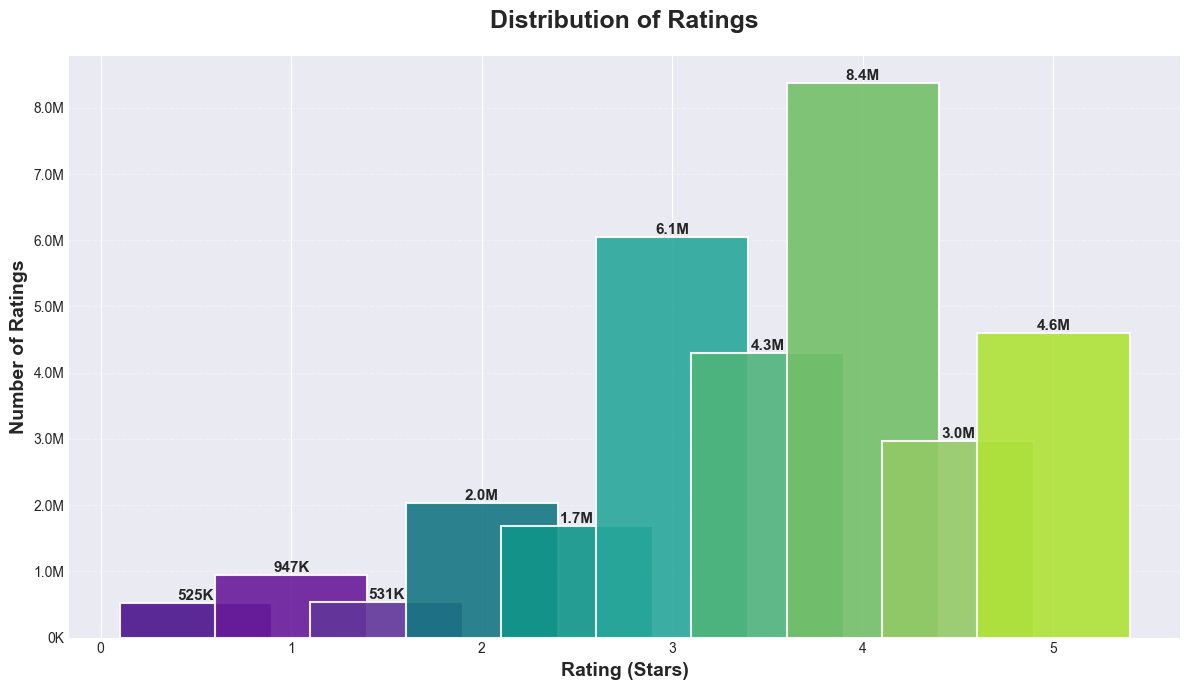

In [ ]:
# 1. RATING DISTRIBUTION

fig, ax = plt.subplots(figsize=(12, 7))

rating_counts = ratings['rating'].value_counts().sort_index()

bars = ax.bar(rating_counts.index, rating_counts.values,
              color=[cmap_custom(i/len(rating_counts)) for i in range(len(rating_counts))],
              edgecolor='white', linewidth=1.5, alpha=0.9)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e6:.1f}M' if height >= 1e6 else f'{height/1e3:.0f}K',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Rating (Stars)', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Ratings', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Ratings', fontsize=18, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

plt.tight_layout()
plt.savefig('plots/01_rating_distribution.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

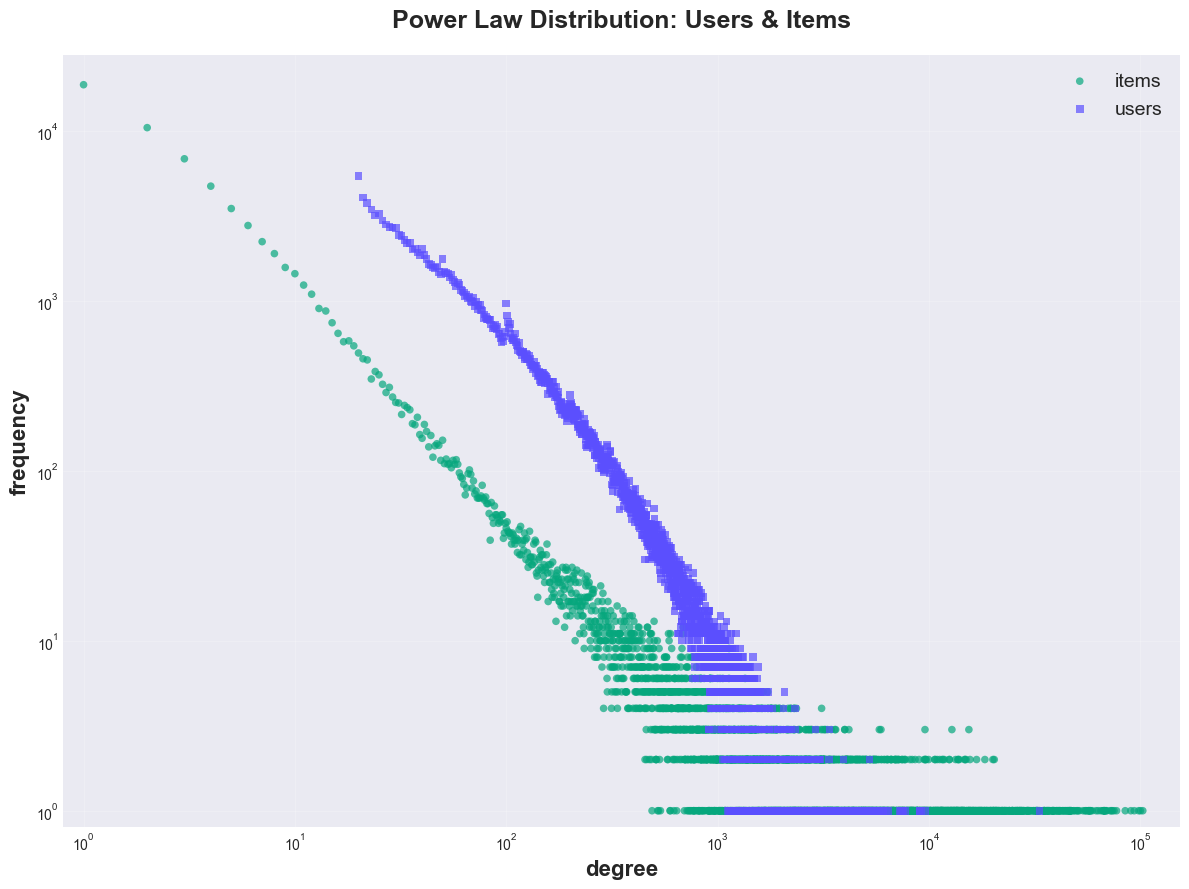

In [ ]:
# 2. COMBINED POWER LAW (Users & Items)

user_counts = ratings['userId'].value_counts().values
movie_counts = ratings['movieId'].value_counts().values

fig, ax = plt.subplots(figsize=(12, 9))

user_degree_counts = Counter(user_counts)
user_degrees = np.array(sorted(user_degree_counts.keys()))
user_frequencies = np.array([user_degree_counts[d] for d in user_degrees])

# For movies (items)
movie_degree_counts = Counter(movie_counts)
movie_degrees = np.array(sorted(movie_degree_counts.keys()))
movie_frequencies = np.array([movie_degree_counts[d] for d in movie_degrees])

# Plot with scatter points
ax.scatter(movie_degrees, movie_frequencies,
           c='#06A77D', marker='o', s=30, alpha=0.7,
           label='items', edgecolors='none')
ax.scatter(user_degrees, user_frequencies,
           c='#5B4FFF', marker='s', s=30, alpha=0.7,
           label='users', edgecolors='none')

# Set log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('degree', fontsize=16, fontweight='bold')
ax.set_ylabel('frequency', fontsize=16, fontweight='bold')
ax.set_title('Power Law Distribution: Users & Items', fontsize=18, fontweight='bold', pad=20)

# Legend
ax.legend(fontsize=14, loc='upper right', framealpha=0.9)

# Grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Set axis limits for better visualization
ax.set_xlim(left=0.8, right=max(max(user_degrees), max(movie_degrees)) * 1.5)
ax.set_ylim(bottom=0.8, top=max(max(user_frequencies), max(movie_frequencies)) * 1.5)

plt.tight_layout()
plt.savefig('plots/02_combined_power_law.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

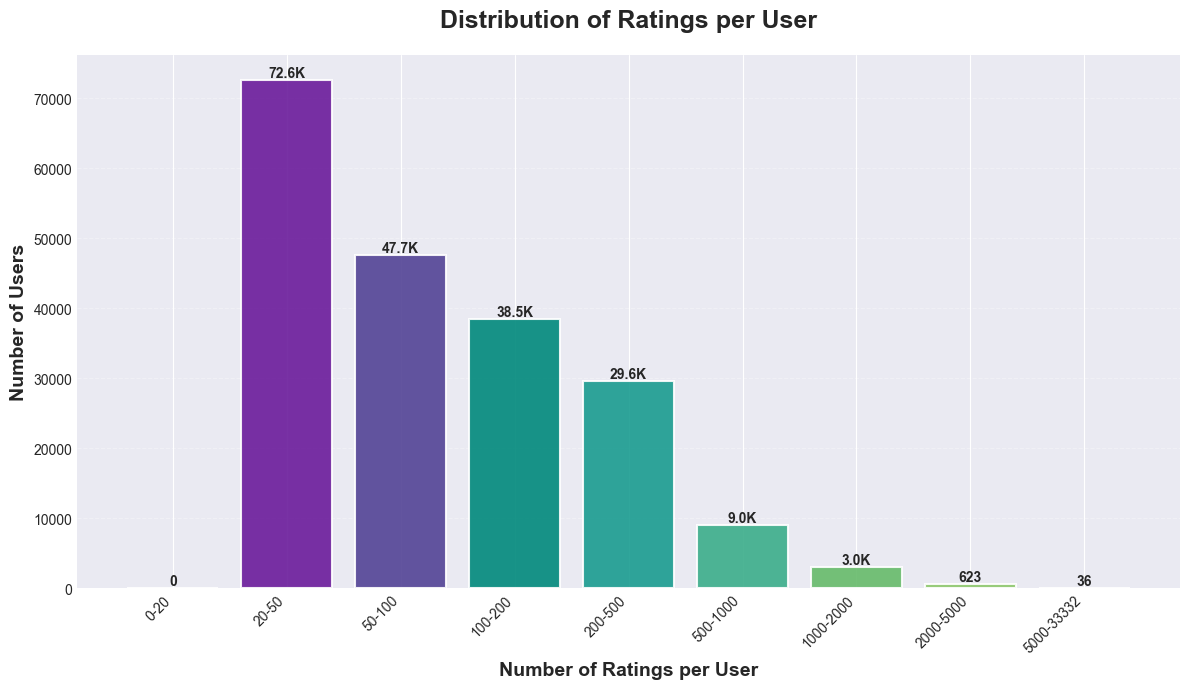

In [ ]:
# 3. RATINGS PER USER DISTRIBUTION

fig, ax = plt.subplots(figsize=(12, 7))

bins = [0, 20, 50, 100, 200, 500, 1000, 2000, 5000, max(user_counts)]
hist, edges = np.histogram(user_counts, bins=bins)

x_pos = range(len(hist))
labels = [f'{int(edges[i])}-{int(edges[i+1])}' for i in range(len(edges)-1)]

bars = ax.bar(x_pos, hist, color=[cmap_custom(i/len(hist)) for i in range(len(hist))],
              edgecolor='white', linewidth=1.5, alpha=0.9)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e3:.1f}K' if height >= 1e3 else f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Number of Ratings per User', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Users', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Ratings per User', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/03_ratings_per_user.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

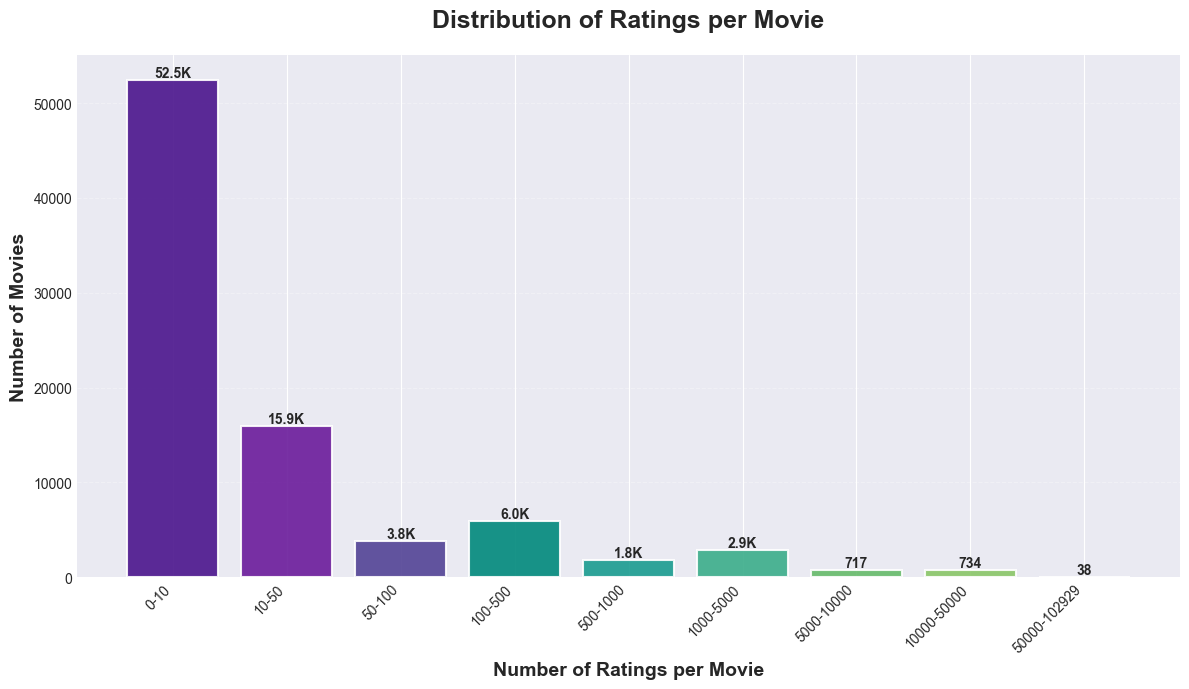

In [ ]:
# 4. RATINGS PER MOVIE DISTRIBUTION

fig, ax = plt.subplots(figsize=(12, 7))

bins = [0, 10, 50, 100, 500, 1000, 5000, 10000, 50000, max(movie_counts)]
hist, edges = np.histogram(movie_counts, bins=bins)

x_pos = range(len(hist))
labels = [f'{int(edges[i])}-{int(edges[i+1])}' for i in range(len(edges)-1)]

bars = ax.bar(x_pos, hist, color=[cmap_custom(i/len(hist)) for i in range(len(hist))],
              edgecolor='white', linewidth=1.5, alpha=0.9)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1e3:.1f}K' if height >= 1e3 else f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Number of Ratings per Movie', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Movies', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Ratings per Movie', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/04_ratings_per_movie.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

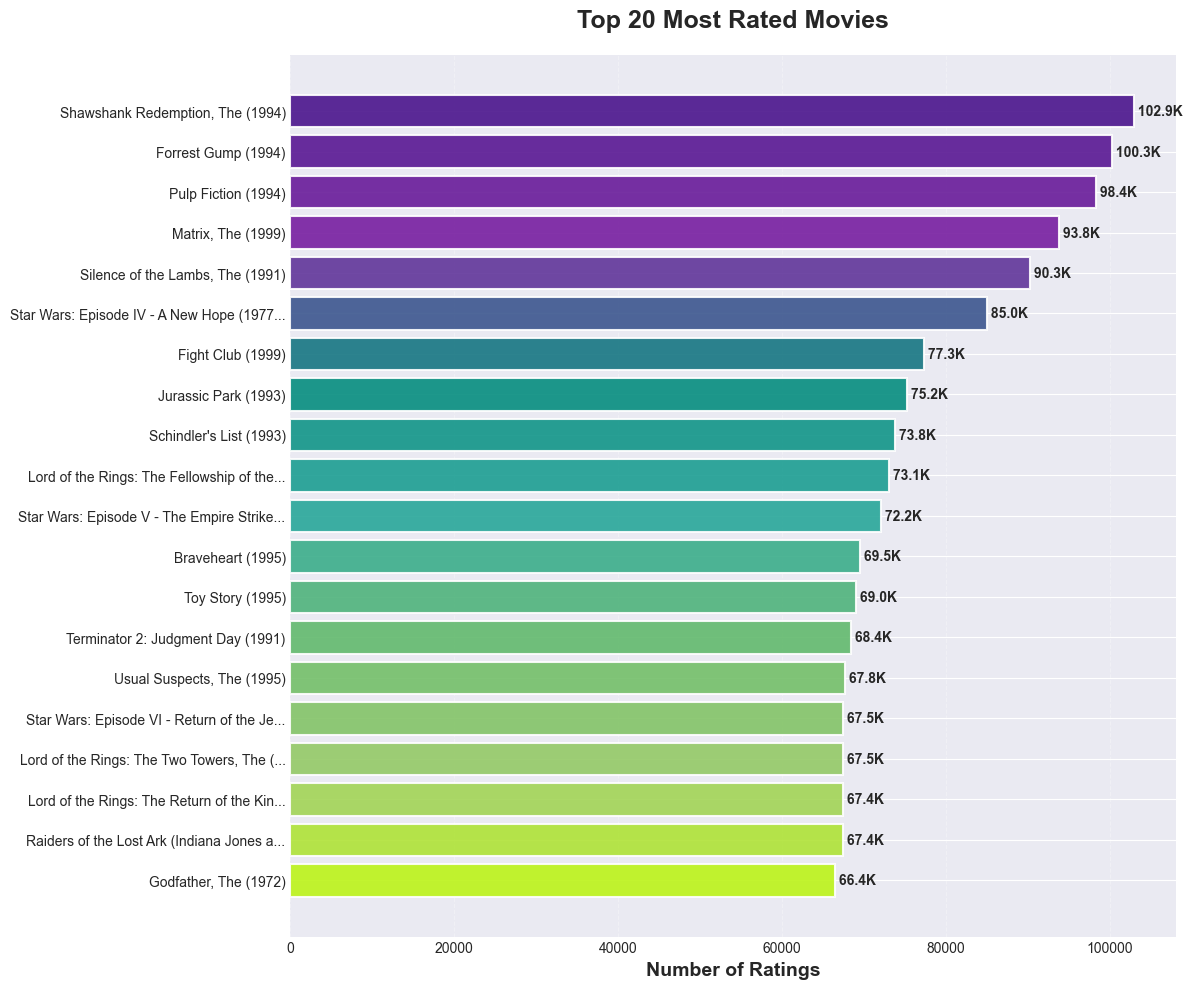

In [ ]:
# 5. TOP 20 MOST RATED MOVIES

top_movies = ratings['movieId'].value_counts().head(20)
top_movie_info = movies[movies['movieId'].isin(top_movies.index)].set_index('movieId')

fig, ax = plt.subplots(figsize=(12, 10))

labels = [top_movie_info.loc[movie_id, 'title'][:40] + '...'
          if len(top_movie_info.loc[movie_id, 'title']) > 40
          else top_movie_info.loc[movie_id, 'title']
          for movie_id in top_movies.index]

y_pos = np.arange(len(labels))
colors = [cmap_custom(i/len(labels)) for i in range(len(labels))]

bars = ax.barh(y_pos, top_movies.values, color=colors,
               edgecolor='white', linewidth=1.5, alpha=0.9)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f' {width/1e3:.1f}K',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel('Number of Ratings', fontsize=14, fontweight='bold')
ax.set_title('Top 20 Most Rated Movies', fontsize=18, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/05_top_20_movies.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

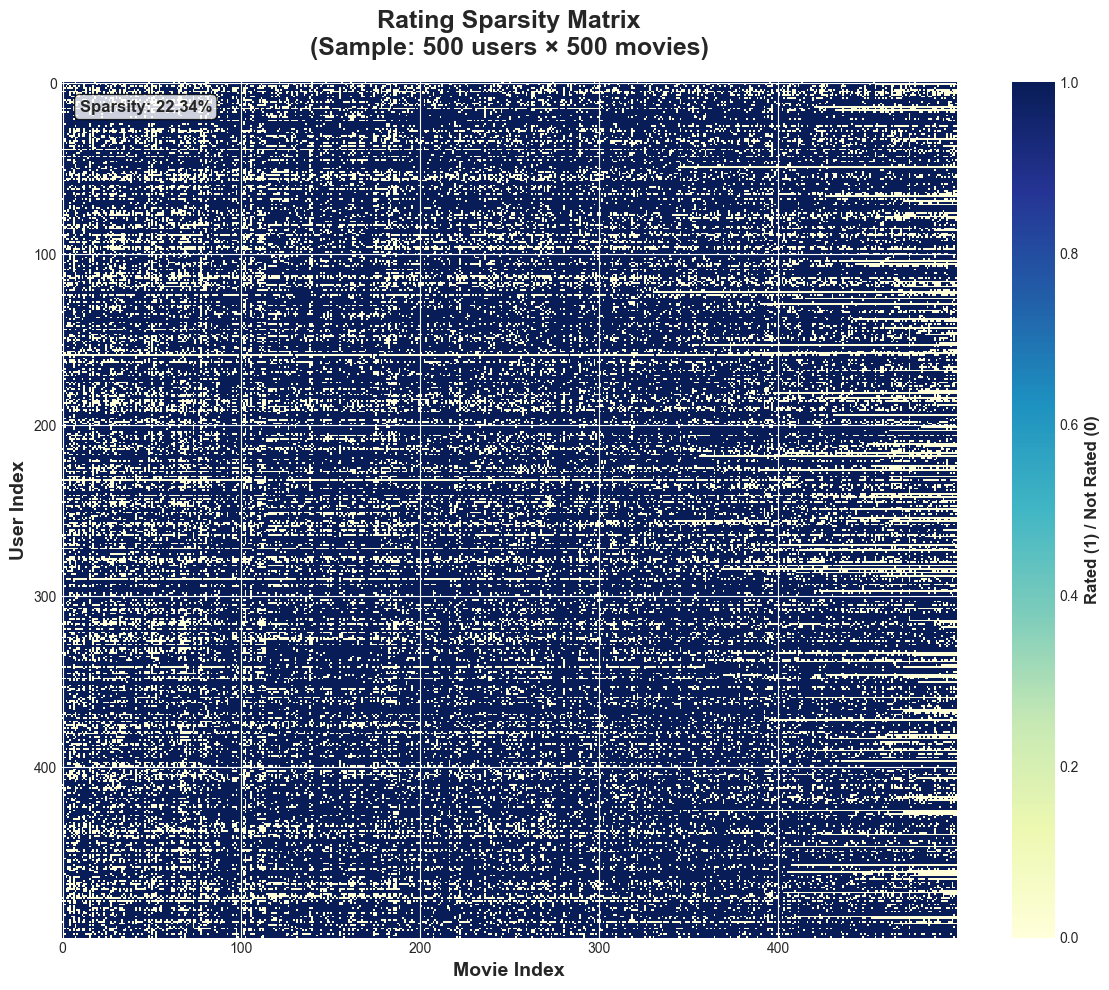

In [ ]:
# 6. RATING SPARSITY MATRIX VISUALIZATION

n_users_sample = 500
n_movies_sample = 500

top_users = ratings['userId'].value_counts().head(n_users_sample).index
top_movies_ids = ratings['movieId'].value_counts().head(n_movies_sample).index

sample_data = ratings[ratings['userId'].isin(top_users) &
                      ratings['movieId'].isin(top_movies_ids)]

matrix = sample_data.pivot_table(index='userId', columns='movieId',
                                 values='rating', fill_value=0)

fig, ax = plt.subplots(figsize=(12, 10))

sparsity_matrix = (matrix > 0).astype(int)

im = ax.imshow(sparsity_matrix, cmap='YlGnBu', aspect='auto', interpolation='nearest')

ax.set_xlabel('Movie Index', fontsize=14, fontweight='bold')
ax.set_ylabel('User Index', fontsize=14, fontweight='bold')
ax.set_title(f'Rating Sparsity Matrix\n(Sample: {n_users_sample} users × {n_movies_sample} movies)',
             fontsize=18, fontweight='bold', pad=20)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Rated (1) / Not Rated (0)', fontsize=12, fontweight='bold')

sparsity = 100 * (1 - np.sum(sparsity_matrix.values) / sparsity_matrix.size)
ax.text(0.02, 0.98, f'Sparsity: {sparsity:.2f}%',
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('plots/06_sparsity_matrix.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

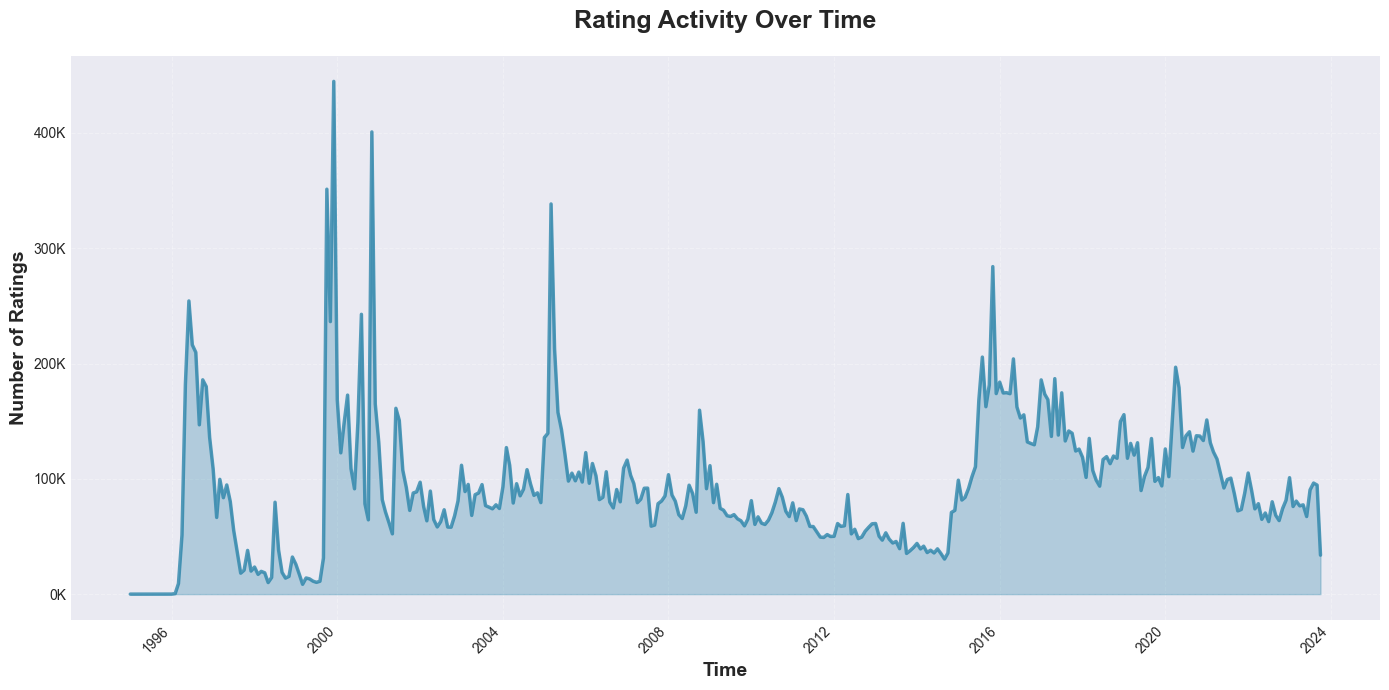

In [ ]:
# 7. RATING ACTIVITY OVER TIME

ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year_month'] = ratings['datetime'].dt.to_period('M')

activity_over_time = ratings.groupby('year_month').size()

fig, ax = plt.subplots(figsize=(14, 7))

x_vals = activity_over_time.index.to_timestamp()
y_vals = activity_over_time.values

ax.plot(x_vals, y_vals, color=COLORS['primary'], linewidth=2.5, alpha=0.8)
ax.fill_between(x_vals, y_vals, alpha=0.3, color=COLORS['primary'])

ax.set_xlabel('Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Ratings', fontsize=14, fontweight='bold')
ax.set_title('Rating Activity Over Time', fontsize=18, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('plots/07_activity_over_time.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

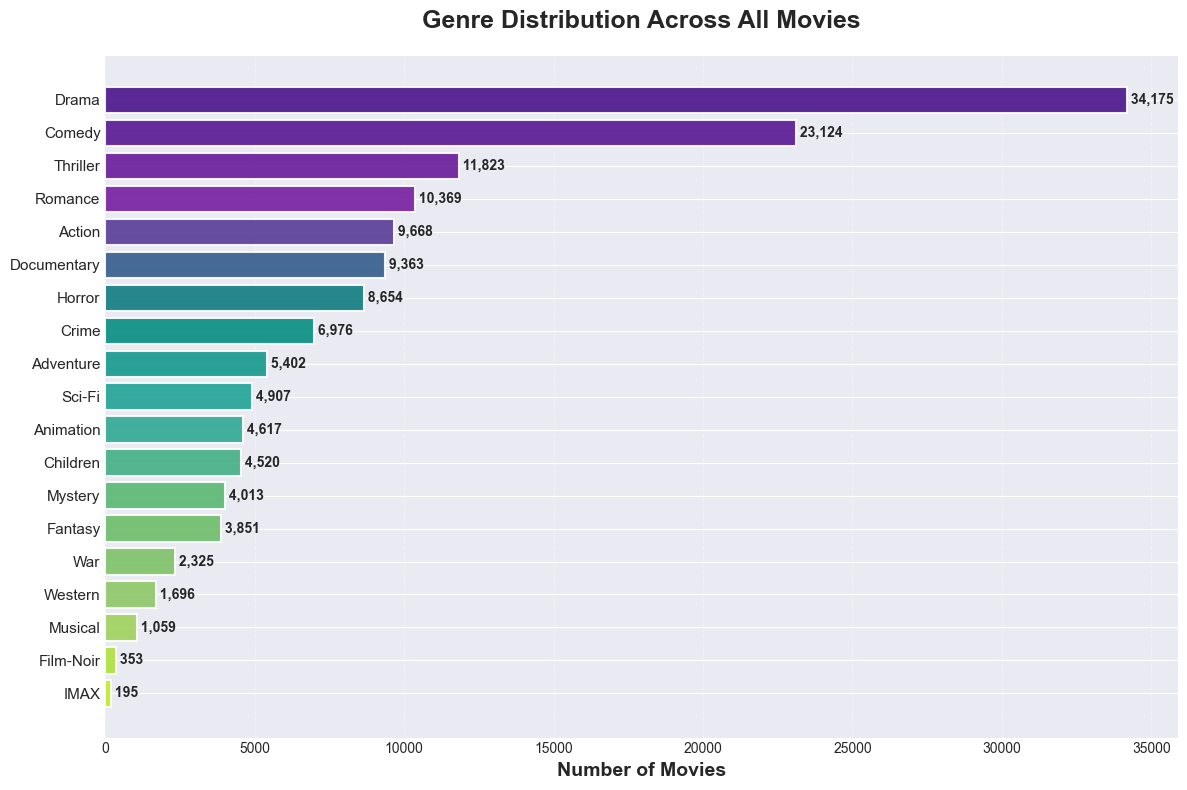

In [ ]:
# 8. GENRE ANALYSIS

movies['genres_list'] = movies['genres'].str.split('|')
all_genres = []
for genres in movies['genres_list']:
    all_genres.extend(genres)

genre_counts = Counter(all_genres)

if '(no genres listed)' in genre_counts:
    del genre_counts['(no genres listed)']

genre_df = pd.DataFrame(genre_counts.most_common(), columns=['Genre', 'Count'])

fig, ax = plt.subplots(figsize=(12, 8))

colors = [cmap_custom(i/len(genre_df)) for i in range(len(genre_df))]
bars = ax.barh(range(len(genre_df)), genre_df['Count'], color=colors,
               edgecolor='white', linewidth=1.5, alpha=0.9)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f' {width:,}',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(range(len(genre_df)))
ax.set_yticklabels(genre_df['Genre'], fontsize=11)
ax.set_xlabel('Number of Movies', fontsize=14, fontweight='bold')
ax.set_title('Genre Distribution Across All Movies', fontsize=18, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('plots/08_genre_analysis.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Indexing Data_Structure

In [ ]:
class IndexingStructure:
  def __init__(self, ratings):
    self.number_of_users = 0
    self.userid_to_idx  = {}
    self.idx_to_userid  = []
    self.data_by_user   = []

    self.number_of_movies = 0
    self.movieid_to_idx = {}
    self.idx_to_movieid = []
    self.data_by_movie  = []

    for rating in ratings:
      if not rating[0] in self.userid_to_idx:
        self.idx_to_userid.append(rating[0])
        self.userid_to_idx[rating[0]] = self.number_of_users
        self.number_of_users += 1
        self.data_by_user.append([])

      if not rating[1] in self.movieid_to_idx:
        self.idx_to_movieid.append(rating[1])
        self.movieid_to_idx[rating[1]] = self.number_of_movies
        self.number_of_movies += 1
        self.data_by_movie.append([])

      self.data_by_user[self.userid_to_idx[rating[0]]].append((self.movieid_to_idx[rating[1]],rating[2].item()))
      self.data_by_movie[self.movieid_to_idx[rating[1]]].append((self.userid_to_idx[rating[0]],rating[2].item()))


  # --------------------------------------------- Query Functions ---------------------------------------------------------- #

  def bin_search(self, array : list, value : int, key = lambda x:x):
    l = 0
    r = len(array)
    while r > l:
      m = (l+r)//2
      if value == key(array[m]):
        return m
      if value > key(array[m]):
        l = m+1
      else:
        r = m
    return -1

  def get_user_ratings(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie[self.movieid_to_idx[movieid]]
    n_ratings = len(movie_ratings)
    return n_ratings, movie_ratings

  def get_ratings(self, userid, movieid):
    if not (userid in self.userid_to_idx and movieid in self.movieid_to_idx):
      return 0
    movie_ratings = self.get_user_ratings(userid)[1]
    idx = self.bin_search(movie_ratings, self.movieid_to_idx[movieid], key = lambda x:x[0])
    return movie_ratings[idx][1]


# ----------------------------------------------- Train/ Test Split ----------------------------------------------------- #

  def split(self, split_ratio):

    self.data_by_user_train  = []
    self.data_by_user_test   = []
    self.data_by_movie_train = []
    self.data_by_movie_test  = []

    for user_ratings in self.data_by_user:
      self.data_by_user_train.append([])
      self.data_by_user_test.append([])

      for rating in user_ratings:
        u = np.random.random()
        if u < split_ratio:
          self.data_by_user_train[-1].append(rating)
        else:
          self.data_by_user_test[-1].append(rating)

    for movie_ratings in self.data_by_movie:
      self.data_by_movie_train.append([])
      self.data_by_movie_test.append([])

    for user_idx, user_ratings in enumerate(self.data_by_user_train):
      for rating in user_ratings:
        self.data_by_movie_train[rating[0]].append((user_idx, rating[1]))


    for user_idx, user_ratings in enumerate(self.data_by_user_test):
      for rating in user_ratings:
        self.data_by_movie_test[rating[0]].append((user_idx, rating[1]))


    self.number_of_users_train = len(self.data_by_user_train)
    self.number_of_movies_train = len(self.data_by_movie_train)
    self.number_of_users_test = len(self.data_by_user_test)
    self.number_of_movies_test = len(self.data_by_movie_test)

    print(f"number of users in train dataset:  {self.number_of_users_train}")
    print(f"number of movies in train dataset: {self.number_of_movies_train}")
    print()
    print(f"number of users in test dataset:  {self.number_of_users_test}")
    print(f"number of movies in test dataset: {self.number_of_movies_test}")
    print(end = '\n')


    ratings_in_train = 0
    for user_ratings in self.data_by_user_train:
      for rating in user_ratings:
        ratings_in_train += 1

    ratings_in_test = 0
    for user_ratings in self.data_by_user_test:
      for rating in user_ratings:
        ratings_in_test += 1

    print(f"number of ratings in train dataset: {ratings_in_train}")
    print(f"number of ratings in test dataset: {ratings_in_test}")
    ratio = ratings_in_train/(ratings_in_train + ratings_in_test)
    print(f"split ratio: {ratio:0.2f}")


  # -------------------------------------------- data_train functions ----------------------------------------------------------- #

  def get_user_ratings_train(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user_train[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings_train(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie_train[self.movieid_to_idx[movieid]]
    n_ratings = len(movie_ratings)
    return n_ratings, movie_ratings


  # -------------------------------------------- data_test functions ----------------------------------------------------------- #

  def get_user_ratings_test(self, userid):
    if not userid in self.userid_to_idx:
      return 0, []
    user_ratings = self.data_by_user_test[self.userid_to_idx[userid]]
    n_ratings = len(user_ratings)
    return n_ratings, user_ratings

  def get_movie_ratings_test(self, movieid):
    if not movieid in self.movieid_to_idx:
      return 0, []
    movie_ratings = self.data_by_movie_test[self.movieid_to_idx[movieid]]
    n_ratings = len(movie_ratings)
    return n_ratings, movie_ratings


## Indexing Initialization

In [ ]:
ratings = np.loadtxt(
    "ratings.csv",
    delimiter=",",
    skiprows=1,
    usecols=(0, 1, 2)
)

print(ratings.shape)

(32000204, 3)


In [ ]:
ratings_matrix = IndexingStructure(ratings)

## Query Functions

In [ ]:
# Query user 1's ratings
n_ratings, user_ratings = ratings_matrix.get_user_ratings(1)
print(f"User 1 rated {n_ratings} movies")
print(user_ratings[:10])

# Query movie 1's ratings
n_ratings, movie_ratings = ratings_matrix.get_movie_ratings(1)
print(f"Movie 1 was rated by {n_ratings} users")
print(movie_ratings[:10])

# Get specific rating
rating = ratings_matrix.get_ratings(1, 17)
print(f"User 1's rating for movie 17: {rating}")

User 1 rated 141 movies
[(0, 4.0), (1, 1.0), (2, 2.0), (3, 5.0), (4, 5.0), (5, 2.0), (6, 1.0), (7, 5.0), (8, 3.0), (9, 5.0)]
Movie 1 was rated by 68997 users
[(9, 2.5), (10, 3.0), (16, 4.0), (18, 3.0), (19, 5.0), (22, 3.0), (23, 4.0), (27, 4.0), (32, 5.0), (33, 4.0)]
User 1's rating for movie 17: 4.0


# Practical 2:

## Train/ Test Split

In [ ]:
ratings_matrix.split(0.9)

number of users in train dataset:  200948
number of movies in train dataset: 84432

number of users in test dataset:  200948
number of movies in test dataset: 84432

number of ratings in train dataset: 28798796
number of ratings in test dataset: 3201408
split ratio: 0.90


## Bias Only Optimization Model

### Training

In [ ]:
user_biases = np.zeros(ratings_matrix.number_of_users)
movie_biases = np.zeros(ratings_matrix.number_of_movies)

lamda = 0.020393
gamma = 0.001924
iterations = 20

# For plotting
loss_history = []
rmse_history = []
rmse_test_history = []

for _ in range(iterations):
  for user_idx in range(ratings_matrix.number_of_users):
    bias = 0
    movie_counter = 0
    userid = ratings_matrix.idx_to_userid[user_idx]
    user_ratings = ratings_matrix.get_user_ratings_train(userid)[1]

    for movie_idx, rating in user_ratings:
      bias += lamda * (rating - movie_biases[movie_idx])
      movie_counter += 1
    if movie_counter > 0:
      bias = bias/(lamda * movie_counter + gamma)
      user_biases[user_idx] = bias


  for movie_idx in range(ratings_matrix.number_of_movies):
    bias = 0
    user_counter = 0
    movieid = ratings_matrix.idx_to_movieid[movie_idx]
    movie_ratings = ratings_matrix.get_movie_ratings_train(movieid)[1]

    for user_idx, rating in movie_ratings:
      bias += lamda * (rating - user_biases[user_idx])
      user_counter += 1
    if user_counter > 0:
      bias = bias/(lamda * user_counter + gamma)
      movie_biases[movie_idx] = bias

  loss_train = 0
  number_of_ratings_train = 0
  for user_idx, user_ratings in enumerate(ratings_matrix.data_by_user_train):
    for rating in user_ratings:
      pred = user_biases[user_idx] + movie_biases[rating[0]]
      r = rating[1]
      loss_train += (r - pred)**2
      number_of_ratings_train += 1
  rmse_train = np.sqrt(loss_train/number_of_ratings_train)

  loss_test = 0
  number_of_ratings_test = 0
  for user_idx, user_ratings in enumerate(ratings_matrix.data_by_user_test):
    for rating in user_ratings:
      pred = user_biases[user_idx] + movie_biases[rating[0]]
      r = rating[1]
      loss_test += (r - pred)**2
      number_of_ratings_test += 1
  rmse_test = np.sqrt(loss_test/number_of_ratings_test)

  print(f"Iteration {_+1}/{iterations}:\n "
      f"Train RMSE = {rmse_train:.4f}, Train Loss = {loss_train:.4f} \n "
      f"Test  RMSE = {rmse_test:.4f}, Test  Loss = {loss_test:.4f}\n")

  loss_history.append(loss_train)
  rmse_history.append(rmse_train)
  rmse_test_history.append(rmse_test)

# Print summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
print(f"Final Test RMSE:  {rmse_test_history[-1]:.4f}")
print(f"Train Improvement: {((rmse_history[0] - rmse_history[-1])/rmse_history[0]*100):.2f}%")
print(f"Test Improvement:  {((rmse_test_history[0] - rmse_test_history[-1])/rmse_test_history[0]*100):.2f}%")
print(f"Generalization Gap: {(rmse_test_history[-1] - rmse_history[-1]):.4f}")
print("="*60)


Iteration 1/20:
 Train RMSE = 0.8616, Train Loss = 21380270.3233 
 Test  RMSE = 0.8705, Test  Loss = 2426009.4498

Iteration 2/20:
 Train RMSE = 0.8470, Train Loss = 20659798.7633 
 Test  RMSE = 0.8560, Test  Loss = 2345560.6122

Iteration 3/20:
 Train RMSE = 0.8463, Train Loss = 20625083.4487 
 Test  RMSE = 0.8553, Test  Loss = 2341863.9924

Iteration 4/20:
 Train RMSE = 0.8462, Train Loss = 20622813.6920 
 Test  RMSE = 0.8552, Test  Loss = 2341654.5601

Iteration 5/20:
 Train RMSE = 0.8462, Train Loss = 20622550.6887 
 Test  RMSE = 0.8552, Test  Loss = 2341629.4599

Iteration 6/20:
 Train RMSE = 0.8462, Train Loss = 20622490.0577 
 Test  RMSE = 0.8552, Test  Loss = 2341618.2689

Iteration 7/20:
 Train RMSE = 0.8462, Train Loss = 20622469.2987 
 Test  RMSE = 0.8552, Test  Loss = 2341610.2583

Iteration 8/20:
 Train RMSE = 0.8462, Train Loss = 20622460.6016 
 Test  RMSE = 0.8552, Test  Loss = 2341603.7612

Iteration 9/20:
 Train RMSE = 0.8462, Train Loss = 20622456.3541 
 Test  RMSE = 

### Visualization

Saved: plots/bias_only_loss.pdf/png


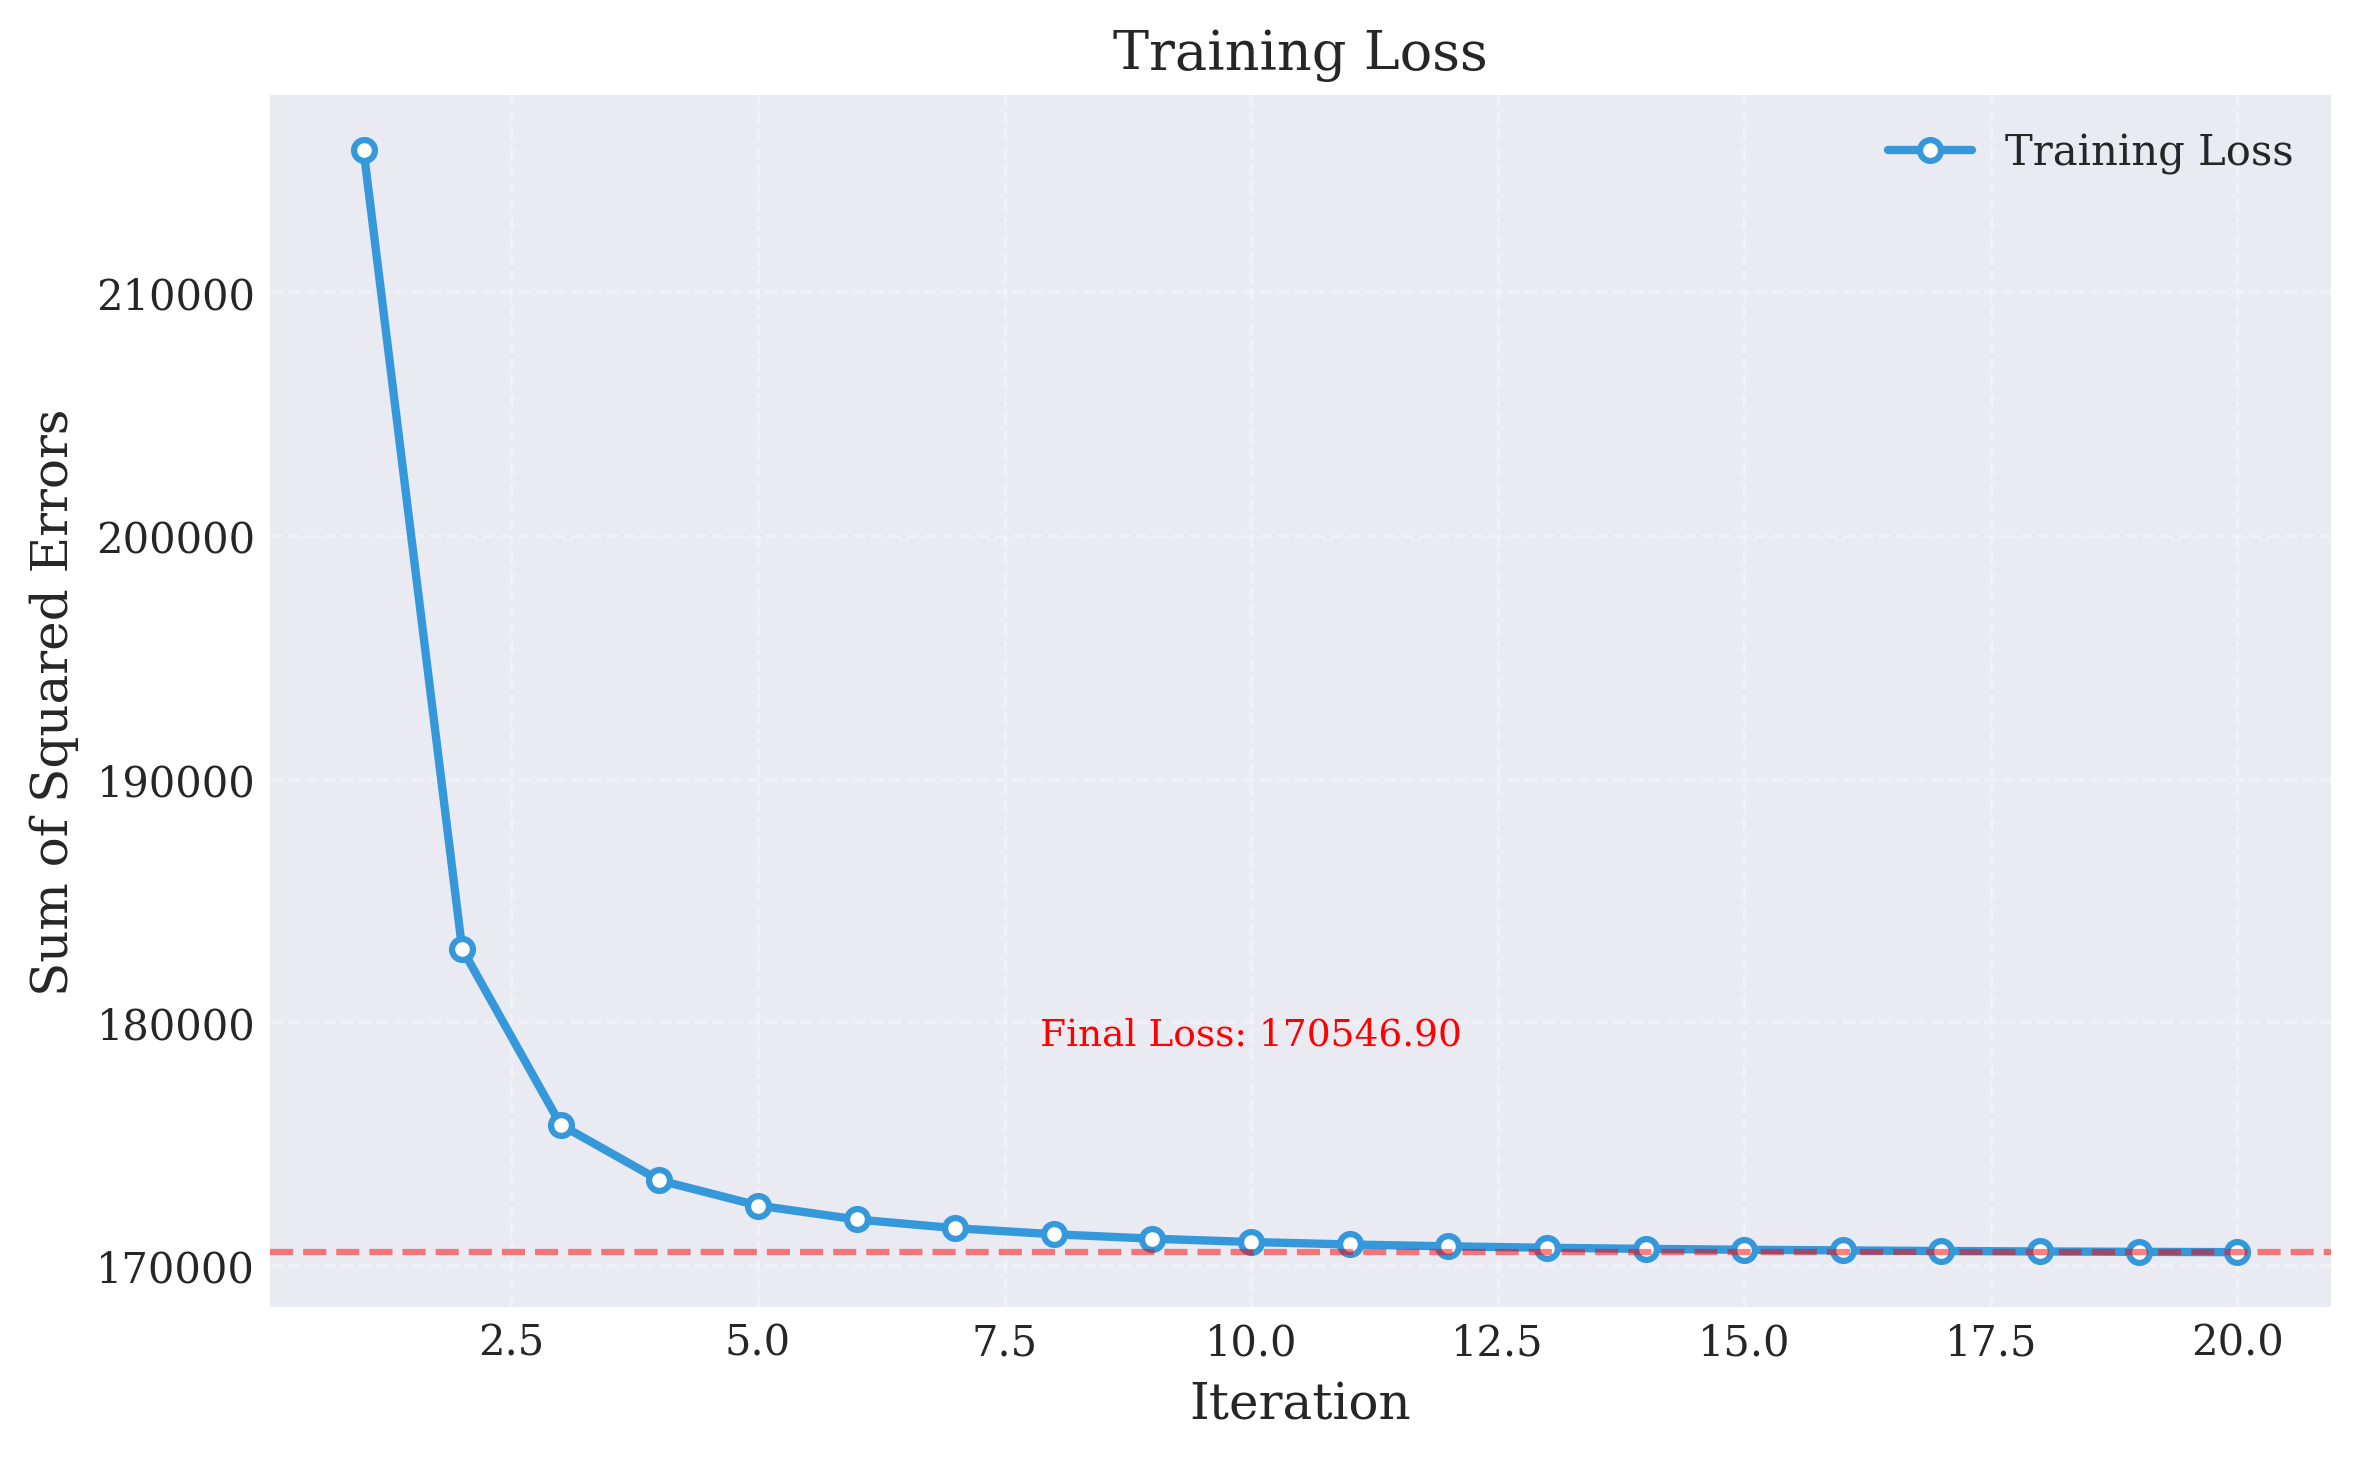

Saved: plots/bias_only_rmse.pdf/png


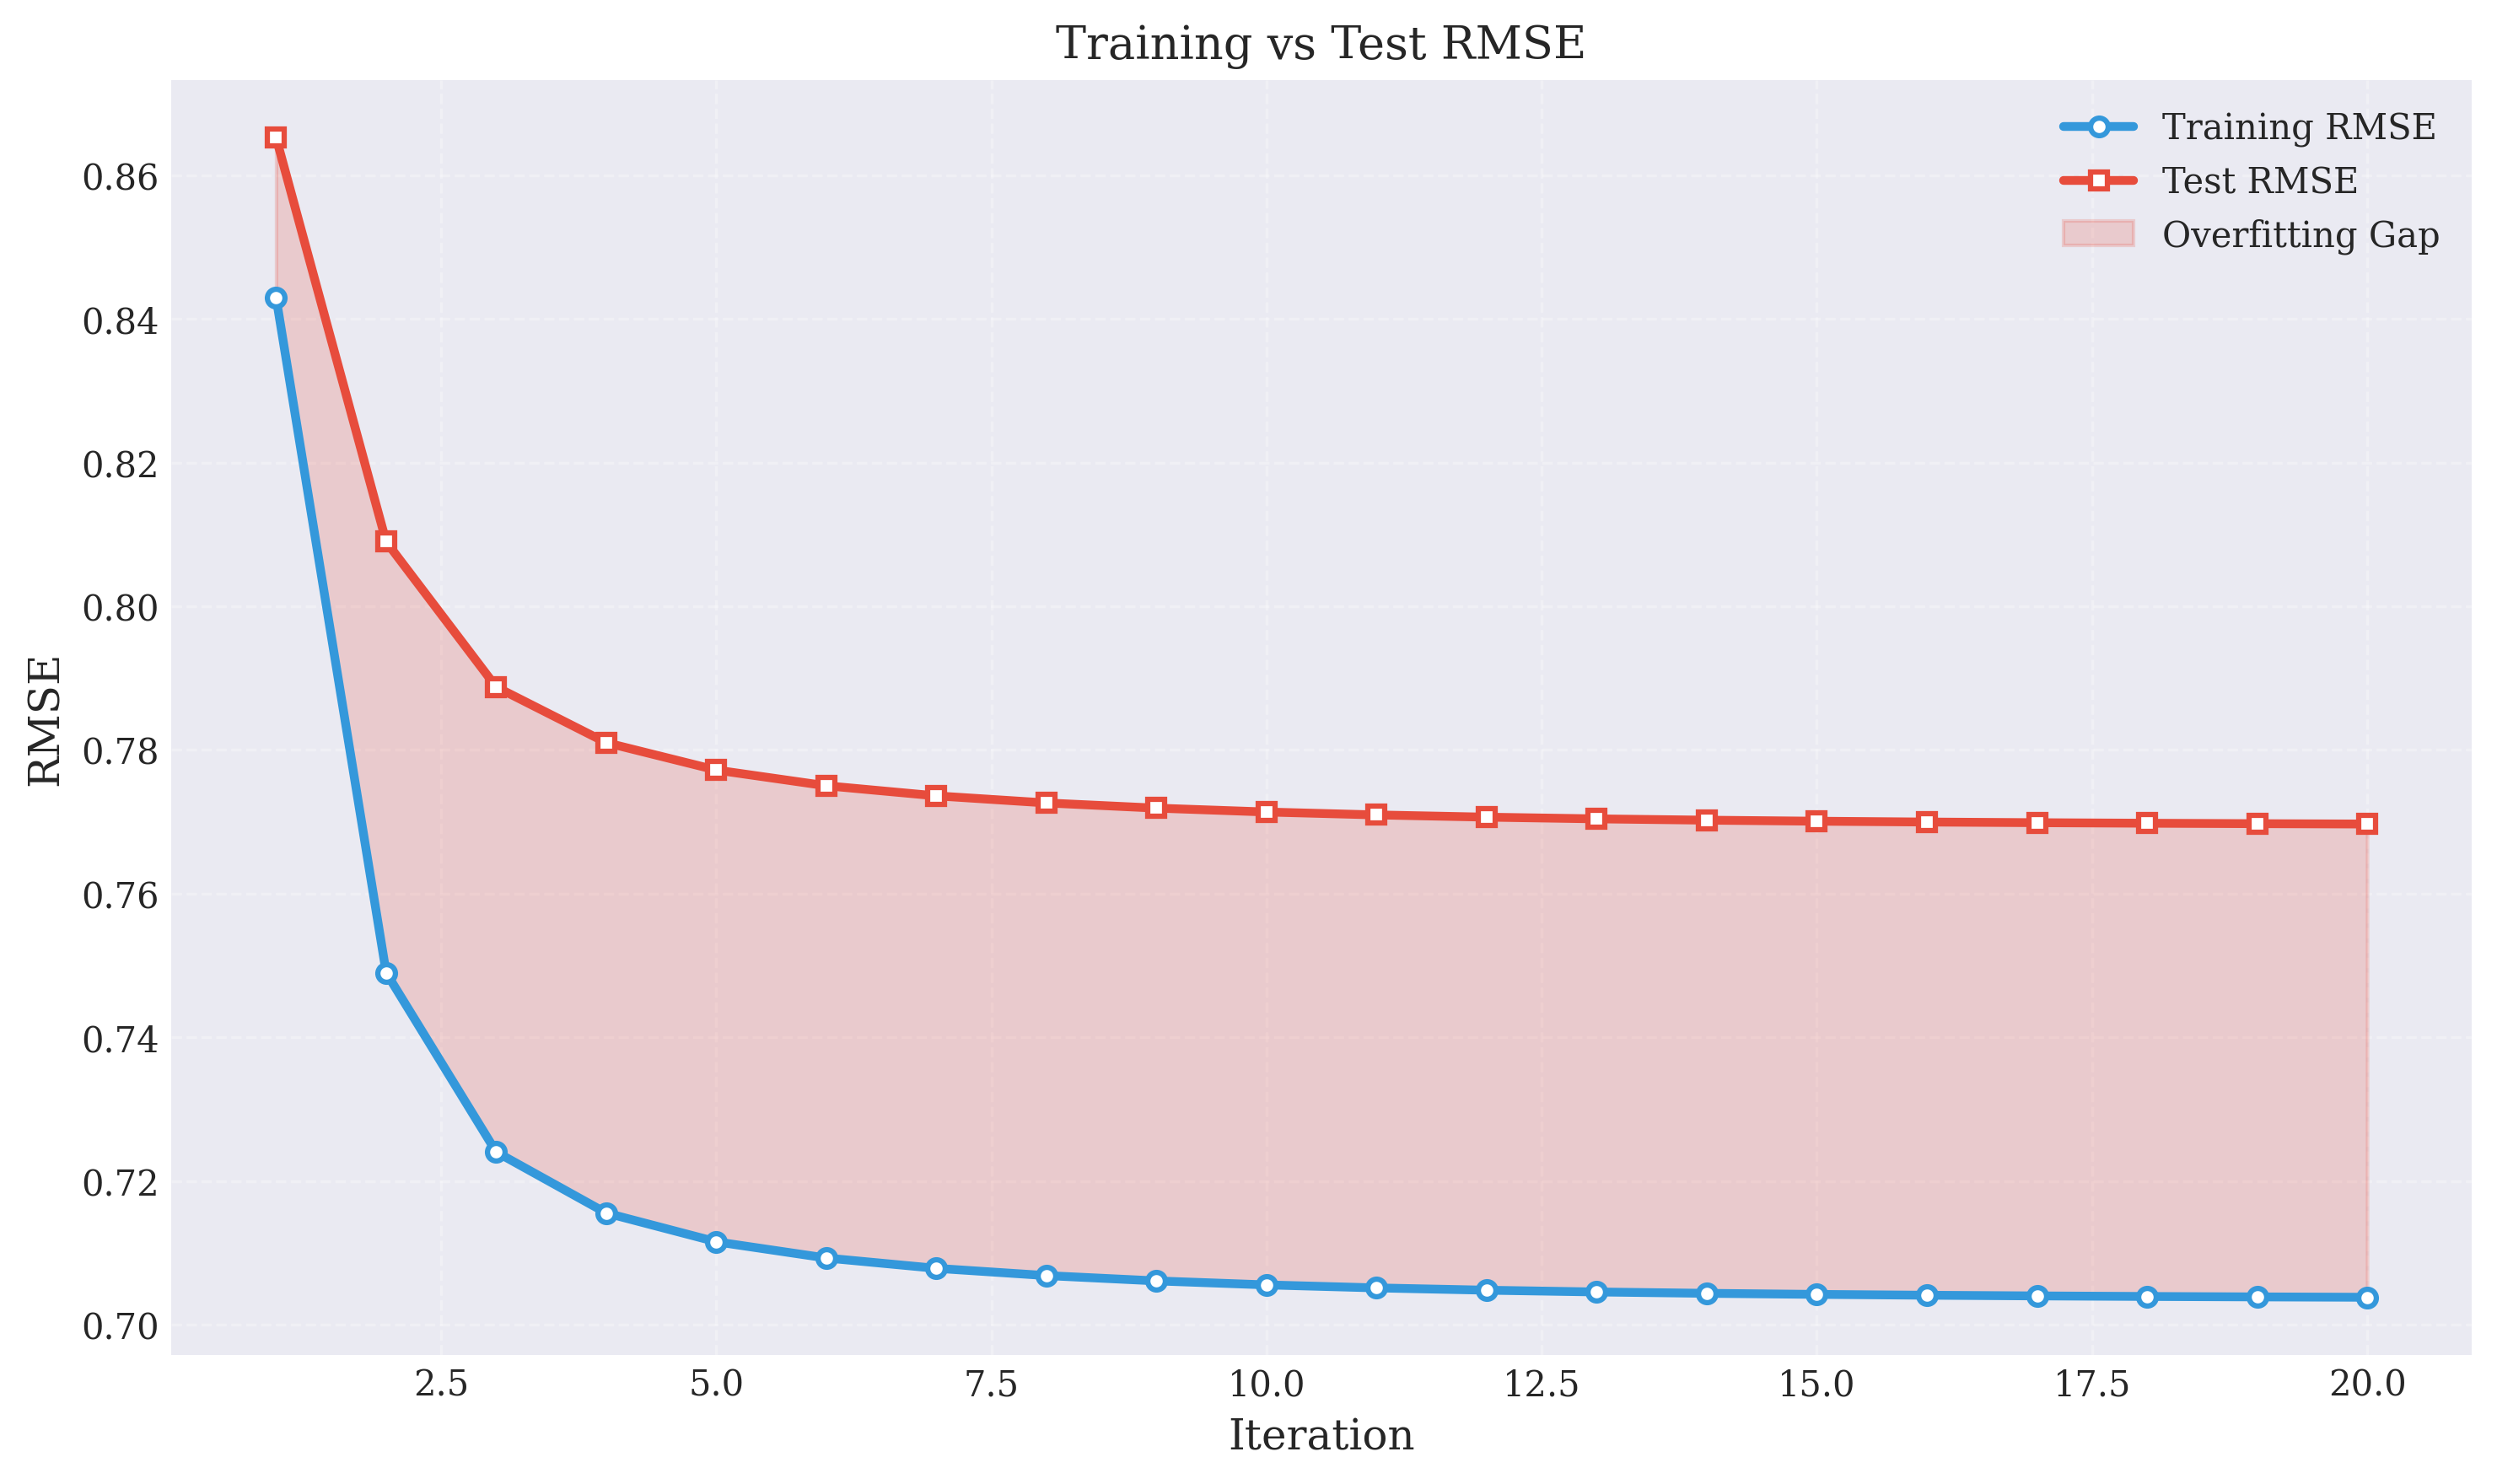


TRAINING SUMMARY
Total Iterations: 20

Final Training RMSE: 0.703800
Final Test RMSE: 0.769677
Overfitting Gap: 0.065877 (9.36%)

Best Test RMSE: 0.769677 (at iteration 20)
Improvement from first to last iteration: 0.095547


In [ ]:
# Set publication-quality style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'lines.linewidth': 2,
})

# FIGURE 1: Training Loss
fig, ax = plt.subplots(figsize=(8, 5))

iterations = np.arange(1, len(loss_history) + 1)
ax.plot(iterations, loss_history, marker='o', markersize=5,
        color='#3498db', linewidth=2, markerfacecolor='white',
        markeredgewidth=1.5, label='Training Loss')

ax.set_xlabel('Iteration')
ax.set_ylabel('Sum of Squared Errors')
ax.set_title('Training Loss')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()

# Add convergence annotation if loss stabilizes
if len(loss_history) > 5:
    final_loss = loss_history[-1]
    ax.axhline(final_loss, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax.text(len(loss_history) * 0.5, final_loss * 1.05,
            f'Final Loss: {final_loss:.2f}',
            ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.savefig('plots/bias_only_loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/bias_only_loss.png', format='png', dpi=300, bbox_inches='tight')
print("Saved: plots/bias_only_loss.pdf/png")
plt.show()
plt.close()

# FIGURE 2: Train vs Test RMSE with Overfitting Gap
fig, ax = plt.subplots(figsize=(10, 6))

iterations = np.arange(1, len(rmse_history) + 1)

# Plot training and test RMSE
train_line = ax.plot(iterations, rmse_history, marker='o', markersize=5,
                     color='#3498db', linewidth=2.5, markerfacecolor='white',
                     markeredgewidth=1.5, label='Training RMSE')

test_line = ax.plot(iterations, rmse_test_history, marker='s', markersize=5,
                    color='#e74c3c', linewidth=2.5, markerfacecolor='white',
                    markeredgewidth=1.5, label='Test RMSE')

# Fill the overfitting gap
ax.fill_between(iterations, rmse_history, rmse_test_history,
                where=(np.array(rmse_test_history) >= np.array(rmse_history)),
                alpha=0.2, color='#e74c3c', label='Overfitting Gap')

# Calculate and display final gap
final_train_rmse = rmse_history[-1]
final_test_rmse = rmse_test_history[-1]
gap = final_test_rmse - final_train_rmse
gap_percentage = (gap / final_train_rmse) * 100

ax.set_xlabel('Iteration')
ax.set_ylabel('RMSE')
ax.set_title('Training vs Test RMSE')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('plots/bias_only_rmse.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/bias_only_rmse.png', format='png', dpi=300, bbox_inches='tight')
print("Saved: plots/bias_only_rmse.pdf/png")
plt.show()
plt.close()

# Print Summary Statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total Iterations: {len(rmse_history)}")
print(f"\nFinal Training RMSE: {final_train_rmse:.6f}")
print(f"Final Test RMSE: {final_test_rmse:.6f}")
print(f"Overfitting Gap: {gap:.6f} ({gap_percentage:.2f}%)")
print(f"\nBest Test RMSE: {best_test_rmse:.6f} (at iteration {best_test_idx + 1})")
print(f"Improvement from first to last iteration: {rmse_test_history[0] - final_test_rmse:.6f}")
print("="*60)

# Practical 3:

##  Matrix Factorization with ALS Model

### Loss Function

In [ ]:
def compute_loss(ratings_matrix, U, V, b_u, b_m, lamda, gamma_u, gamma_v, gamma_b, train=True):

    if train:
        data_by_user = ratings_matrix.data_by_user_train
    else:
        data_by_user = ratings_matrix.data_by_user_test

    # 1. Prediction error term
    squared_error = 0.0
    n_ratings = 0

    for user_idx, user_ratings in enumerate(data_by_user):
        for movie_idx, rating in user_ratings:
            # Prediction: u_u^T * v_m + b_u + b_m
            pred = np.dot(U[:,user_idx], V[:,movie_idx]) + b_u[user_idx] + b_m[movie_idx]

            # Squared error
            error = rating - pred
            squared_error += error ** 2
            n_ratings += 1


    # 2. Regularization terms
    # User embedding regularization
    user_embedding_reg = np.sum(U ** 2)

    # Movie embedding regularization
    movie_embedding_reg = np.sum(V ** 2)

    # Bias regularization
    user_bias_reg = np.sum(b_u ** 2)
    movie_bias_reg = np.sum(b_m ** 2)

    # 3. Full loss
    loss =(lamda / 2) * squared_error + \
          (gamma_u / 2) * user_embedding_reg + \
          (gamma_v / 2) * movie_embedding_reg + \
          (gamma_b / 2) * (user_bias_reg + movie_bias_reg)


    # 4. RMSE
    rmse = np.sqrt(squared_error / n_ratings) if n_ratings > 0 else 0.0

    return loss, rmse


### Training

In [ ]:
user_biases = np.zeros((ratings_matrix.number_of_users))
movie_biases = np.zeros((ratings_matrix.number_of_movies))

k = 20
user_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_users))
movie_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_movies))

# Hyperparameters

lamda = 0.02039307537342147
gamma_u = 0.8587551700375037
gamma_v = 0.8034116286188123
gamma_b = 0.00192377578961482
iterations = 20

# For plotting
loss_history = []
rmse_history = []
rmse_test_history = []

for _ in range(iterations):
  for user_idx in range(ratings_matrix.number_of_users):
    bias = 0
    userid = ratings_matrix.idx_to_userid[user_idx]
    n_ratings, user_ratings = ratings_matrix.get_user_ratings_train(userid)
    if n_ratings == 0:
            continue
    # user bias update
    for movie_idx, rating in user_ratings:
      bias += lamda * (rating - movie_biases[movie_idx]- np.dot(user_embeddings[:,user_idx], movie_embeddings[:,movie_idx]))
    bias = bias/(lamda * n_ratings + gamma_b)
    user_biases[user_idx] = bias

    # user embedding update
    first_term = gamma_u * np.eye(movie_embeddings.shape[0])
    second_term = np.zeros(movie_embeddings.shape[0])
    for movie_idx, rating in user_ratings:
      v_n = movie_embeddings[:,movie_idx]
      first_term += lamda * np.outer(v_n, v_n)
      second_term += lamda * v_n * (rating - user_biases[user_idx] - movie_biases[movie_idx])
    # solving for u_m
    try:
      user_embeddings[:,user_idx] = np.linalg.solve(first_term, second_term)
    except np.linalg.LinAlgError:
      user_embeddings[:,user_idx] = np.linalg.lstsq(first_term, second_term, rcond=None)[0]

  for movie_idx in range(ratings_matrix.number_of_movies):
    bias = 0
    movieid = ratings_matrix.idx_to_movieid[movie_idx]
    m_ratings, movie_ratings = ratings_matrix.get_movie_ratings_train(movieid)
    if m_ratings == 0:
            continue

    for user_idx, rating in movie_ratings:
      bias += lamda * (rating - user_biases[user_idx]- np.dot(user_embeddings[:,user_idx], movie_embeddings[:,movie_idx]))
    bias = bias/(lamda * m_ratings + gamma_b)
    movie_biases[movie_idx] = bias

    first_term = gamma_v * np.eye(user_embeddings.shape[0])
    second_term = np.zeros(user_embeddings.shape[0])
    for user_idx, rating in movie_ratings:
      u_m = user_embeddings[:,user_idx]
      second_term += lamda * (u_m * (rating - user_biases[user_idx] - movie_biases[movie_idx]))
      first_term += lamda * np.outer(u_m, u_m)
    # solving for v_n
    try:
      movie_embeddings[:,movie_idx] = np.linalg.solve(first_term, second_term)
    except np.linalg.LinAlgError:
      movie_embeddings[:,movie_idx] = np.linalg.lstsq(first_term, second_term, rcond=None)[0]



  loss_train, rmse_train = compute_loss(ratings_matrix, user_embeddings, movie_embeddings, user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=True)
  loss_test, rmse_test = compute_loss(ratings_matrix, user_embeddings, movie_embeddings, user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=False)

  print(f"Iteration {_+1}/{iterations}:\n "
      f"Train RMSE = {rmse_train:.4f}, Train Loss = {loss_train:.4f} \n "
      f"Test  RMSE = {rmse_test:.4f}, Test  Loss = {loss_test:.4f}\n")

  loss_history.append(loss_train)
  rmse_history.append(rmse_train)
  rmse_test_history.append(rmse_test)

# Print summary statistics
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
print(f"Final Test RMSE:  {rmse_test_history[-1]:.4f}")
print(f"Train Improvement: {((rmse_history[0] - rmse_history[-1])/rmse_history[0]*100):.2f}%")
print(f"Test Improvement:  {((rmse_test_history[0] - rmse_test_history[-1])/rmse_test_history[0]*100):.2f}%")
print(f"Generalization Gap: {(rmse_test_history[-1] - rmse_history[-1]):.4f}")
print("="*60)


Iteration 1/20:
 Train RMSE = 0.8430, Train Loss = 215859.1062 
 Test  RMSE = 0.8652, Test  Loss = 31639.9409

Iteration 2/20:
 Train RMSE = 0.7490, Train Loss = 183009.6053 
 Test  RMSE = 0.8090, Test  Loss = 39645.7377

Iteration 3/20:
 Train RMSE = 0.7240, Train Loss = 175781.0163 
 Test  RMSE = 0.7888, Test  Loss = 42156.8397

Iteration 4/20:
 Train RMSE = 0.7155, Train Loss = 173499.9633 
 Test  RMSE = 0.7810, Test  Loss = 43068.7189

Iteration 5/20:
 Train RMSE = 0.7115, Train Loss = 172462.8172 
 Test  RMSE = 0.7772, Test  Loss = 43517.7588

Iteration 6/20:
 Train RMSE = 0.7093, Train Loss = 171891.9014 
 Test  RMSE = 0.7750, Test  Loss = 43776.9618

Iteration 7/20:
 Train RMSE = 0.7078, Train Loss = 171532.3082 
 Test  RMSE = 0.7736, Test  Loss = 43945.3210

Iteration 8/20:
 Train RMSE = 0.7068, Train Loss = 171282.9521 
 Test  RMSE = 0.7726, Test  Loss = 44064.4747

Iteration 9/20:
 Train RMSE = 0.7061, Train Loss = 171100.7935 
 Test  RMSE = 0.7719, Test  Loss = 44153.0711

I

### Visualization

Saved: plots/embeddings_loss.pdf/png


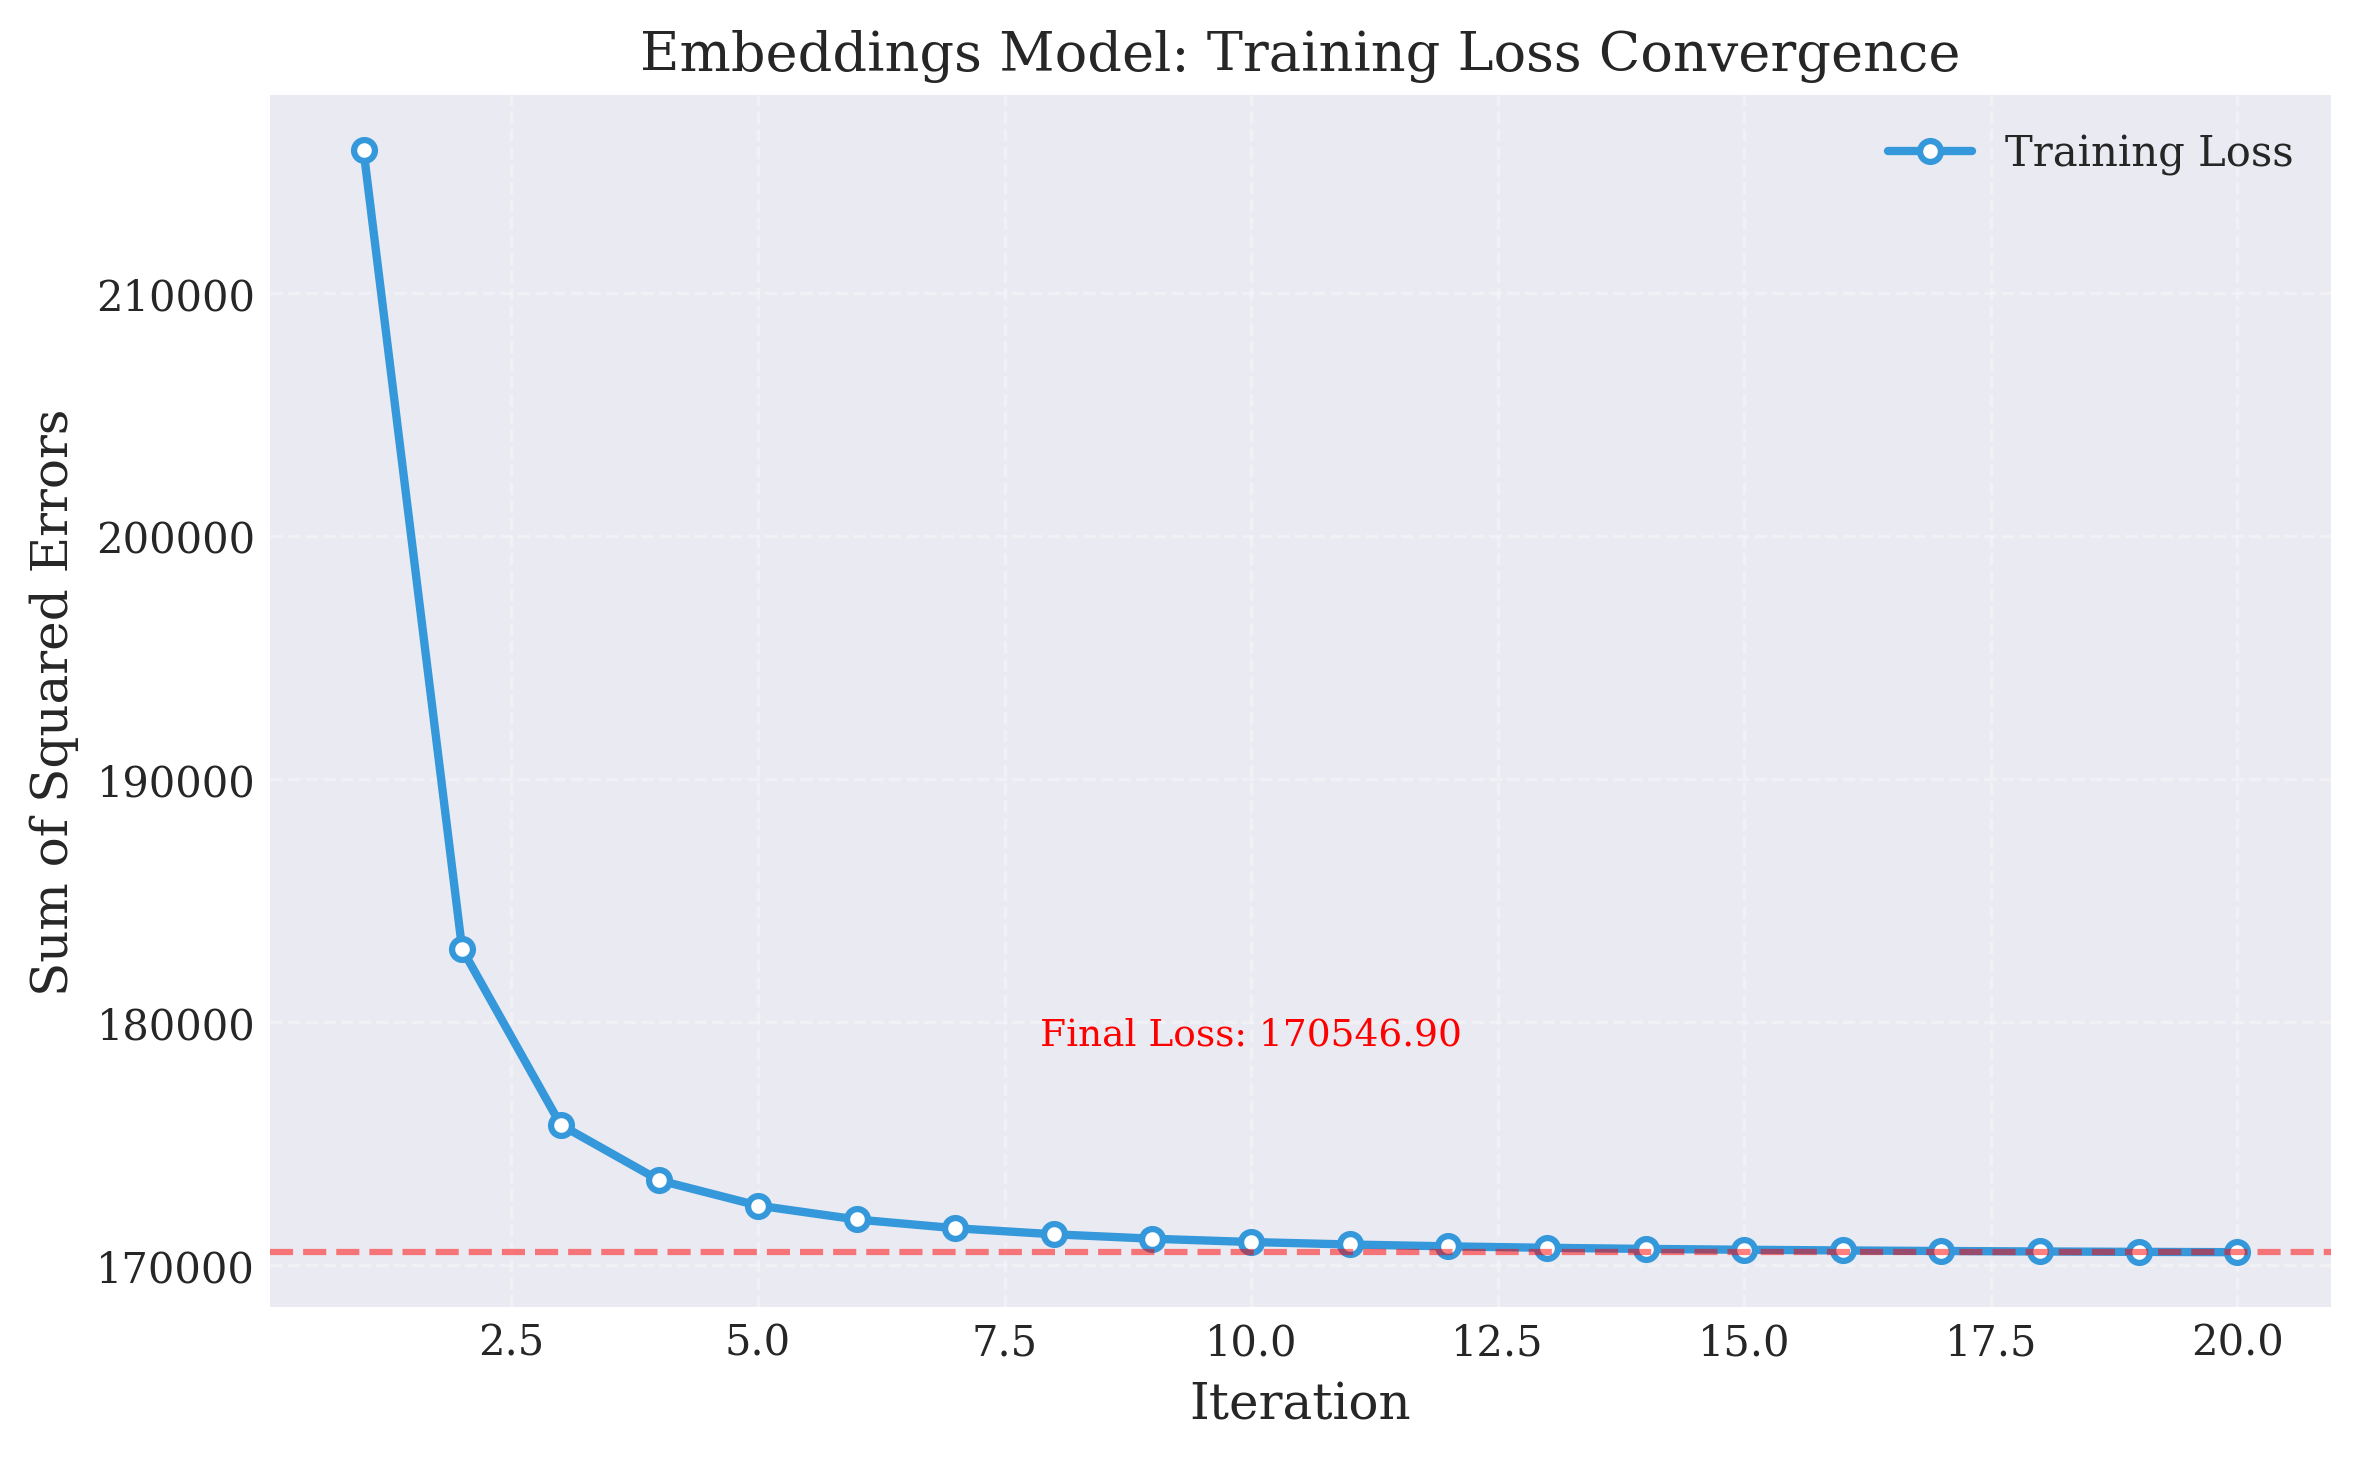

Saved: plots/embeddings_rmse.pdf/png


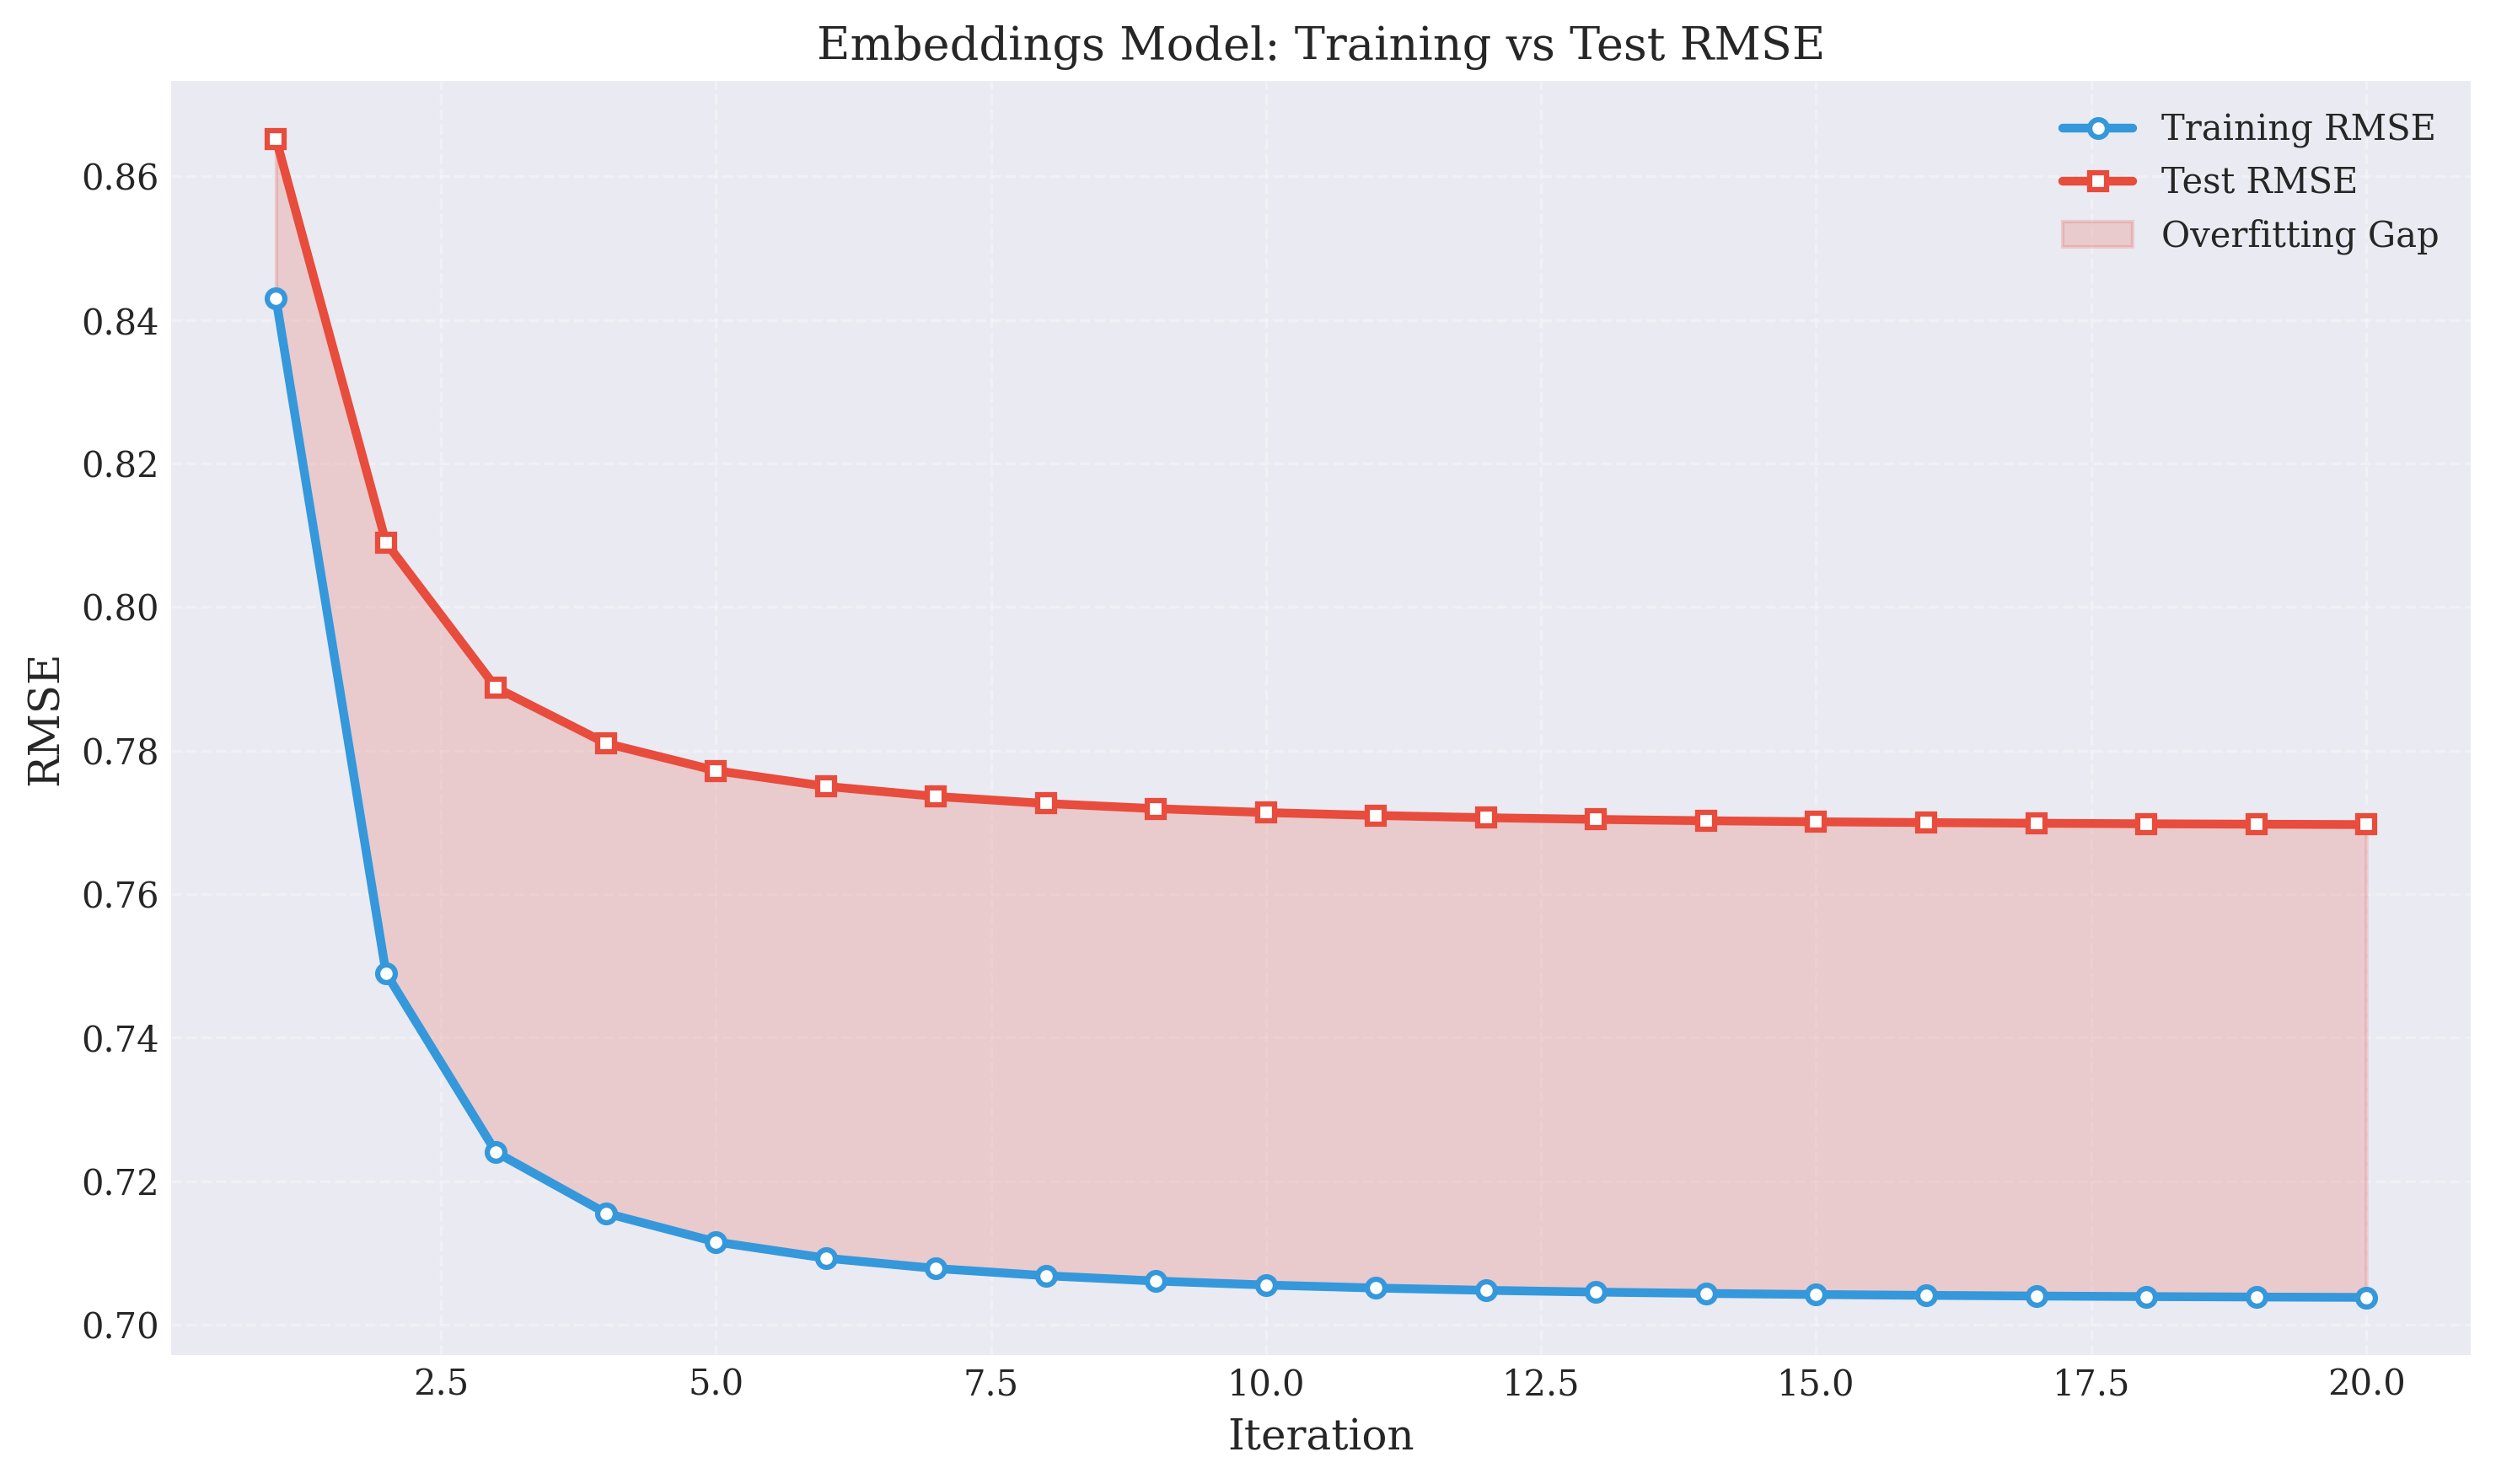


EMBEDDINGS MODEL: TRAINING SUMMARY
Total Iterations: 20

Final Training RMSE: 0.703800
Final Test RMSE: 0.769677
Overfitting Gap: 0.065877 (9.36%)

Best Test RMSE: 0.769677 (at iteration 20)
Improvement from first to last iteration: 0.095547
Average improvement per iteration: 0.004777


In [ ]:
# Set publication-quality style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'lines.linewidth': 2,
})

# FIGURE 1: Training Loss

fig, ax = plt.subplots(figsize=(8, 5))

iterations = np.arange(1, len(loss_history) + 1)
ax.plot(iterations, loss_history, marker='o', markersize=5,
        color='#3498db', linewidth=2, markerfacecolor='white',
        markeredgewidth=1.5, label='Training Loss')

ax.set_xlabel('Iteration')
ax.set_ylabel('Sum of Squared Errors')
ax.set_title('Embeddings Model: Training Loss Convergence')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend()

# Add convergence annotation if loss stabilizes
if len(loss_history) > 5:
    final_loss = loss_history[-1]
    ax.axhline(final_loss, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax.text(len(loss_history) * 0.5, final_loss * 1.05,
            f'Final Loss: {final_loss:.2f}',
            ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.savefig('plots/embeddings_loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/embeddings_loss.png', format='png', dpi=300, bbox_inches='tight')
print("Saved: plots/embeddings_loss.pdf/png")
plt.show()
plt.close()

# FIGURE 2: Train vs Test RMSE with Overfitting Gap
fig, ax = plt.subplots(figsize=(10, 6))

iterations = np.arange(1, len(rmse_history) + 1)

# Plot training and test RMSE
train_line = ax.plot(iterations, rmse_history, marker='o', markersize=5,
                     color='#3498db', linewidth=2.5, markerfacecolor='white',
                     markeredgewidth=1.5, label='Training RMSE')

test_line = ax.plot(iterations, rmse_test_history, marker='s', markersize=5,
                    color='#e74c3c', linewidth=2.5, markerfacecolor='white',
                    markeredgewidth=1.5, label='Test RMSE')

# Fill the overfitting gap
ax.fill_between(iterations, rmse_history, rmse_test_history,
                where=(np.array(rmse_test_history) >= np.array(rmse_history)),
                alpha=0.2, color='#e74c3c', label='Overfitting Gap')


ax.set_xlabel('Iteration')
ax.set_ylabel('RMSE')
ax.set_title('Embeddings Model: Training vs Test RMSE')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('plots/embeddings_rmse.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/embeddings_rmse.png', format='png', dpi=300, bbox_inches='tight')
print("Saved: plots/embeddings_rmse.pdf/png")
plt.show()
plt.close()

# Print Summary Statistics
print("\n" + "="*60)
print("EMBEDDINGS MODEL: TRAINING SUMMARY")
print("="*60)
print(f"Total Iterations: {len(rmse_history)}")
print(f"\nFinal Training RMSE: {final_train_rmse:.6f}")
print(f"Final Test RMSE: {final_test_rmse:.6f}")
print(f"Overfitting Gap: {gap:.6f} ({gap_percentage:.2f}%)")
print(f"\nBest Test RMSE: {best_test_rmse:.6f} (at iteration {best_test_idx + 1})")
print(f"Improvement from first to last iteration: {rmse_test_history[0] - final_test_rmse:.6f}")

# Calculate average improvement per iteration
avg_improvement = (rmse_test_history[0] - final_test_rmse) / len(rmse_test_history)
print(f"Average improvement per iteration: {avg_improvement:.6f}")

print("="*60)

# Practical 4:

## Qualitative Evaluation (Dummy User)

In [ ]:
df2 = pd.read_csv('movies.csv')
df2.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [ ]:
def dummy_user_train(dummy_user_ratings, movie_embeddings, movie_biases, lamda, gamma_u, gamma_b, k = 10, iterations=10):
    dummy_user_embedding = np.random.normal(0, 0.1, size=(k,))
    dummy_bias = 0
    n_ratings = len(dummy_user_ratings)

    for _ in range(iterations):
        # Update bias in each iteration
        bias_sum = 0
        for movie_idx, rating in dummy_user_ratings:
            pred = movie_biases[movie_idx] + np.dot(dummy_user_embedding, movie_embeddings[:, movie_idx])
            bias_sum += lamda * (rating - pred)
        dummy_bias = bias_sum / (lamda * n_ratings + gamma_b)

        # Update embedding
        first_term = gamma_u * np.eye(k)
        second_term = np.zeros(k)

        for movie_idx, rating in dummy_user_ratings:
            v_n = movie_embeddings[:, movie_idx]
            first_term += lamda * np.outer(v_n, v_n)
            second_term += lamda * v_n * (rating - dummy_bias - movie_biases[movie_idx])

        try:
            dummy_user_embedding = np.linalg.solve(first_term, second_term)
        except np.linalg.LinAlgError:
            dummy_user_embedding = np.linalg.lstsq(first_term, second_term, rcond=None)[0]

    return dummy_user_embedding, dummy_bias

In [ ]:
def dummy_user_recommendation(dummy_user_embedding, movie_embeddings,dummy_bias, movie_biases):
  score = np.zeros(movie_embeddings.shape[1])
  for movie_idx in range(movie_embeddings.shape[1]):
    n_ratings = ratings_matrix.get_movie_ratings(movie_idx)[0]
    # Calculate score
    if n_ratings < 100:
      score[movie_idx] = 0
    else:
      score[movie_idx] = (np.dot(dummy_user_embedding, movie_embeddings[:, movie_idx]) + movie_biases[movie_idx]* 0.05)

  ranked_items =  np.argsort(score)[::-1]

  return score, ranked_items

In [ ]:
dummy_movie_ids = [4896]
dummy_ratings = [5.0]
dummy_movie_idx = []
dummy_user_ratings = []
n_rec = 20

for id, rating in zip(dummy_movie_ids, dummy_ratings):
    mov_idx = ratings_matrix.movieid_to_idx[id]
    dummy_movie_idx.append(mov_idx)
    dummy_user_ratings.append((mov_idx, rating))

dummy_user_embidding, dummy_bias = dummy_user_train(dummy_user_ratings,
                                        movie_embeddings,
                                        movie_biases,
                                        lamda = lamda,
                                        gamma_u = gamma_u,
                                        gamma_b = gamma_b,
                                        k = k,
                                        iterations = 10
)
score, ranked_items = dummy_user_recommendation(dummy_user_embidding, movie_embeddings, dummy_bias, movie_biases)
# print(ranked_items[10:50], score[10:50], sep = '\n')


top_recommendations = []
# Filter out movies the user has already rated
for i in range(len(ranked_items)):
    if ranked_items[i] not in dummy_movie_idx:
        top_recommendations.append(ranked_items[i])
    if len(top_recommendations) >= n_rec:
        break


for i in range(len(top_recommendations)):
    recommendation_id = ratings_matrix.idx_to_movieid[top_recommendations[i]]
    row = df2[df2['movieId'] == recommendation_id][['title','genres']].values[0]
    print(*list(row))






Harry Potter and the Prisoner of Azkaban (2004) Adventure|Fantasy|IMAX
Harry Potter and the Chamber of Secrets (2002) Adventure|Fantasy
Harry Potter and the Half-Blood Prince (2009) Adventure|Fantasy|Mystery|Romance|IMAX
Harry Potter and the Deathly Hallows: Part 2 (2011) Action|Adventure|Drama|Fantasy|Mystery|IMAX
Harry Potter and the Deathly Hallows: Part 1 (2010) Action|Adventure|Fantasy|IMAX
Star Wars: Episode I - The Phantom Menace (1999) Action|Adventure|Sci-Fi
Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
O Brother, Where Art Thou? (2000) Adventure|Comedy|Crime
Fargo (1996) Comedy|Crime|Drama|Thriller
Babe (1995) Children|Drama
Pirates of the Caribbean: The Curse of the Black Pearl (2003) Action|Adventure|Comedy|Fantasy
Princess Bride, The (19

In [ ]:
print("="*60)
print("DEBUGGING DUMMY USER")
print("="*60)

# Check the rated movies
print("\nRated Movies:")
for movie_id in dummy_movie_ids:
    row = df2[df2['movieId'] == movie_id][['title','genres']].values[0]
    print(f"  MovieID {movie_id}: {row[0]} ({row[1]})")

# Check embedding magnitude
print(f"\nDummy user embedding norm: {np.linalg.norm(dummy_user_embidding):.4f}")
print(f"Dummy user bias: {dummy_bias:.4f}")

# Check score distribution
print(f"\nScore statistics:")
print(f"  Min score: {score.min():.4f}")
print(f"  Max score: {score.max():.4f}")
print(f"  Mean score: {score.mean():.4f}")
print(f"  Std score: {score.std():.4f}")

# Check rated movies' scores
print(f"\nScores for YOUR rated movies:")
for movie_idx in dummy_movie_idx:
    movie_id = ratings_matrix.idx_to_movieid[movie_idx]
    row = df2[df2['movieId'] == movie_id][['title']].values[0][0]
    print(f"  {row}: {score[movie_idx]:.4f}")

# Check top recommendations with scores
print(f"\nTop 10 Recommendations with scores:")
for i in range(n_rec):
    rec_idx = top_recommendations[i]
    rec_id = ratings_matrix.idx_to_movieid[rec_idx]
    row = df2[df2['movieId'] == rec_id][['title','genres']].values[0]
    print(f"  {i+1}. Score: {score[rec_idx]:.4f} - {row[0]} ({row[1]})")

DEBUGGING DUMMY USER

Rated Movies:
  MovieID 4896: Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) (Adventure|Children|Fantasy)

Dummy user embedding norm: 0.0636
Dummy user bias: 4.1045

Score statistics:
  Min score: -0.1902
  Max score: 0.4419
  Mean score: -0.0007
  Std score: 0.0113

Scores for YOUR rated movies:
  Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001): 0.4419

Top 10 Recommendations with scores:
  1. Score: 0.4328 - Harry Potter and the Prisoner of Azkaban (2004) (Adventure|Fantasy|IMAX)
  2. Score: 0.4253 - Harry Potter and the Chamber of Secrets (2002) (Adventure|Fantasy)
  3. Score: 0.4149 - Harry Potter and the Half-Blood Prince (2009) (Adventure|Fantasy|Mystery|Romance|IMAX)
  4. Score: 0.4090 - Harry Potter and the Deathly Hallows: Part 2 (2011) (Action|Adventure|Drama|Fantasy|Mystery|IMAX)
  5. Score: 0.4087 - Harry Potter and the Deathly Hallows: Part 1 (2010) (Action|

## Polarizing Movies

### Most Polarizing

In [ ]:
n_polorizing_movies = 10
norms = []
for movie_idx in range(movie_embeddings.shape[1]):
  movie = np.linalg.norm(movie_embeddings[:,movie_idx])
  norms.append(movie)

# Get indices sorted by norm (descending = Most polarizing first)
movies_idx_sorted_by_norm = np.argsort(norms)[::-1]
polorizing_movies_id = [ratings_matrix.idx_to_movieid[idx] for idx in movies_idx_sorted_by_norm[:n_polorizing_movies]]

print("Most POLARIZING MOVIES (Highest embedding norms):")
print("-" * 80)

for movie_id in polorizing_movies_id:
  row = df2[df2['movieId'] == movie_id][['title','genres']].values[0]
  print(*list(row))

Most POLARIZING MOVIES (Highest embedding norms):
--------------------------------------------------------------------------------
Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
Lord of the Rings: The Return of the King, The (2003) Action|Adventure|Drama|Fantasy
Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
Dumb & Dumber (Dumb and Dumber) (1994) Adventure|Comedy
Matrix, The (1999) Action|Sci-Fi|Thriller
Ace Ventura: Pet Detective (1994) Comedy


### Least Polarizing

In [ ]:
n_least_polarizing_movies = 10

# Get indices sorted by norm (ascending = least polarizing first)
least_polarizing_idx = np.argsort(norms)[:n_least_polarizing_movies]

print("LEAST POLARIZING MOVIES (Smallest embedding norms):")
print("-" * 80)

for idx in least_polarizing_idx:
    movie_id = ratings_matrix.idx_to_movieid[idx]
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]:<50} | {row[1]:<30} | Norm: {norms[idx]:.4f}")
    except IndexError:
        continue

LEAST POLARIZING MOVIES (Smallest embedding norms):
--------------------------------------------------------------------------------
After School (2008)                                | (no genres listed)             | Norm: 0.0000
The Sparring Partner (2022)                        | Crime|Drama                    | Norm: 0.0000
The Samurai That Night (2012)                      | Drama                          | Norm: 0.0000
The Swimmers (2014)                                | Horror                         | Norm: 0.0000
The Bear (1984)                                    | Children|Drama                 | Norm: 0.0000
Bare Knuckles (1977)                               | Action|Adventure               | Norm: 0.0000
Hammer (1972)                                      | Action|Crime|Drama             | Norm: 0.0000
You Can't Save Yourself Alone (2015)               | Drama                          | Norm: 0.0000
Tutta un'altra vita (2019)                         | Comedy                

## PCA Visualization

In [ ]:
# STANDARDIZATION & PCA (Pure NumPy)

def standard_scaler(data):

    n_samples, n_features = data.shape
    scaled = np.empty_like(data)

    for j in range(n_features):
        # Compute mean and standard deviation
        col = data[:, j]
        mean = np.mean(col)
        std = np.std(col, ddof=0)  # Population std (ddof=0)

        # Avoid division by zero
        if std == 0:
            std = 1.0

        # Normalize column
        scaled[:, j] = (col - mean) / std

    return scaled


def pca_2d(data):

    n_samples = data.shape[0]

    # Compute sample covariance matrix
    cov = (data.T @ data) / (n_samples - 1)

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # Sort eigenvalues/vectors in descending order
    idx = np.argsort(eig_vals)[::-1]

    # Select top 2 components
    components = eig_vecs[:, idx[:2]]

    # Project data
    return data @ components


def get_movie_counts(ratings_matrix):

    n_movies = ratings_matrix.number_of_movies
    counts = np.zeros(n_movies, dtype=np.int32)

    for m in range(n_movies):
        counts[m] = len(ratings_matrix.data_by_movie[m])

    return counts



Original Data Shape: (20, 84432)
Reduced Data Shape: (84432, 2)



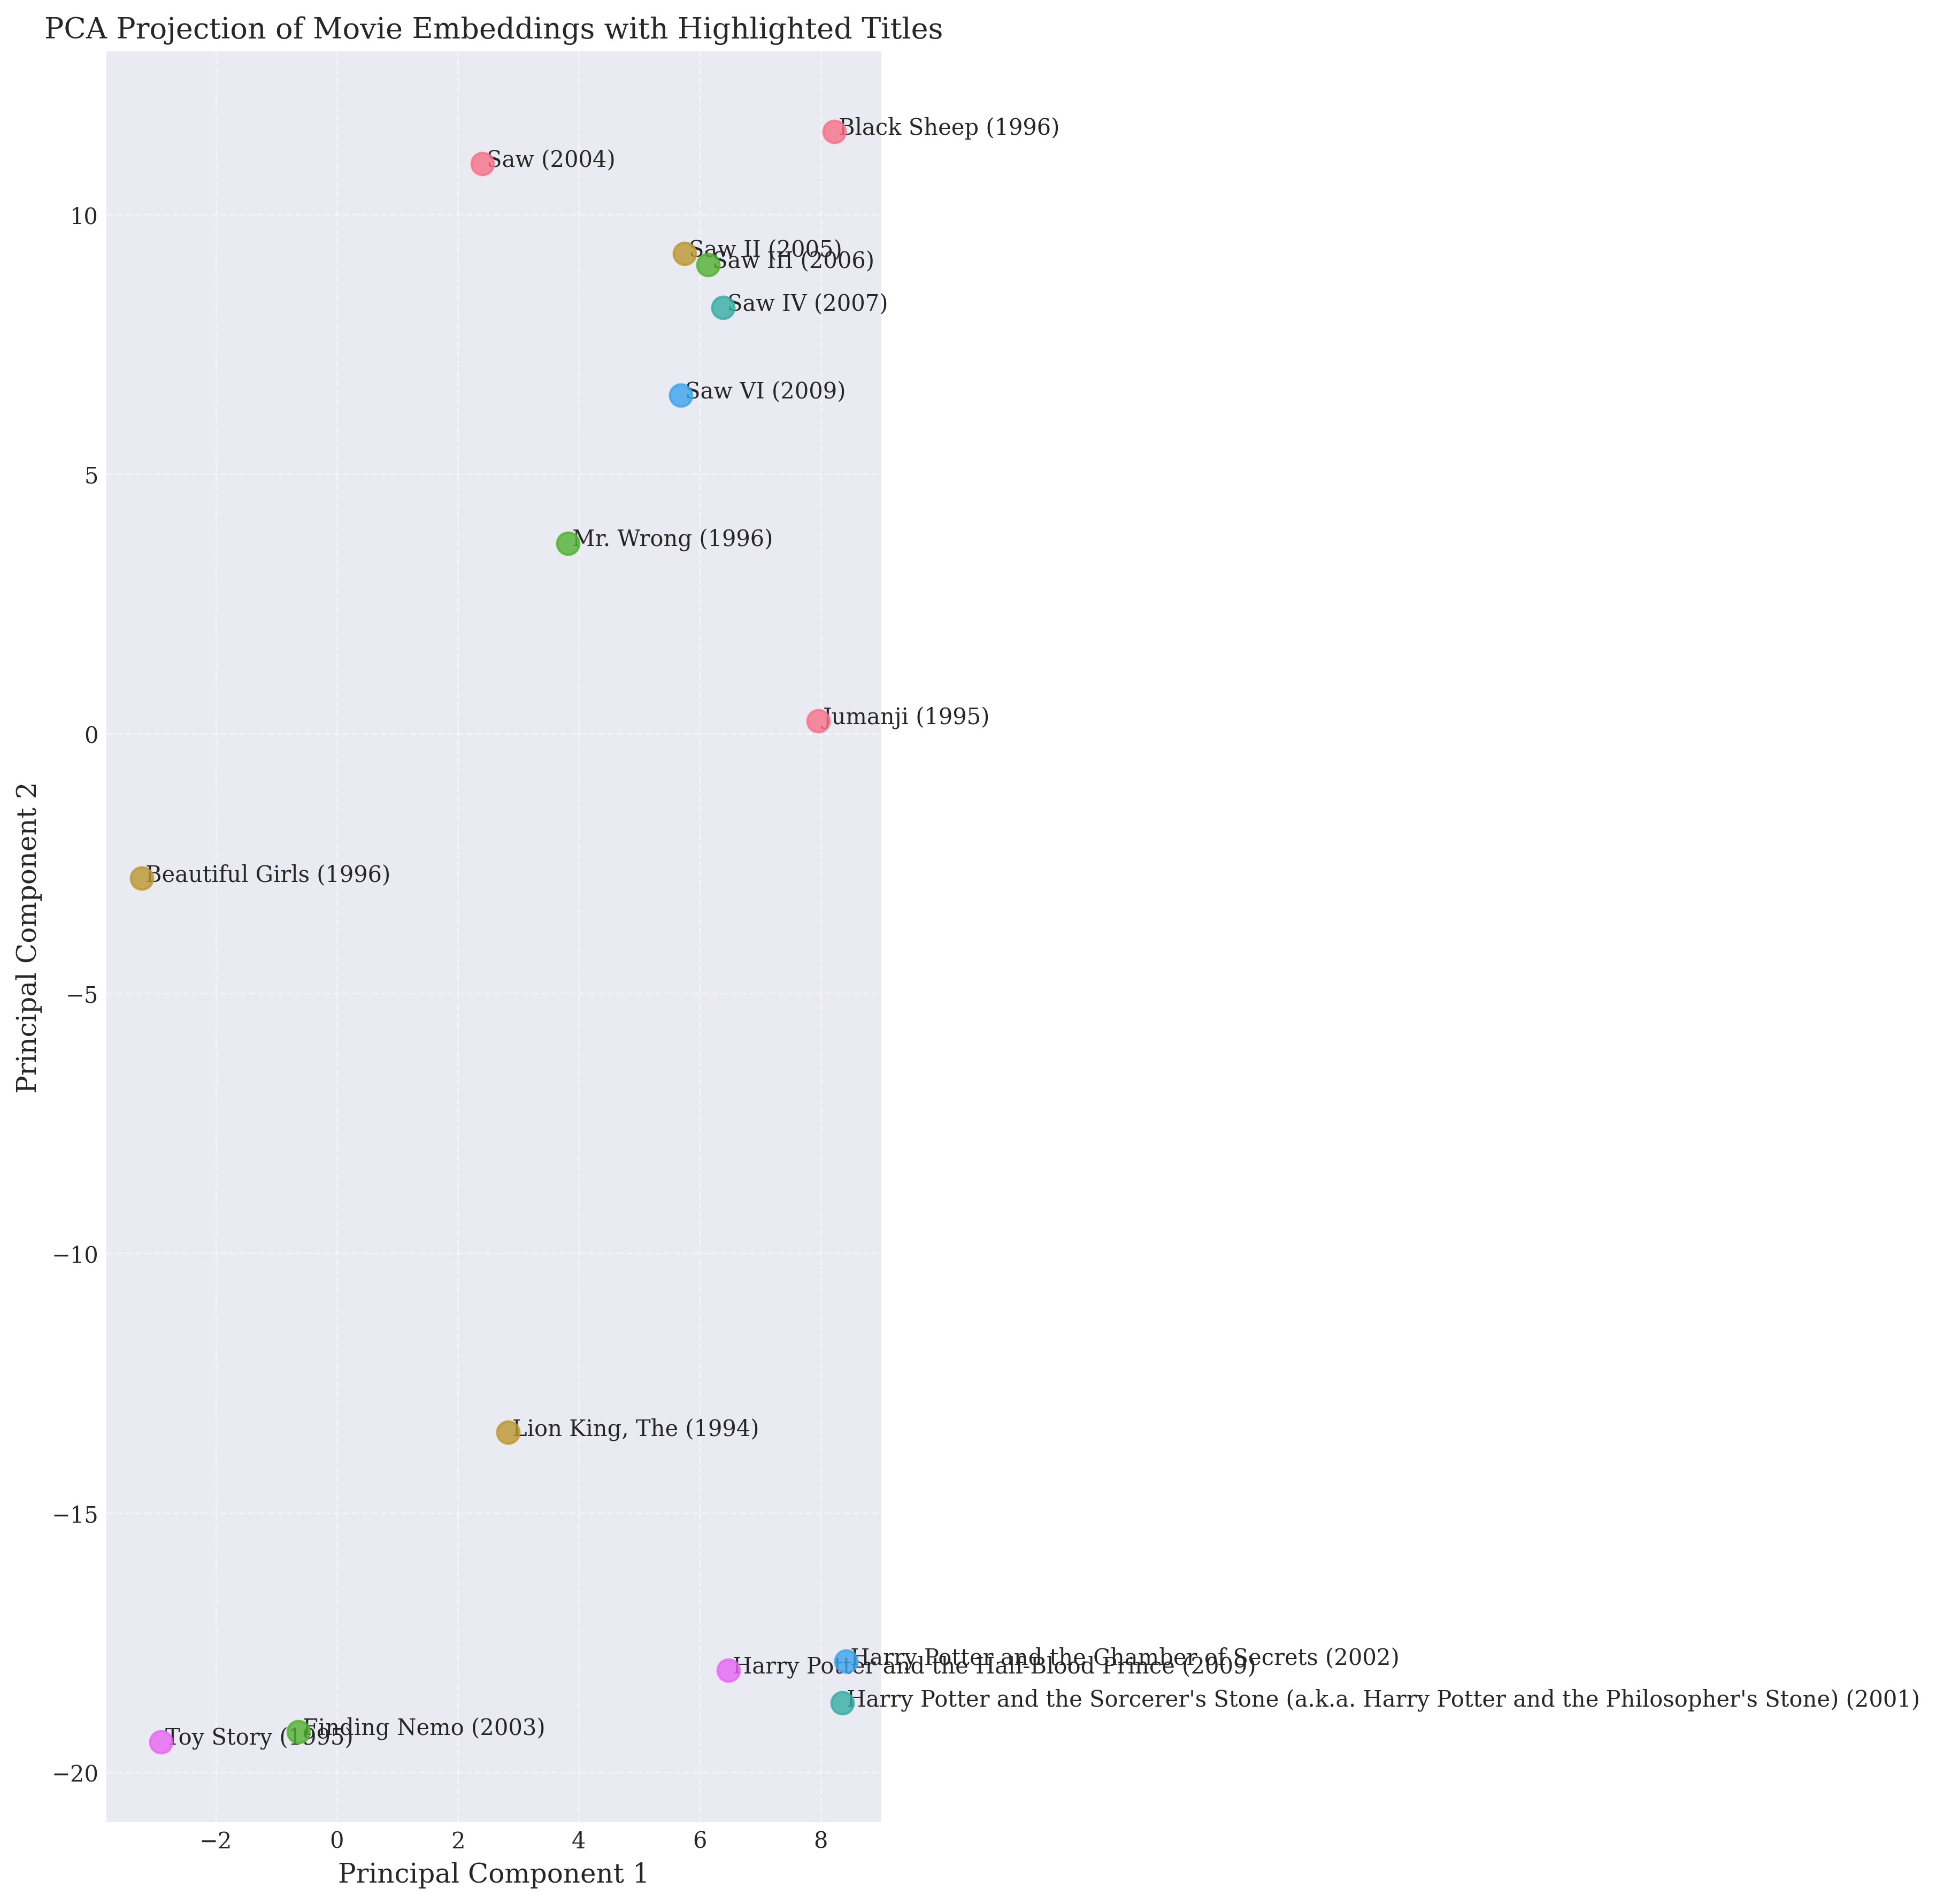

In [ ]:
# PCA VISUALIZATION OF SPECIFIC MOVIES

# 1. Transpose (Users as features, Movies as samples)
X_input = movie_embeddings.T

# 2. Standardize
Standarized_movie_embeddings = standard_scaler(X_input)

# 3. Apply PCA
movie_embeddings_2D = pca_2d(Standarized_movie_embeddings)

print("Original Data Shape:", movie_embeddings.shape)
print("Reduced Data Shape:", movie_embeddings_2D.shape)
print()

# 4. Plot specific movies
movie_ids_plot = [8957, 39446, 48877, 55577, 72129, 1, 2, 364, 6377, 4896, 5816, 69844, 88, 94, 102]

plt.figure(figsize=(12, 12))
plt.title("PCA Projection of Movie Embeddings with Highlighted Titles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)

offset = 0.07

# Plot each movie
for movie in movie_ids_plot:
    if movie in ratings_matrix.movieid_to_idx:
        movie_idx_plot = ratings_matrix.movieid_to_idx[movie]

        movie_x = movie_embeddings_2D[movie_idx_plot, 0]
        movie_y = movie_embeddings_2D[movie_idx_plot, 1]

        plt.scatter(movie_x, movie_y, s=100, alpha=0.8, zorder=5)

        # Retrieve and annotate title
        try:
            row = df2[df2['movieId'] == movie][['title']].values[0][0]
            plt.annotate(
                row,
                (movie_x, movie_y),
                xytext=(movie_x + offset, movie_y + offset),
                fontsize=10,
                textcoords='data',
                ha='left',
                va='center'
            )
        except IndexError:
            print(f"Title not found for ID {movie}")

plt.tight_layout()
plt.savefig('plots/pca_movies.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [ ]:
# GENRE-SPECIFIC PCA VISUALIZATION

def visualize_specific_genres_pca(ratings_matrix, movie_embeddings, df_movies,
                                  target_genres=['Children', 'Horror', 'Sci-Fi', 'Documentary'],
                                  samples_per_genre=100):


    print(f"1. Sorting movies by popularity...")
    counts = get_movie_counts(ratings_matrix)
    sorted_indices = np.argsort(counts)[::-1]

    print(f"2. Collecting top {samples_per_genre} movies for: {target_genres}...")

    collected_data = {genre: [] for genre in target_genres}
    seen_movies = set()

    # Filter movies by genre
    for idx in sorted_indices:
        # Stop if we have enough samples for all genres
        if all(len(collected_data[g]) >= samples_per_genre for g in target_genres):
            break

        movie_id = ratings_matrix.idx_to_movieid[idx]
        if movie_id in seen_movies:
            continue

        try:
            row = df_movies[df_movies['movieId'] == movie_id].values[0]
            title = row[1]
            genre_str = row[2]

            # Check if movie belongs to any target genre
            for target in target_genres:
                if target in genre_str:
                    if len(collected_data[target]) < samples_per_genre:
                        collected_data[target].append({
                            'embedding': movie_embeddings[:, idx],  # Shape (k,)
                            'title': title,
                            'genre_label': target
                        })
                        seen_movies.add(movie_id)
                        break
        except (IndexError, KeyError):
            continue

    # Prepare data for PCA
    final_embeddings = []
    final_labels = []
    final_titles = []

    for genre in target_genres:
        print(f"   Found {len(collected_data[genre])} movies for '{genre}'")
        for item in collected_data[genre]:
            final_embeddings.append(item['embedding'])
            final_labels.append(item['genre_label'])
            final_titles.append(item['title'])

    # Convert to NumPy array (N_samples, k)
    X = np.array(final_embeddings, dtype=np.float64)

    print(f"3. Running PCA on shape {X.shape}...")

    # Apply standardization and PCA
    X_std = standard_scaler(X)
    pca_results = pca_2d(X_std)

    print("4. Generating PCA Plot...")
    plt.figure(figsize=(14, 10))

    genre_colors = {
        'Children': 'tab:green',
        'Horror': 'black',
        'Comedy': 'tab:red',
        'Documentary': 'tab:blue',
        'Sci-Fi': 'tab:purple'
    }

    # Plot each genre
    for genre in target_genres:
        indices = [i for i, x in enumerate(final_labels) if x == genre]
        if not indices:
            continue

        points_x = pca_results[indices, 0]
        points_y = pca_results[indices, 1]

        plt.scatter(points_x, points_y,
                    c=genre_colors.get(genre, 'gray'),
                    label=genre,
                    s=80, alpha=0.7, edgecolors='white')

        # Annotate a few random titles
        if len(indices) > 0:
            subset_indices = random.sample(indices, min(3, len(indices)))
            for i in subset_indices:
                plt.annotate(final_titles[i],
                             (pca_results[i, 0], pca_results[i, 1]),
                             fontsize=8, weight='bold', alpha=0.8,
                             xytext=(5, 5), textcoords='offset points')

    plt.title(f"PCA Projection of Specific Genres (Top {samples_per_genre} Popular)", fontsize=15)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Genre")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('plots/pca_genre.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

1. Sorting movies by popularity...
2. Collecting top 100 movies for: ['Children', 'Horror', 'Comedy', 'Documentary']...
   Found 100 movies for 'Children'
   Found 100 movies for 'Horror'
   Found 100 movies for 'Comedy'
   Found 100 movies for 'Documentary'
3. Running PCA on shape (400, 20)...
4. Generating PCA Plot...


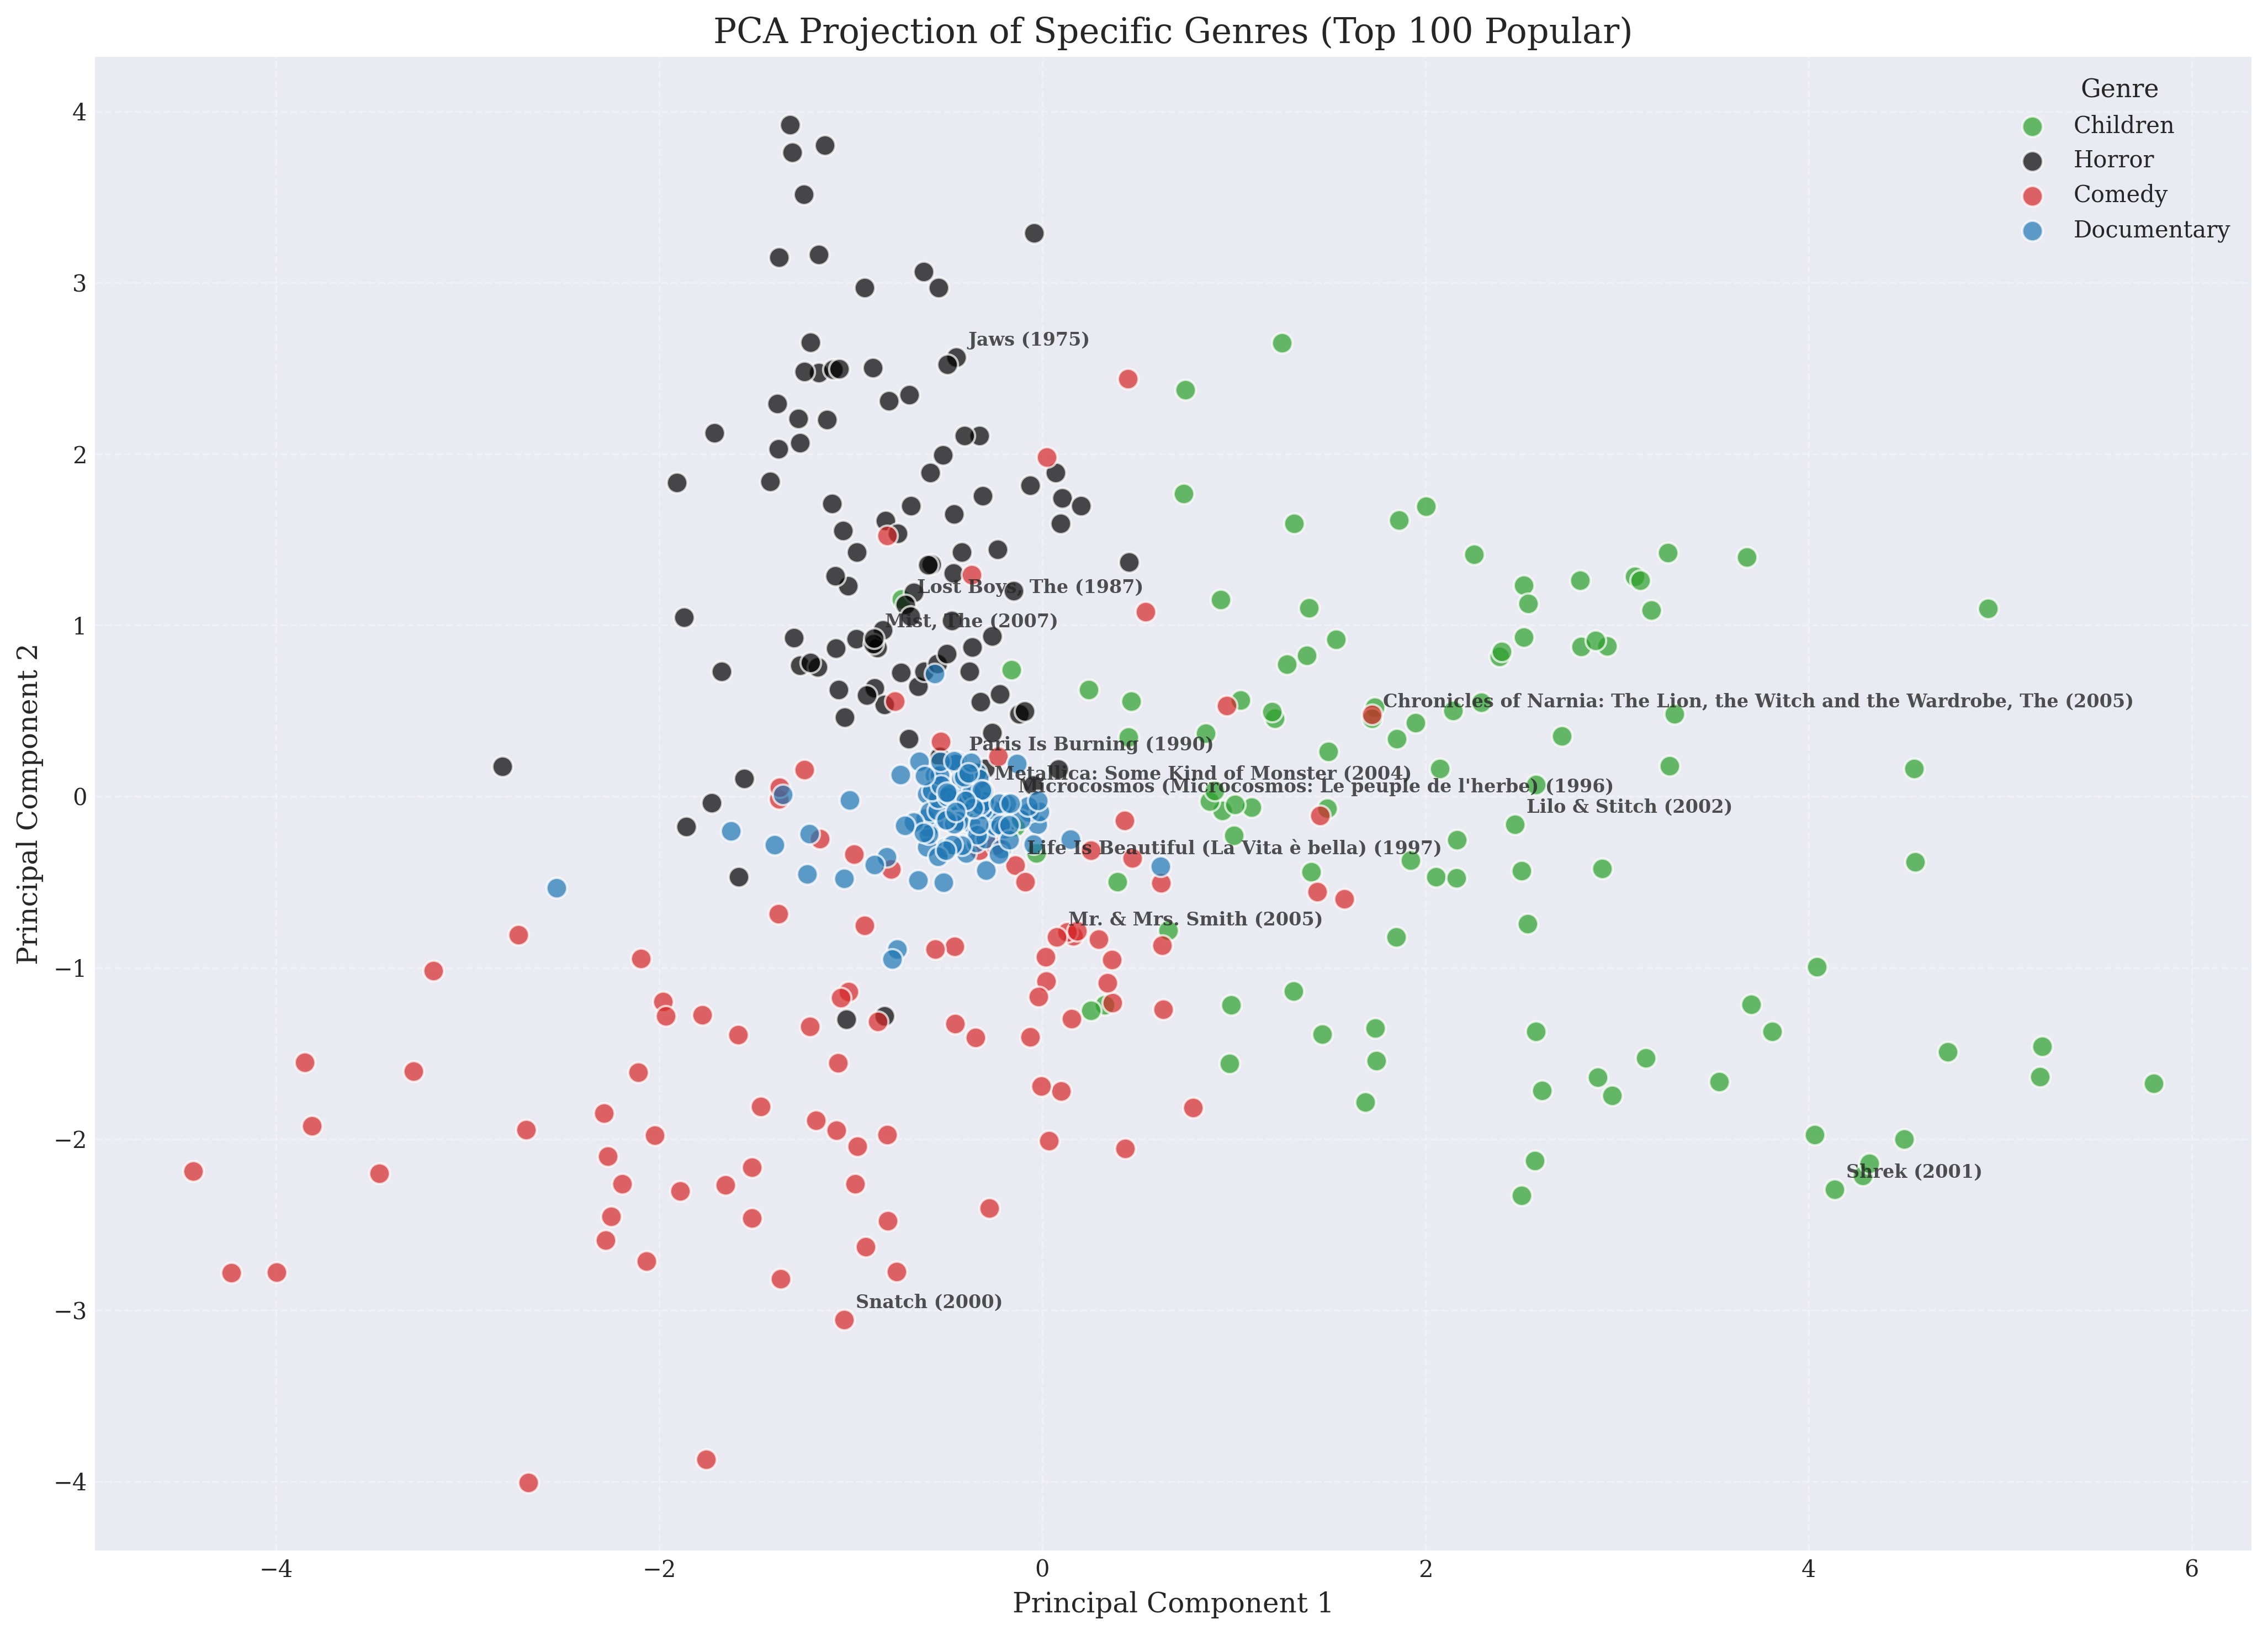

In [ ]:
visualize_specific_genres_pca(
    ratings_matrix,
    movie_embeddings,
    df2,
    target_genres=['Children', 'Horror', 'Comedy', 'Documentary'],
    samples_per_genre=100
)

# Practical 3,4 with OPTIMIZED CODE (numba)

## Preparing the Dataset

In [ ]:
# URL of the dataset
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
zip_file = "ml-32m.zip"
extract_folder = "ml-32m"

print(f"Starting download of {url}...")

# Use !wget to download the file in Colab
# -q makes it quiet (less output)
!wget -q $url

print("Download complete.")

# Check if the file was downloaded successfully
if os.path.exists(zip_file):
    print(f"Successfully downloaded {zip_file}.")

    # Unzip the file
    print(f"Unzipping {zip_file}...")
    # -o overwrites existing files without asking
    # -d specifies the directory to extract to
    !unzip -o $zip_file -d $extract_folder

    print(f"Successfully unzipped to '{extract_folder}' folder.")

    # List the contents of the extracted folder
    print(f"\nContents of {extract_folder}:")
    !ls -l $extract_folder
else:
    print(f"Error: {zip_file} was not downloaded.")

Starting download of https://files.grouplens.org/datasets/movielens/ml-32m.zip...
zsh:1: command not found: wget
Download complete.
Successfully downloaded ml-32m.zip.
Unzipping ml-32m.zip...
Archive:  ml-32m.zip
  inflating: ml-32m/ml-32m/tags.csv  
  inflating: ml-32m/ml-32m/links.csv  
  inflating: ml-32m/ml-32m/README.txt  
  inflating: ml-32m/ml-32m/checksums.txt  
  inflating: ml-32m/ml-32m/ratings.csv  
  inflating: ml-32m/ml-32m/movies.csv  
Successfully unzipped to 'ml-32m' folder.

Contents of ml-32m:
total 0
drwxrwxr-x@ 9 ethar  staff  288 Jan  9 03:45 ml-32m


## Setting directory

In [ ]:
# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Running in Colab - mount Drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd /content/gdrive/MyDrive/Colab Notebooks/Ml_scale/ml-32m
else:
    # Running locally
    %cd /Users/ethar/Desktop/Master/Masters Blocks/MLscale/ml-32m

/Users/ethar/Desktop/Master/Masters Blocks/MLscale/ml-32m


## Content Verfication

In [ ]:
!md5sum links.csv movies.csv ratings.csv tags.csv

8f033867bcb4e6be8792b21468b4fa6e  links.csv
0df90835c19151f9d819d0822e190797  movies.csv
cf12b74f9ad4b94a011f079e26d4270a  ratings.csv
963bf4fa4de6b8901868fddd3eb54567  tags.csv


## Optimization functions

In [ ]:
# NUMBA KERNELS (The Engine Room)
# These functions handle the heavy math logic
# but compiled to machine code and parallelized.

@njit(parallel=True, fastmath=True)
def _numba_compute_loss(user_ptr, col_indices, values, U, V, b_u, b_m,
                        lamda, gamma_u, gamma_v, gamma_b):
    """
    Numba optimized loss computation.
    """
    squared_error = 0.0
    n_ratings = 0
    n_users = len(user_ptr) - 1

    # Parallel loop over users
    for u in prange(n_users):
        start = user_ptr[u]
        end = user_ptr[u+1]

        if start == end:
            continue

        # Slice for this user
        cols = col_indices[start:end]
        ratings = values[start:end]

        # Calculate error for this user's ratings
        local_error = 0.0
        for i in range(len(cols)):
            m = cols[i]
            r = ratings[i]

            # Dot product U[:, u] @ V[:, m]
            interaction = 0.0
            for f in range(U.shape[0]):
                interaction += U[f, u] * V[f, m]

            pred = interaction + b_u[u] + b_m[m]
            diff = r - pred
            local_error += diff * diff

        squared_error += local_error
        n_ratings += (end - start)

    # Regularization (Global sums)
    user_embedding_reg = np.sum(U ** 2)
    movie_embedding_reg = np.sum(V ** 2)
    user_bias_reg = np.sum(b_u ** 2)
    movie_bias_reg = np.sum(b_m ** 2)

    loss = (lamda / 2) * squared_error + \
           (gamma_u / 2) * user_embedding_reg + \
           (gamma_v / 2) * movie_embedding_reg + \
           (gamma_b / 2) * (user_bias_reg + movie_bias_reg)

    rmse = np.sqrt(squared_error / n_ratings) if n_ratings > 0 else 0.0

    return loss, rmse

@njit(parallel=True, fastmath=True)
def _numba_update_users(user_ptr, col_indices, values, U, V, b_u, b_m,
                        k, lamda, gamma_u, gamma_b):
    """
    Numba optimized User Update loop.
    """
    n_users = len(user_ptr) - 1

    # Iterate over users in parallel
    for u in prange(n_users):
        start = user_ptr[u]
        end = user_ptr[u+1]

        if start == end:
            continue

        n_ratings = end - start
        cols = col_indices[start:end]  # Movie indices
        ratings = values[start:end]    # Rating values

        # 1. BIAS UPDATE
        sum_residuals = 0.0

        for i in range(n_ratings):
            m_idx = cols[i]
            r_val = ratings[i]

            dot_val = 0.0
            for f in range(k):
                dot_val += U[f, u] * V[f, m_idx]

            sum_residuals += (r_val - b_m[m_idx] - dot_val)

        bias = lamda * sum_residuals
        b_u[u] = bias / (lamda * n_ratings + gamma_b)

        # 2. EMBEDDING UPDATE

        # Init A (LHS) with Identity * gamma_u
        A = np.eye(k, dtype=np.float64) * gamma_u
        # Init B (RHS)
        B = np.zeros(k, dtype=np.float64)

        # Accumulate V @ V.T and V @ residuals
        for i in range(n_ratings):
            m_idx = cols[i]
            r_val = ratings[i]

            factor = lamda
            for r in range(k):
                val_r = V[r, m_idx]

                residual = r_val - b_u[u] - b_m[m_idx]
                B[r] += factor * val_r * residual

                for c in range(k):
                    A[r, c] += factor * val_r * V[c, m_idx]

        U[:, u] = np.linalg.solve(A, B)


@njit(parallel=True, fastmath=True)
def _numba_update_movies(movie_ptr, row_indices, values, U, V, b_u, b_m,
                         k, lamda, gamma_v, gamma_b):
    """
    Numba optimized Movie Update loop.
    """
    n_movies = len(movie_ptr) - 1

    for m in prange(n_movies):
        start = movie_ptr[m]
        end = movie_ptr[m+1]

        if start == end:
            continue

        n_ratings = end - start
        rows = row_indices[start:end] # User indices
        ratings = values[start:end]   # Rating values

        # 1. BIAS UPDATE
        sum_residuals = 0.0

        for i in range(n_ratings):
            u_idx = rows[i]
            r_val = ratings[i]

            dot_val = 0.0
            for f in range(k):
                dot_val += U[f, u_idx] * V[f, m]

            sum_residuals += (r_val - b_u[u_idx] - dot_val)

        bias = lamda * sum_residuals
        b_m[m] = bias / (lamda * n_ratings + gamma_b)

        # 2. EMBEDDING UPDATE
        A = np.eye(k, dtype=np.float64) * gamma_v
        B = np.zeros(k, dtype=np.float64)

        factor = lamda
        for i in range(n_ratings):
            u_idx = rows[i]
            r_val = ratings[i]

            # Residual uses updated movie bias
            residual = r_val - b_u[u_idx] - b_m[m]

            for r in range(k):
                val_r = U[r, u_idx]
                B[r] += factor * val_r * residual
                for c in range(k):
                    A[r, c] += factor * val_r * U[c, u_idx]

        V[:, m] = np.linalg.solve(A, B)




## Data Structure Definition

In [ ]:
# CLASS DEFINITION

class Indexing_Structure:
    """
    Sparse matrix in CSR (Compressed Sparse Row) format for efficient user-based iteration.
    Also maintains CSC (Compressed Sparse Column) format for movie-based iteration.
    """

    def __init__(self, ratings):
        self.number_of_users = 0
        self.userid_to_idx = {}
        self.idx_to_userid = []

        self.number_of_movies = 0
        self.movieid_to_idx = {}
        self.idx_to_movieid = []

        # Temporary storage during construction
        data_by_user = []
        data_by_movie = []

        for rating in ratings:
            # Map user IDs to indices
            if rating[0] not in self.userid_to_idx:
                self.idx_to_userid.append(rating[0])
                self.userid_to_idx[rating[0]] = self.number_of_users
                self.number_of_users += 1
                data_by_user.append([])

            # Map movie IDs to indices
            if rating[1] not in self.movieid_to_idx:
                self.idx_to_movieid.append(rating[1])
                self.movieid_to_idx[rating[1]] = self.number_of_movies
                self.number_of_movies += 1
                data_by_movie.append([])

            user_idx = self.userid_to_idx[rating[0]]
            movie_idx = self.movieid_to_idx[rating[1]]
            rating_val = rating[2].item() if hasattr(rating[2], 'item') else rating[2]

            data_by_user[user_idx].append((movie_idx, rating_val))
            data_by_movie[movie_idx].append((user_idx, rating_val))

        # Build CSR format (for users)
        self._build_csr(data_by_user)

        # Build CSC format (for movies)
        self._build_csc(data_by_movie)

        print(f"Initialized SparseMatrix:")
        print(f"  Users: {self.number_of_users}")
        print(f"  Movies: {self.number_of_movies}")
        print(f"  Ratings: {len(self.csr_col_indices)}")


    def _build_csr(self, data_by_user):
        """Build CSR (Compressed Sparse Row) format for user-based access"""
        self.user_ptr = np.zeros(self.number_of_users + 1, dtype=np.int32)
        all_movie_indices = []
        all_ratings = []

        for user_idx, user_ratings in enumerate(data_by_user):
            all_movie_indices.extend([movie_idx for movie_idx, rating in user_ratings])
            all_ratings.extend([rating for movie_idx, rating in user_ratings])
            self.user_ptr[user_idx + 1] = len(all_movie_indices)

        self.csr_col_indices = np.array(all_movie_indices, dtype=np.int32)
        self.csr_values = np.array(all_ratings, dtype=np.float32)


    def _build_csc(self, data_by_movie):
        """Build CSC (Compressed Sparse Column) format for movie-based access"""
        self.movie_ptr = np.zeros(self.number_of_movies + 1, dtype=np.int32)
        all_user_indices = []
        all_ratings = []

        for movie_idx, movie_ratings in enumerate(data_by_movie):
            all_user_indices.extend([user_idx for user_idx, rating in movie_ratings])
            all_ratings.extend([rating for user_idx, rating in movie_ratings])
            self.movie_ptr[movie_idx + 1] = len(all_user_indices)

        self.csc_row_indices = np.array(all_user_indices, dtype=np.int32)
        self.csc_values = np.array(all_ratings, dtype=np.float32)


    def split(self, split_ratio):
        """
        Split data into train/test sets.
        Randomly assigns each rating to train or test, then rebuilds CSR/CSC structures.
        """
        n_ratings = len(self.csr_values)

        # Random train/test assignment
        random_vals = np.random.random(n_ratings)
        train_mask = random_vals < split_ratio
        test_mask = ~train_mask

        # Split CSR data
        data_by_user_train = [[] for _ in range(self.number_of_users)]
        data_by_user_test = [[] for _ in range(self.number_of_users)]

        for user_idx in range(self.number_of_users):
            start = self.user_ptr[user_idx]
            end = self.user_ptr[user_idx + 1]

            for i in range(start, end):
                movie_idx = self.csr_col_indices[i]
                rating = self.csr_values[i]

                if train_mask[i]:
                    data_by_user_train[user_idx].append((movie_idx, rating))
                else:
                    data_by_user_test[user_idx].append((movie_idx, rating))

        # Build train CSR
        self.user_ptr_train = np.zeros(self.number_of_users + 1, dtype=np.int32)
        train_movies = []
        train_ratings = []

        for user_idx, user_ratings in enumerate(data_by_user_train):
            train_movies.extend([m for m, r in user_ratings])
            train_ratings.extend([r for m, r in user_ratings])
            self.user_ptr_train[user_idx + 1] = len(train_movies)

        self.csr_col_indices_train = np.array(train_movies, dtype=np.int32)
        self.csr_values_train = np.array(train_ratings, dtype=np.float32)

        # Build test CSR
        self.user_ptr_test = np.zeros(self.number_of_users + 1, dtype=np.int32)
        test_movies = []
        test_ratings = []

        for user_idx, user_ratings in enumerate(data_by_user_test):
            test_movies.extend([m for m, r in user_ratings])
            test_ratings.extend([r for m, r in user_ratings])
            self.user_ptr_test[user_idx + 1] = len(test_movies)

        self.csr_col_indices_test = np.array(test_movies, dtype=np.int32)
        self.csr_values_test = np.array(test_ratings, dtype=np.float32)

        # Build train/test CSC (for movie iterations)
        data_by_movie_train = [[] for _ in range(self.number_of_movies)]
        data_by_movie_test = [[] for _ in range(self.number_of_movies)]

        for user_idx in range(self.number_of_users):
            for movie_idx, rating in data_by_user_train[user_idx]:
                data_by_movie_train[movie_idx].append((user_idx, rating))
            for movie_idx, rating in data_by_user_test[user_idx]:
                data_by_movie_test[movie_idx].append((user_idx, rating))

        # Build train CSC
        self.movie_ptr_train = np.zeros(self.number_of_movies + 1, dtype=np.int32)
        train_users = []
        train_ratings_csc = []

        for movie_idx, movie_ratings in enumerate(data_by_movie_train):
            train_users.extend([u for u, r in movie_ratings])
            train_ratings_csc.extend([r for u, r in movie_ratings])
            self.movie_ptr_train[movie_idx + 1] = len(train_users)

        self.csc_row_indices_train = np.array(train_users, dtype=np.int32)
        self.csc_values_train = np.array(train_ratings_csc, dtype=np.float32)

        # Build test CSC
        self.movie_ptr_test = np.zeros(self.number_of_movies + 1, dtype=np.int32)
        test_users = []
        test_ratings_csc = []

        for movie_idx, movie_ratings in enumerate(data_by_movie_test):
            test_users.extend([u for u, r in movie_ratings])
            test_ratings_csc.extend([r for u, r in movie_ratings])
            self.movie_ptr_test[movie_idx + 1] = len(test_users)

        self.csc_row_indices_test = np.array(test_users, dtype=np.int32)
        self.csc_values_test = np.array(test_ratings_csc, dtype=np.float32)

        # Store counts
        self.number_of_users_train = self.number_of_users
        self.number_of_movies_train = self.number_of_movies
        self.number_of_users_test = self.number_of_users
        self.number_of_movies_test = self.number_of_movies

        n_train = len(self.csr_values_train)
        n_test = len(self.csr_values_test)

        print(f"\nData split:")
        print(f"  Train ratings: {n_train} ({n_train/(n_train+n_test)*100:.2f}%)")
        print(f"  Test ratings: {n_test} ({n_test/(n_train+n_test)*100:.2f}%)")






def plot_training_results(loss_history, rmse_history, rmse_test_history):
    """Plot training metrics"""
    plt.figure(figsize=(18, 5))

    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(loss_history, marker='o')
    plt.title("Loss over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)

    # Plot training RMSE
    plt.subplot(1, 3, 2)
    plt.plot(rmse_history, marker='o', color='orange')
    plt.title("Training RMSE")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)

    # Plot test RMSE
    plt.subplot(1, 3, 3)
    plt.plot(rmse_test_history, marker='o', color='green')
    plt.title("Test RMSE")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



## Random Search with Early Stopping

In [ ]:
# LOAD DATA

# Using 'float' explicitly ensures compatibility
ratings = np.loadtxt("ratings.csv", delimiter=",", skiprows=1, usecols=(0, 1, 2))

# Create sparse matrix
ratings_matrix = Indexing_Structure(ratings)

# Split data
ratings_matrix.split(0.9)
print("Data loaded and split successfully!")


Initialized SparseMatrix:
  Users: 200948
  Movies: 84432
  Ratings: 32000204

Data split:
  Train ratings: 28798782 (90.00%)
  Test ratings: 3201422 (10.00%)
Data loaded and split successfully!


In [ ]:
# NUMBA KERNELS

@njit(parallel=True)
def compute_rmse_numba(user_ptr, csr_col_indices, csr_values,
                       user_embeddings, movie_embeddings,
                       user_biases, movie_biases):
    """Compute RMSE using CSR format with parallel processing."""
    n_users = len(user_ptr) - 1
    squared_errors = np.zeros(n_users)
    counts = np.zeros(n_users, dtype=np.int32)

    for user_idx in prange(n_users):
        start = user_ptr[user_idx]
        end = user_ptr[user_idx + 1]
        n_ratings = end - start

        if n_ratings == 0:
            continue

        local_se = 0.0
        user_emb = user_embeddings[:, user_idx].copy()

        for i in range(start, end):
            movie_idx = csr_col_indices[i]
            rating = csr_values[i]
            movie_emb = movie_embeddings[:, movie_idx].copy()

            pred = user_biases[user_idx] + movie_biases[movie_idx] + np.dot(user_emb, movie_emb)
            local_se += (rating - pred) ** 2

        squared_errors[user_idx] = local_se
        counts[user_idx] = n_ratings

    total_se = np.sum(squared_errors)
    total_count = np.sum(counts)

    return np.sqrt(total_se / total_count) if total_count > 0 else np.inf


@njit
def solve_linear_system(A, b):
    """Solve Ax = b with numerical stability."""
    k = len(b)
    A_stable = A + 1e-10 * np.eye(k)

    if not np.all(np.isfinite(A_stable)) or not np.all(np.isfinite(b)):
        return np.zeros(k)

    try:
        L = np.linalg.cholesky(A_stable)
        y = np.linalg.solve(L, b)
        x = np.linalg.solve(L.T, y)
        if np.all(np.isfinite(x)):
            return x
    except:
        pass

    x, _, _, _ = np.linalg.lstsq(A_stable, b)
    if not np.all(np.isfinite(x)):
        return np.zeros(k)

    return x


@njit
def update_user_params(user_idx, user_ptr, csr_col_indices, csr_values,
                       user_embeddings, movie_embeddings, movie_biases,
                       lamda, gamma_u, gamma_b, k):
    """Update user bias and embedding."""
    start = user_ptr[user_idx]
    end = user_ptr[user_idx + 1]
    n_ratings = end - start

    if n_ratings == 0:
        return 0.0, user_embeddings[:, user_idx].copy()

    # Update bias
    bias_sum = 0.0
    user_emb = user_embeddings[:, user_idx].copy()

    for i in range(start, end):
        movie_idx = csr_col_indices[i]
        rating = csr_values[i]
        movie_emb = movie_embeddings[:, movie_idx].copy()
        pred_no_bias = np.dot(user_emb, movie_emb)
        bias_sum += rating - movie_biases[movie_idx] - pred_no_bias

    new_bias = (lamda * bias_sum) / (lamda * n_ratings + gamma_b)

    # Update embedding
    first_term = gamma_u * np.eye(k)
    second_term = np.zeros(k)

    for i in range(start, end):
        movie_idx = csr_col_indices[i]
        rating = csr_values[i]
        v_n = movie_embeddings[:, movie_idx].copy()

        if not np.all(np.isfinite(v_n)):
            continue

        first_term += lamda * np.outer(v_n, v_n)
        resid = rating - new_bias - movie_biases[movie_idx]
        second_term += lamda * v_n * resid

    new_emb = solve_linear_system(first_term, second_term)
    return new_bias, new_emb


@njit
def update_movie_params(movie_idx, movie_ptr, csc_row_indices, csc_values,
                        user_embeddings, movie_embeddings, user_biases,
                        lamda, gamma_v, gamma_b, k):
    """Update movie bias and embedding."""
    start = movie_ptr[movie_idx]
    end = movie_ptr[movie_idx + 1]
    m_ratings = end - start

    if m_ratings == 0:
        return 0.0, movie_embeddings[:, movie_idx].copy()

    # Update bias
    bias_sum = 0.0
    movie_emb = movie_embeddings[:, movie_idx].copy()

    for i in range(start, end):
        user_idx = csc_row_indices[i]
        rating = csc_values[i]
        user_emb = user_embeddings[:, user_idx].copy()
        pred_no_bias = np.dot(user_emb, movie_emb)
        bias_sum += rating - user_biases[user_idx] - pred_no_bias

    new_bias = (lamda * bias_sum) / (lamda * m_ratings + gamma_b)

    # Update embedding
    first_term = gamma_v * np.eye(k)
    second_term = np.zeros(k)

    for i in range(start, end):
        user_idx = csc_row_indices[i]
        rating = csc_values[i]
        u_m = user_embeddings[:, user_idx].copy()

        if not np.all(np.isfinite(u_m)):
            continue

        first_term += lamda * np.outer(u_m, u_m)
        resid = rating - user_biases[user_idx] - new_bias
        second_term += lamda * u_m * resid

    new_emb = solve_linear_system(first_term, second_term)
    return new_bias, new_emb


@njit
def train_one_iteration(user_ptr, csr_col_indices, csr_values,
                        movie_ptr, csc_row_indices, csc_values,
                        user_embeddings, movie_embeddings,
                        user_biases, movie_biases,
                        lamda, gamma_u, gamma_v, gamma_b, k):
    """One full ALS iteration."""
    n_users = len(user_ptr) - 1
    n_movies = len(movie_ptr) - 1

    # Update users
    for user_idx in range(n_users):
        new_bias, new_emb = update_user_params(
            user_idx, user_ptr, csr_col_indices, csr_values,
            user_embeddings, movie_embeddings, movie_biases,
            lamda, gamma_u, gamma_b, k
        )
        user_biases[user_idx] = new_bias
        user_embeddings[:, user_idx] = new_emb

    # Update movies
    for movie_idx in range(n_movies):
        new_bias, new_emb = update_movie_params(
            movie_idx, movie_ptr, csc_row_indices, csc_values,
            user_embeddings, movie_embeddings, user_biases,
            lamda, gamma_v, gamma_b, k
        )
        movie_biases[movie_idx] = new_bias
        movie_embeddings[:, movie_idx] = new_emb

    return user_embeddings, movie_embeddings, user_biases, movie_biases


@njit
def train_with_early_stopping(user_ptr_train, csr_col_train, csr_val_train,
                               movie_ptr_train, csc_row_train, csc_val_train,
                               user_ptr_test, csr_col_test, csr_val_test,
                               user_embeddings, movie_embeddings,
                               user_biases, movie_biases,
                               lamda, gamma_u, gamma_v, gamma_b, k,
                               max_iterations, patience):
    """
    Train with early stopping based on test RMSE.
    Stops if test RMSE doesn't improve for 'patience' iterations.
    """
    best_test_rmse = np.inf
    no_improve_count = 0

    for iteration in range(max_iterations):
        # Train one iteration
        user_embeddings, movie_embeddings, user_biases, movie_biases = train_one_iteration(
            user_ptr_train, csr_col_train, csr_val_train,
            movie_ptr_train, csc_row_train, csc_val_train,
            user_embeddings, movie_embeddings,
            user_biases, movie_biases,
            lamda, gamma_u, gamma_v, gamma_b, k
        )

        # Evaluate on test set
        test_rmse = compute_rmse_numba(
            user_ptr_test, csr_col_test, csr_val_test,
            user_embeddings, movie_embeddings, user_biases, movie_biases
        )

        # Early stopping check
        if test_rmse < best_test_rmse - 1e-5:  # Improvement threshold
            best_test_rmse = test_rmse
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            break

    return user_embeddings, movie_embeddings, user_biases, movie_biases, best_test_rmse


# RANDOM SEARCH WITH EARLY STOPPING

def random_search(ratings_matrix, param_distributions, n_trials=50,
                  max_iterations=20, patience=3, verbose=True):
    """
    Random search with early stopping - Much faster than grid search!

    Parameters:
    -----------
    param_distributions : dict
        Dictionary with parameter names and (min, max) tuples or lists of values
    n_trials : int
        Number of random combinations to try
    max_iterations : int
        Maximum iterations per trial
    patience : int
        Early stopping patience
    """

    results = []
    best_rmse = float('inf')
    best_params = None
    best_embeddings = None

    if verbose:
        print(f"Random Search: {n_trials} trials with early stopping (patience={patience})")
        print("-" * 100)
        print(f"{'#':<4} {'k':<4} {'lamda':<10} {'γu':<10} {'γv':<10} {'γb':<10} | {'Test RMSE':<10} {'Iters':<6} {'Time(s)':<8}")
        print("-" * 100)

    # Prepare arrays once
    user_ptr_train = np.ascontiguousarray(ratings_matrix.user_ptr_train, dtype=np.int32)
    csr_col_train = np.ascontiguousarray(ratings_matrix.csr_col_indices_train, dtype=np.int32)
    csr_val_train = np.ascontiguousarray(ratings_matrix.csr_values_train, dtype=np.float64)

    movie_ptr_train = np.ascontiguousarray(ratings_matrix.movie_ptr_train, dtype=np.int32)
    csc_row_train = np.ascontiguousarray(ratings_matrix.csc_row_indices_train, dtype=np.int32)
    csc_val_train = np.ascontiguousarray(ratings_matrix.csc_values_train, dtype=np.float64)

    user_ptr_test = np.ascontiguousarray(ratings_matrix.user_ptr_test, dtype=np.int32)
    csr_col_test = np.ascontiguousarray(ratings_matrix.csr_col_indices_test, dtype=np.int32)
    csr_val_test = np.ascontiguousarray(ratings_matrix.csr_values_test, dtype=np.float64)

    for trial in range(n_trials):
        start_time = time.time()

        # Sample random parameters
        if isinstance(param_distributions['k'], list):
            k = np.random.choice(param_distributions['k'])
        else:
            k = np.random.randint(param_distributions['k'][0], param_distributions['k'][1] + 1)

        lamda = 10 ** np.random.uniform(np.log10(param_distributions['lamda'][0]),
                                         np.log10(param_distributions['lamda'][1]))
        gamma_u = 10 ** np.random.uniform(np.log10(param_distributions['gamma_u'][0]),
                                           np.log10(param_distributions['gamma_u'][1]))
        gamma_v = 10 ** np.random.uniform(np.log10(param_distributions['gamma_v'][0]),
                                           np.log10(param_distributions['gamma_v'][1]))
        gamma_b = 10 ** np.random.uniform(np.log10(param_distributions['gamma_b'][0]),
                                           np.log10(param_distributions['gamma_b'][1]))

        # Initialize
        user_biases = np.zeros(ratings_matrix.number_of_users, dtype=np.float64)
        movie_biases = np.zeros(ratings_matrix.number_of_movies, dtype=np.float64)
        user_embeddings = np.ascontiguousarray(
            np.random.normal(0, 0.01, size=(k, ratings_matrix.number_of_users)),
            dtype=np.float64
        )
        movie_embeddings = np.ascontiguousarray(
            np.random.normal(0, 0.01, size=(k, ratings_matrix.number_of_movies)),
            dtype=np.float64
        )

        # Train with early stopping
        user_embeddings, movie_embeddings, user_biases, movie_biases, test_rmse = \
            train_with_early_stopping(
                user_ptr_train, csr_col_train, csr_val_train,
                movie_ptr_train, csc_row_train, csc_val_train,
                user_ptr_test, csr_col_test, csr_val_test,
                user_embeddings, movie_embeddings,
                user_biases, movie_biases,
                lamda, gamma_u, gamma_v, gamma_b, k,
                max_iterations, patience
            )

        elapsed = time.time() - start_time
        actual_iters = min(max_iterations, patience + 1)  # Approximate

        if verbose:
            print(f"{trial+1:<4} {k:<4} {lamda:<10.6f} {gamma_u:<10.6f} {gamma_v:<10.6f} {gamma_b:<10.6f} | "
                  f"{test_rmse:<10.5f} {actual_iters:<6} {elapsed:<8.1f}")

        results.append({
            'k': k, 'lamda': lamda, 'gamma_u': gamma_u,
            'gamma_v': gamma_v, 'gamma_b': gamma_b,
            'test_rmse': test_rmse, 'time_seconds': elapsed
        })

        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_params = {
                'k': k, 'lamda': lamda, 'gamma_u': gamma_u,
                'gamma_v': gamma_v, 'gamma_b': gamma_b
            }
            best_embeddings = {
                'user_embeddings': user_embeddings.copy(),
                'movie_embeddings': movie_embeddings.copy(),
                'user_biases': user_biases.copy(),
                'movie_biases': movie_biases.copy()
            }

    if verbose:
        print("-" * 100)
        print(f"Best Test RMSE: {best_rmse:.6f}")
        print(f"Best Parameters: {best_params}")

    return pd.DataFrame(results), best_params, best_embeddings


# EXECUTE
print("Starting Random Search with Early Stopping...")
param_distributions = {
    'k': [10, 20, 30],  # Discrete choices
    'lamda': (0.001, 1.0),  # Log-uniform between these values
    'gamma_u': (0.001, 1.0),
    'gamma_v': (0.001, 1.0),
    'gamma_b': (0.001, 1.0)
}

results_df, best_params, best_embeddings = random_search(
    ratings_matrix,
    param_distributions,
    n_trials=50,  # Try 50 random combinations
    max_iterations=15,
    patience=3,
    verbose=True
)


# Save and display results
print("\n" + "="*100)
print("TOP 10 RESULTS")
print("="*100)
print(results_df.sort_values('test_rmse').head(10))

results_df.to_csv('random_search_results.csv', index=False)
print("\n✓ Results saved to 'random_search_results.csv'")

✓ Saved: rmse_by_k.pdf


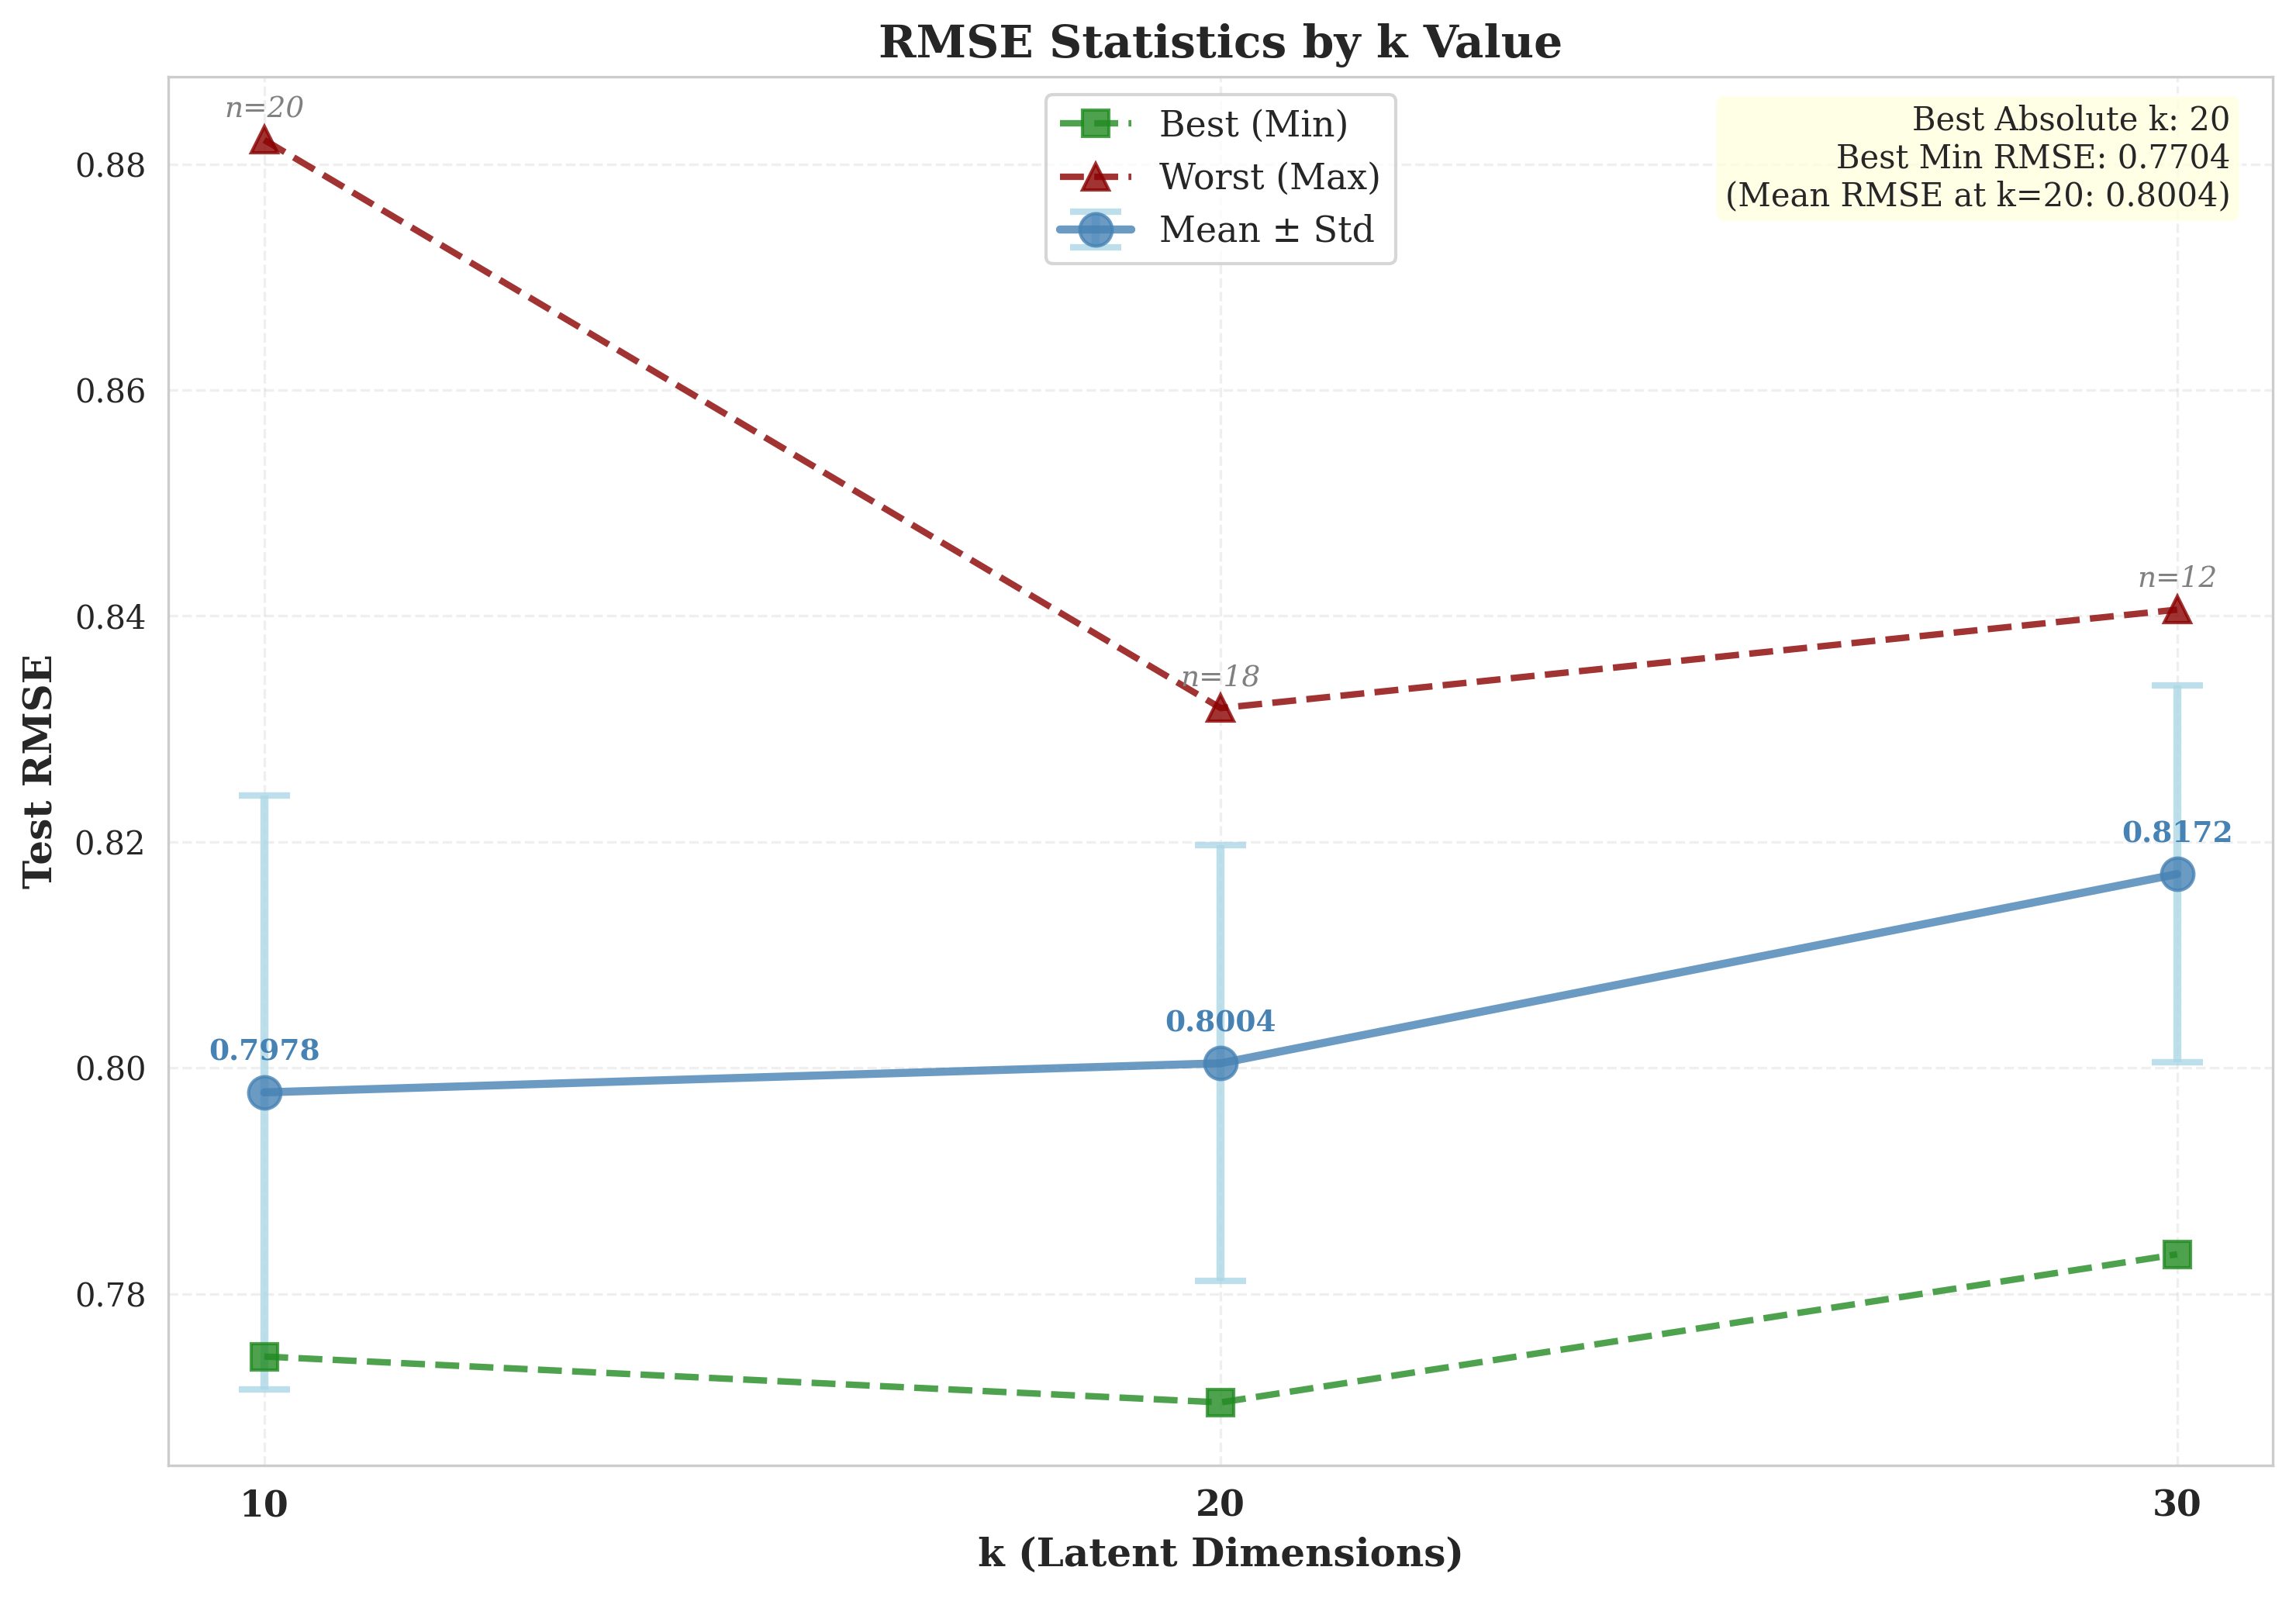


RMSE STATISTICS BY k

k      Mean       Std        Min        Max        Count   
----------------------------------------------------------------------
10     0.797832   0.026305   0.774453   0.882136   20      
20     0.800409   0.019283   0.770391   0.831845   18      
30     0.817154   0.016683   0.783502   0.840556   12      
----------------------------------------------------------------------
Best k (by mean RMSE): 10 (RMSE: 0.797832)
Most stable k (by std): 30 (Std: 0.016683)


SUMMARY STATISTICS

Best RMSE: 0.770391
Worst RMSE: 0.882136
Mean RMSE: 0.803397
Std RMSE: 0.022849

Best Configuration:
  k: 20.000000
  lamda: 0.020393
  gamma_u: 0.858755
  gamma_v: 0.803412
  gamma_b: 0.001924

Total trials: 50
Average time per trial: 452.32s
Total search time: 22615.78s



In [ ]:
# # Load results
results_df = pd.read_csv('random_search_results.csv')

# RMSE STATISTICS BY k (FIXED)

plt.figure(figsize=(10, 7))

# Calculate statistics by k

k_stats = results_df.groupby('k')['test_rmse'].agg(['mean', 'std', 'min', 'max', 'count']).sort_index()
x = range(len(k_stats))

# Plot mean with error bars
plt.errorbar(x, k_stats['mean'], yerr=k_stats['std'], fmt='o-',
             capsize=8, capthick=2, markersize=10, linewidth=2.5,
             color='steelblue', ecolor='lightblue', label='Mean ± Std',
             alpha=0.8)

# Plot min values (The "Best" individual runs)
plt.plot(x, k_stats['min'], 's--', linewidth=2, markersize=8,
         color='forestgreen', label='Best (Min)', alpha=0.8)

# Plot max values
plt.plot(x, k_stats['max'], '^--', linewidth=2, markersize=8,
         color='darkred', label='Worst (Max)', alpha=0.8)

# Annotations for each k
for i, k_val in enumerate(k_stats.index):
    # Annotate mean
    plt.annotate(f'{k_stats["mean"].iloc[i]:.4f}',
                xy=(i, k_stats['mean'].iloc[i]),
                xytext=(0, 10), textcoords='offset points',
                fontsize=9, ha='center', color='steelblue', fontweight='bold')

    # Annotate count
    plt.text(i, k_stats['max'].iloc[i] + 0.002,
             f'n={int(k_stats["count"].iloc[i])}',
             ha='center', fontsize=9, color='gray', style='italic')

plt.xticks(x, k_stats.index, fontsize=11, fontweight='bold')
plt.xlabel('k (Latent Dimensions)', fontsize=12, fontweight='bold')
plt.ylabel('Test RMSE', fontsize=12, fontweight='bold')
plt.title('RMSE Statistics by k Value', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')

best_k = k_stats['min'].idxmin()       # Finds k with the lowest minimum value
best_val = k_stats['min'].min()        # The actual RMSE value
best_k_mean = k_stats.loc[best_k, 'mean'] # The mean for that k

stats_text = f'Best Absolute k: {best_k}\n'
stats_text += f'Best Min RMSE: {best_val:.4f}\n'
stats_text += f'(Mean RMSE at k={best_k}: {best_k_mean:.4f})'

plt.text(0.98, 0.98, stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', ha='right',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('rmse_by_k.pdf', format='pdf', dpi=300, bbox_inches='tight')
print("✓ Saved: rmse_by_k.pdf")
plt.show()
plt.close()

print("\n" + "="*70)
print("RMSE STATISTICS BY k")
print("="*70)
print(f"\n{'k':<6} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Count':<8}")
print("-"*70)
for k_val, row in k_stats.iterrows():
    print(f"{k_val:<6} {row['mean']:<10.6f} {row['std']:<10.6f} "
          f"{row['min']:<10.6f} {row['max']:<10.6f} {int(row['count']):<8}")
print("-"*70)
print(f"Best k (by mean RMSE): {k_stats['mean'].idxmin()} "
      f"(RMSE: {k_stats['mean'].min():.6f})")
print(f"Most stable k (by std): {k_stats['std'].idxmin()} "
      f"(Std: {k_stats['std'].min():.6f})")
print("="*70 + "\n")

# SUMMARY STATISTICS

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nBest RMSE: {results_df['test_rmse'].min():.6f}")
print(f"Worst RMSE: {results_df['test_rmse'].max():.6f}")
print(f"Mean RMSE: {results_df['test_rmse'].mean():.6f}")
print(f"Std RMSE: {results_df['test_rmse'].std():.6f}")

print("\nBest Configuration:")
best_idx = results_df['test_rmse'].idxmin()
best_config = results_df.loc[best_idx]
for param in ['k', 'lamda', 'gamma_u', 'gamma_v', 'gamma_b']:
    print(f"  {param}: {best_config[param]:.6f}")

print(f"\nTotal trials: {len(results_df)}")
print(f"Average time per trial: {results_df['time_seconds'].mean():.2f}s")
print(f"Total search time: {results_df['time_seconds'].sum():.2f}s")

print("\n" + "="*80)

Saved: fig_convergence.pdf/png


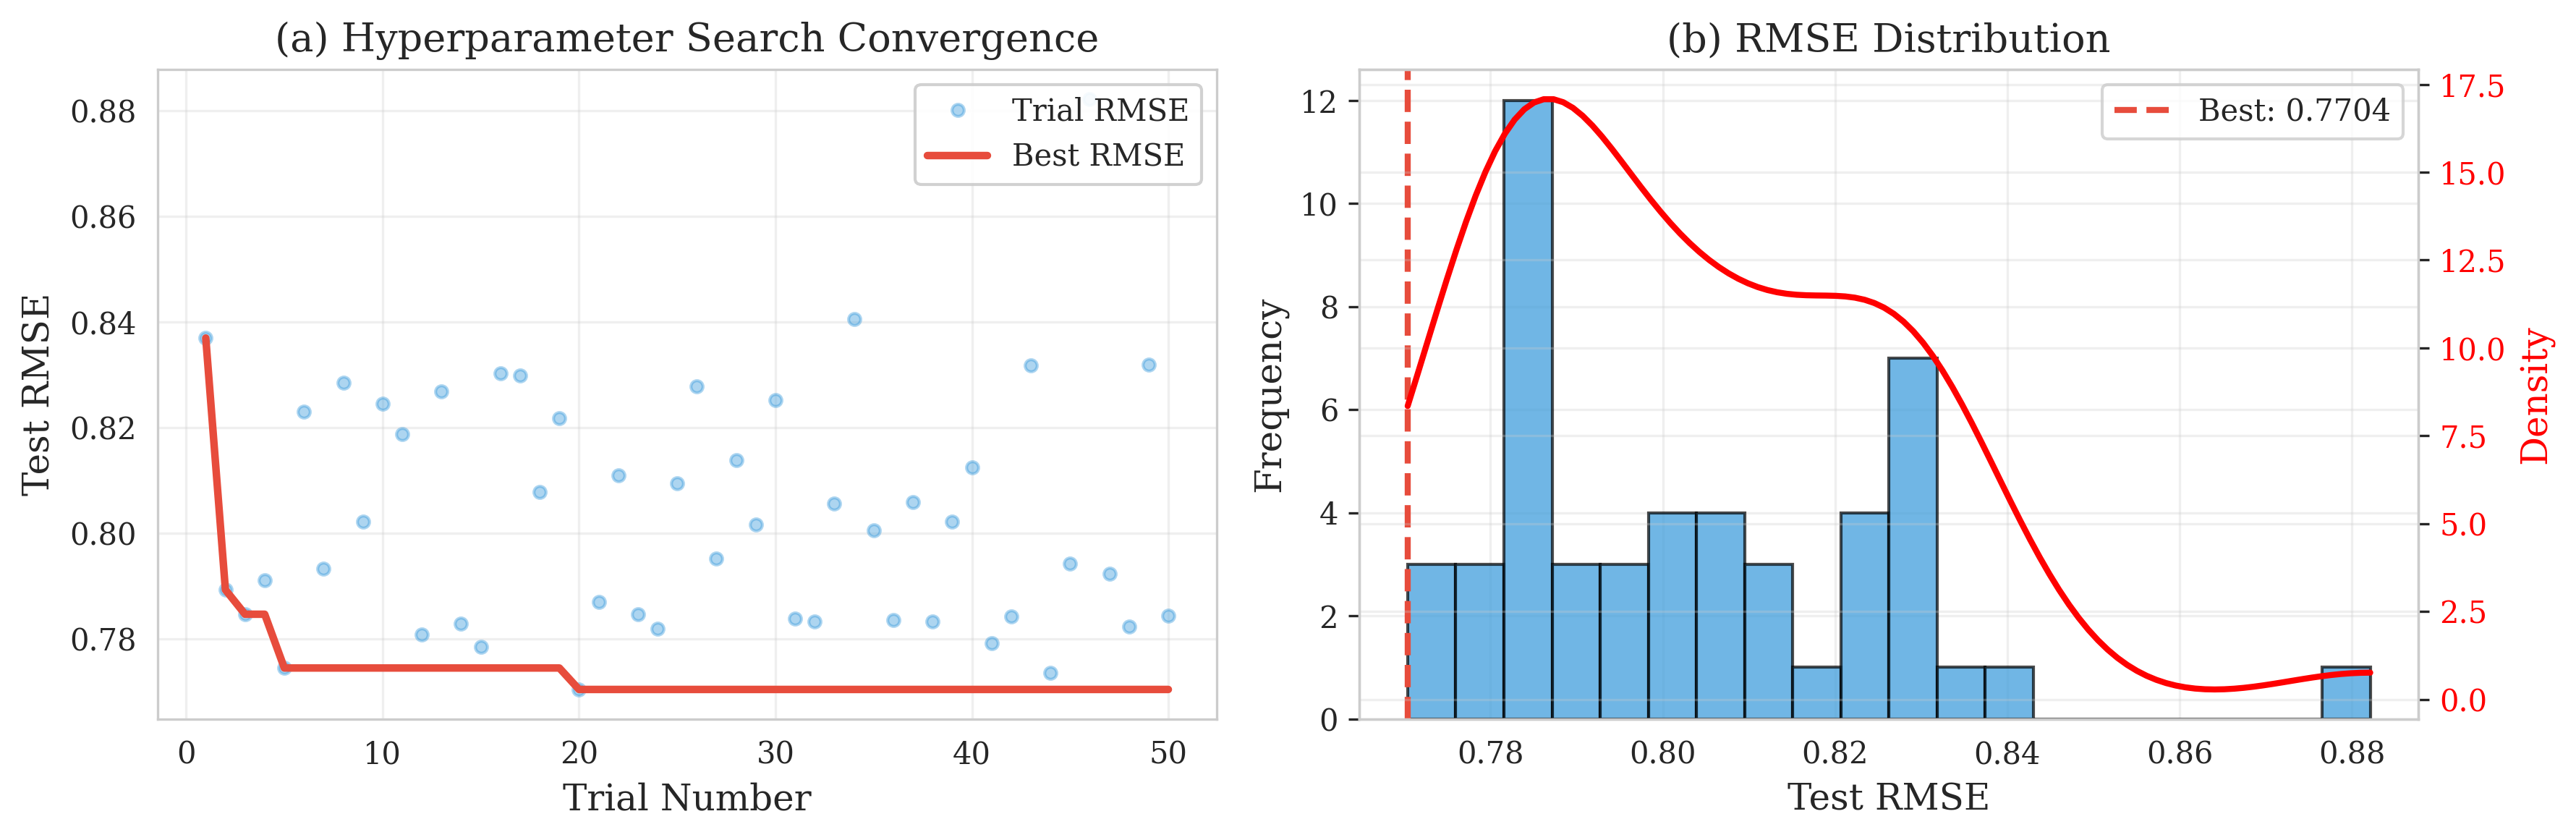

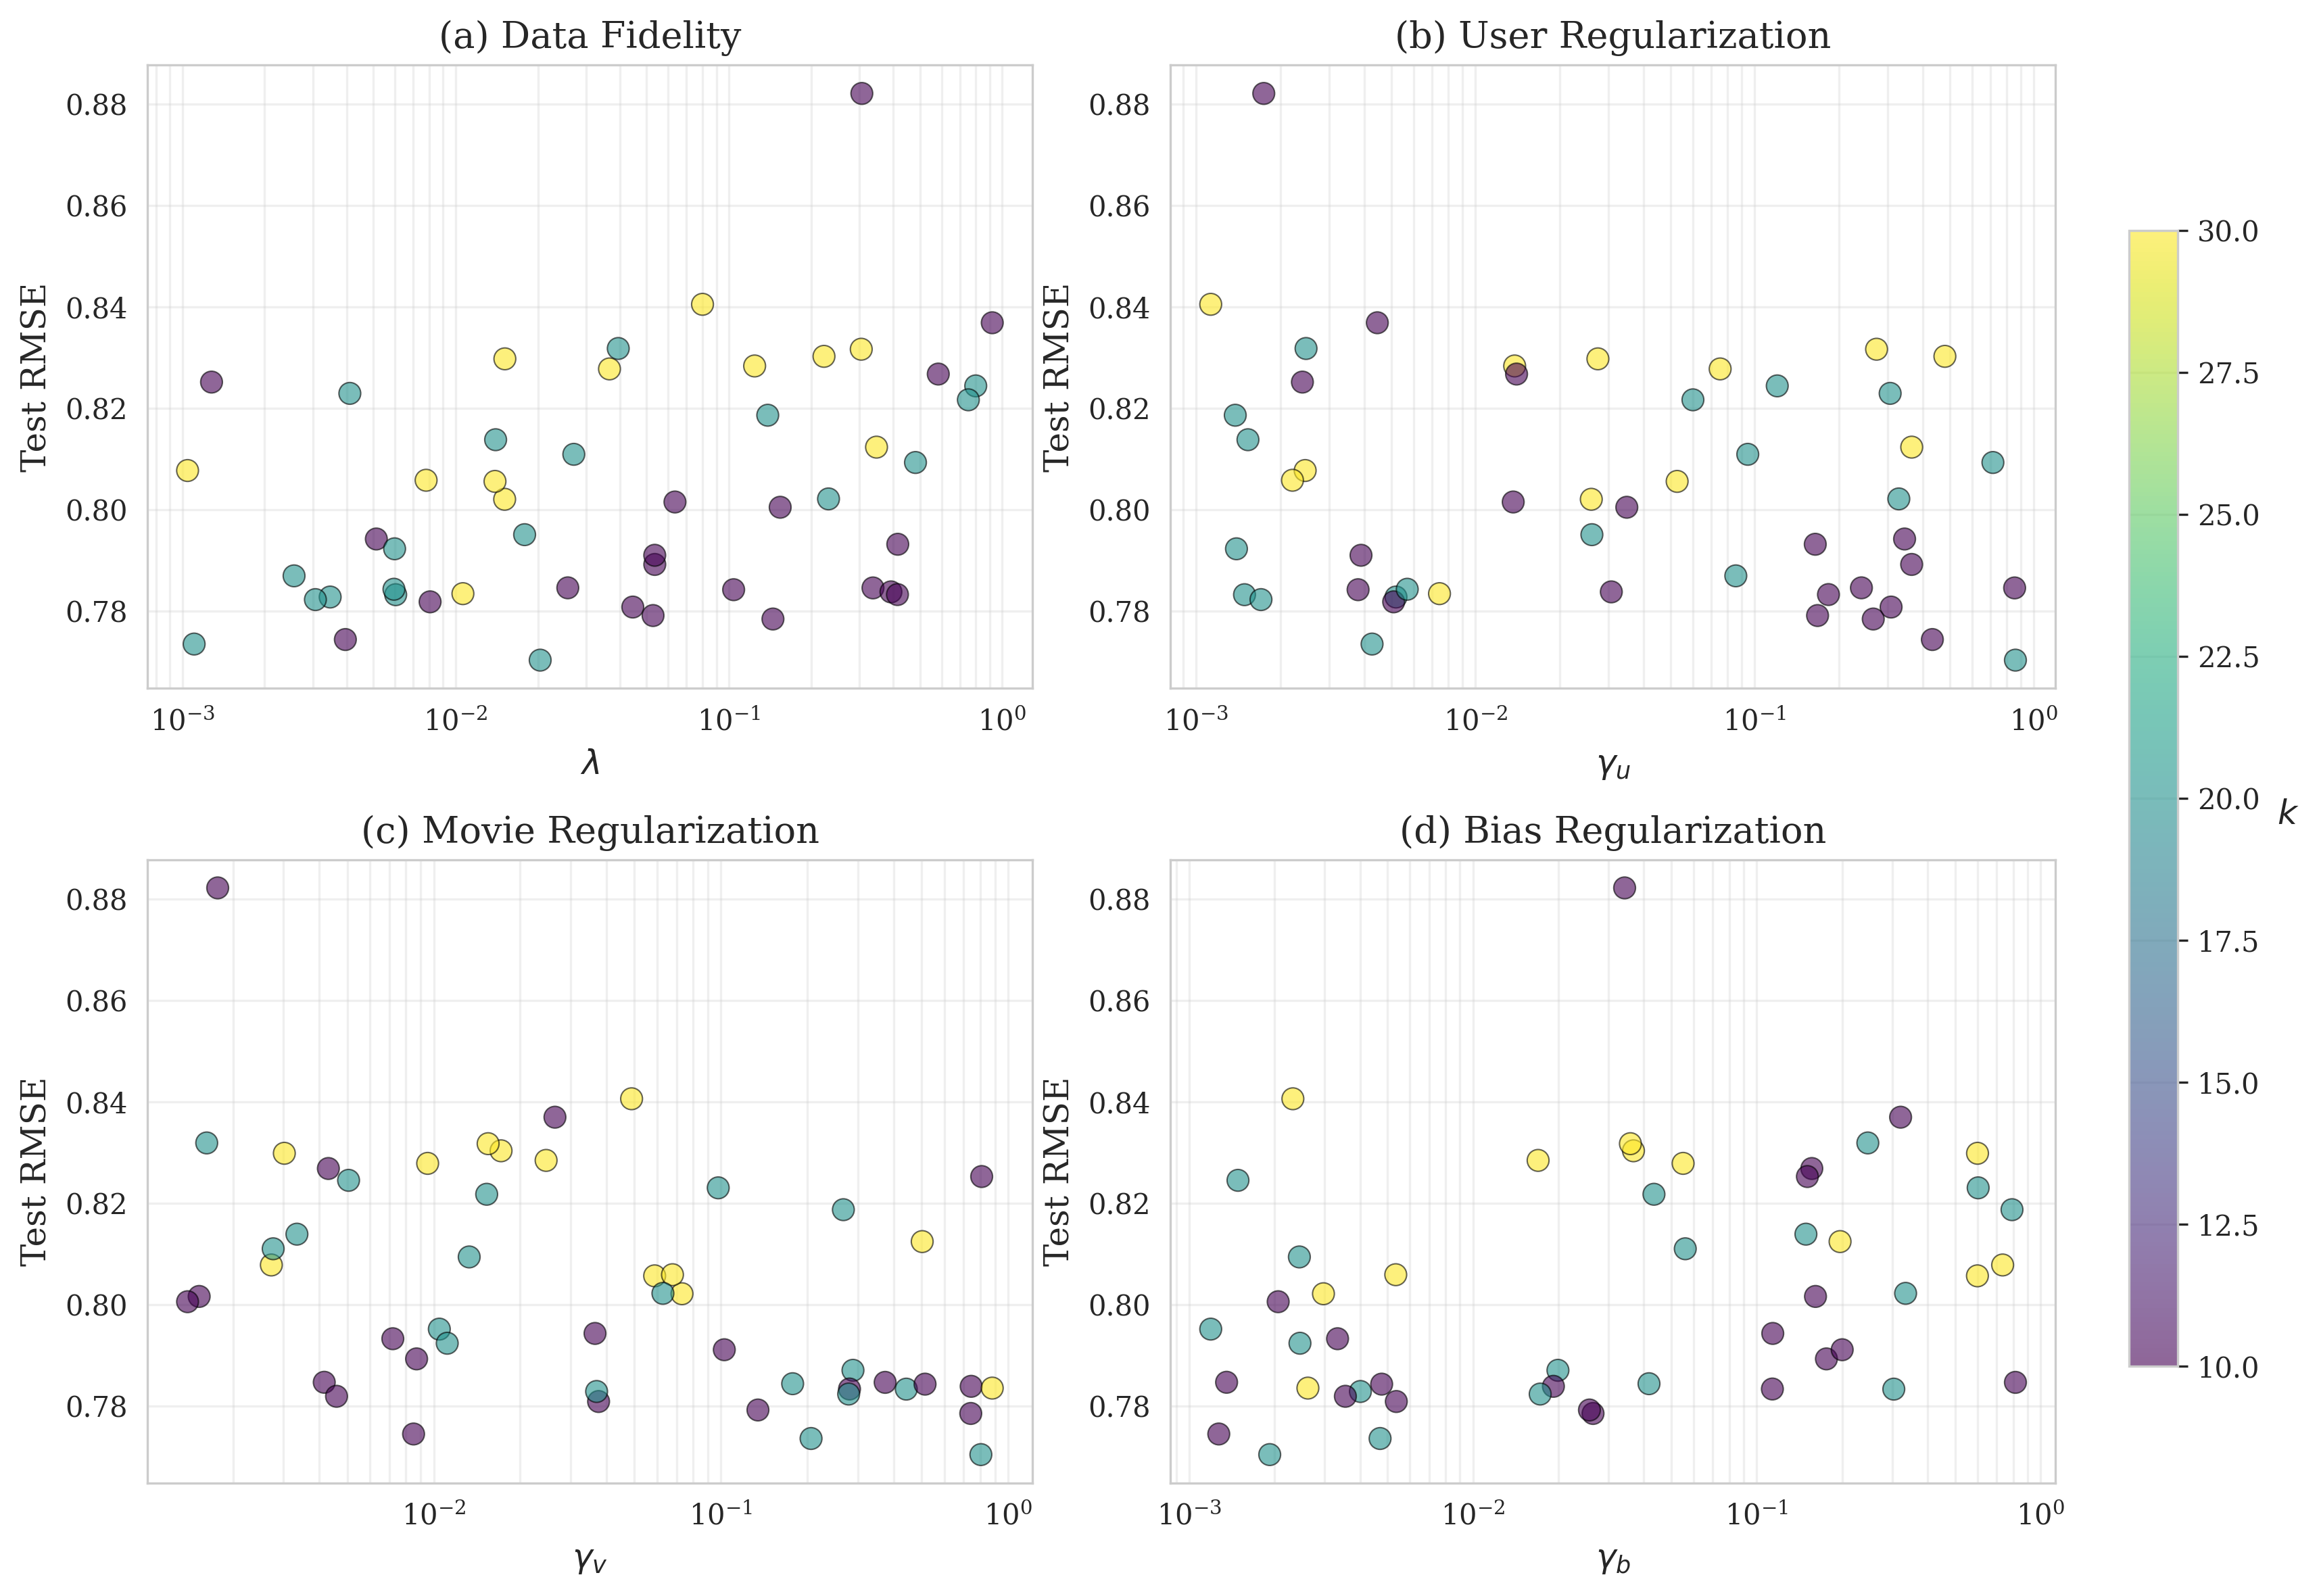


SUMMARY STATISTICS

Best Test RMSE: 0.770391
Mean Test RMSE: 0.803397 +/- 0.022849
Median Test RMSE: 0.801055

Best Configuration:
  k = 20
  lambda = 0.020393
  gamma_u = 0.858755
  gamma_v = 0.803412
  gamma_b = 0.001924

Search Efficiency:
  Total trials: 50
  Average time per trial: 452.32s
  Total search time: 376.93 minutes



In [ ]:
# Set publication-quality style
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
})

# Convergence Analysis (2x1)
fig1, axes = plt.subplots(1, 2, figsize=(12, 4))

# (a) RMSE Convergence
ax = axes[0]
trial_nums = results_df.index + 1
ax.plot(trial_nums, results_df['test_rmse'], 'o', alpha=0.4, markersize=4,
        color='#3498db', label='Trial RMSE')
ax.plot(trial_nums, results_df['test_rmse'].cummin(), '-', linewidth=2.5,
        color='#e74c3c', label='Best RMSE')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Test RMSE')
ax.set_title('(a) Hyperparameter Search Convergence')
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3)

# (b) RMSE Distribution
ax = axes[1]
n, bins, patches = ax.hist(results_df['test_rmse'], bins=20,
                            color='#3498db', alpha=0.7, edgecolor='black')
# KDE overlay
from scipy import stats
kde = stats.gaussian_kde(results_df['test_rmse'])
x_range = np.linspace(results_df['test_rmse'].min(),
                      results_df['test_rmse'].max(), 100)
ax2 = ax.twinx()
ax2.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
ax2.set_ylabel('Density', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Mark best RMSE
best_rmse = results_df['test_rmse'].min()
ax.axvline(best_rmse, color='#e74c3c', linestyle='--', linewidth=2,
           label=f'Best: {best_rmse:.4f}')
ax.set_xlabel('Test RMSE')
ax.set_ylabel('Frequency')
ax.set_title('(b) RMSE Distribution')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('fig_convergence.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig_convergence.png', dpi=300, bbox_inches='tight')
print("Saved: fig_convergence.pdf/png")
plt.show()


# Hyperparameter Impact Analysis

fig, axes = plt.subplots(2, 2, figsize=(12, 8))


# (a) Lambda – Data Fidelity
ax = axes[0, 0]
sc1 = ax.scatter(
    results_df['lamda'],
    results_df['test_rmse'],
    c=results_df['k'],
    cmap='viridis',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax.set_xscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Test RMSE')
ax.set_title('(a) Data Fidelity')
ax.grid(True, alpha=0.3, which='both')

# (b) Gamma_u – User Regularization
ax = axes[0, 1]
sc2 = ax.scatter(
    results_df['gamma_u'],
    results_df['test_rmse'],
    c=results_df['k'],
    cmap='viridis',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax.set_xscale('log')
ax.set_xlabel(r'$\gamma_u$')
ax.set_ylabel('Test RMSE')
ax.set_title('(b) User Regularization')
ax.grid(True, alpha=0.3, which='both')

# (c) Gamma_v – Movie Regularization
ax = axes[1, 0]
sc3 = ax.scatter(
    results_df['gamma_v'],
    results_df['test_rmse'],
    c=results_df['k'],
    cmap='viridis',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax.set_xscale('log')
ax.set_xlabel(r'$\gamma_v$')
ax.set_ylabel('Test RMSE')
ax.set_title('(c) Movie Regularization')
ax.grid(True, alpha=0.3, which='both')

# (d) Gamma_b – Bias Regularization
ax = axes[1, 1]
sc4 = ax.scatter(
    results_df['gamma_b'],
    results_df['test_rmse'],
    c=results_df['k'],
    cmap='viridis',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax.set_xscale('log')
ax.set_xlabel(r'$\gamma_b$')
ax.set_ylabel('Test RMSE')
ax.set_title('(d) Bias Regularization')
ax.grid(True, alpha=0.3, which='both')


plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])

cbar = fig.colorbar(sc4, cax=cbar_ax)
cbar.set_label(r'$k$', rotation=0, labelpad=10)

plt.savefig('fig_hyperparameters_2x2.pdf', dpi=300, bbox_inches='tight')
plt.savefig('fig_hyperparameters_2x2.png', dpi=300, bbox_inches='tight')
plt.show()

# SUMMARY STATISTICS
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nBest Test RMSE: {results_df['test_rmse'].min():.6f}")
print(f"Mean Test RMSE: {results_df['test_rmse'].mean():.6f} +/- {results_df['test_rmse'].std():.6f}")
print(f"Median Test RMSE: {results_df['test_rmse'].median():.6f}")

print("\nBest Configuration:")
best_idx = results_df['test_rmse'].idxmin()
best_config = results_df.loc[best_idx]
print(f"  k = {int(best_config['k'])}")
print(f"  lambda = {best_config['lamda']:.6f}")
print(f"  gamma_u = {best_config['gamma_u']:.6f}")
print(f"  gamma_v = {best_config['gamma_v']:.6f}")
print(f"  gamma_b = {best_config['gamma_b']:.6f}")

print(f"\nSearch Efficiency:")
print(f"  Total trials: {len(results_df)}")
print(f"  Average time per trial: {results_df['time_seconds'].mean():.2f}s")
print(f"  Total search time: {results_df['time_seconds'].sum()/60:.2f} minutes")

print("\n" + "="*80)

## Query Functions:

In [ ]:
# Query methods

def get_user_ratings(self, userid):
    if userid not in self.userid_to_idx:
        return 0, []
    user_idx = self.userid_to_idx[userid]
    start = self.user_ptr[user_idx]
    end = self.user_ptr[user_idx + 1]
    movie_indices = self.csr_col_indices[start:end]
    ratings = self.csr_values[start:end]
    user_ratings = [(self.idx_to_movieid[m], float(r)) for m, r in zip(movie_indices, ratings)]
    return len(user_ratings), user_ratings

def get_movie_ratings(self, movieid):
    if movieid not in self.movieid_to_idx:
        return 0, []
    movie_idx = self.movieid_to_idx[movieid]
    start = self.movie_ptr[movie_idx]
    end = self.movie_ptr[movie_idx + 1]
    user_indices = self.csc_row_indices[start:end]
    ratings = self.csc_values[start:end]
    movie_ratings = [(self.idx_to_userid[u], float(r)) for u, r in zip(user_indices, ratings)]
    return len(movie_ratings), movie_ratings

def get_ratings(self, userid, movieid):
    if userid not in self.userid_to_idx or movieid not in self.movieid_to_idx:
        return 0
    user_idx = self.userid_to_idx[userid]
    movie_idx = self.movieid_to_idx[movieid]
    start = self.user_ptr[user_idx]
    end = self.user_ptr[user_idx + 1]
    movies = self.csr_col_indices[start:end]
    ratings = self.csr_values[start:end]
    idx = np.where(movies == movie_idx)[0]
    if len(idx) > 0:
        return float(ratings[idx[0]])
    return 0


## Training Functions

In [ ]:

def compute_loss(ratings_matrix, U, V, b_u, b_m, lamda, gamma_u, gamma_v, gamma_b, train=True):
    """
    Wrapper calling the Numba optimized loss function.
    """
    if train:
        user_ptr = ratings_matrix.user_ptr_train
        col_indices = ratings_matrix.csr_col_indices_train
        values = ratings_matrix.csr_values_train
    else:
        user_ptr = ratings_matrix.user_ptr_test
        col_indices = ratings_matrix.csr_col_indices_test
        values = ratings_matrix.csr_values_test

    return _numba_compute_loss(
        user_ptr, col_indices, values,
        U, V, b_u, b_m,
        lamda, gamma_u, gamma_v, gamma_b
    )


def train_als(ratings_matrix, k=30, lamda=0.001, gamma_u=0.05, gamma_v=0.05,
              gamma_b=0.001, iterations=10):
    """
    Optimized ALS training.
    Outer loop: Python (controls flow).
    Inner loops: Numba (controls math/iteration).
    """

    print("Initializing Parameters...")
    # Initialize parameters
    user_biases = np.zeros(ratings_matrix.number_of_users, dtype=np.float64)
    movie_biases = np.zeros(ratings_matrix.number_of_movies, dtype=np.float64)

    # Scaled initialization
    user_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_users)).astype(np.float64)
    movie_embeddings = np.random.normal(0, 0.1, size=(k, ratings_matrix.number_of_movies)).astype(np.float64)

    # For plotting
    loss_history = []
    rmse_history = []
    rmse_test_history = []

    # Pre-fetch arrays to pass to Numba
    # User/CSR data
    user_ptr = ratings_matrix.user_ptr_train
    csr_cols = ratings_matrix.csr_col_indices_train
    csr_vals = ratings_matrix.csr_values_train

    # Movie/CSC data
    movie_ptr = ratings_matrix.movie_ptr_train
    csc_rows = ratings_matrix.csc_row_indices_train
    csc_vals = ratings_matrix.csc_values_train

    print(f"Starting {iterations} iterations of ALS (Numba Optimized)...")
    start_total = time.time()

    for iteration in range(iterations):
        iter_start = time.time()

        # 1. Update Users (Parallel Numba)
        _numba_update_users(
            user_ptr, csr_cols, csr_vals,
            user_embeddings, movie_embeddings, user_biases, movie_biases,
            k, lamda, gamma_u, gamma_b
        )

        # 2. Update Movies (Parallel Numba)
        _numba_update_movies(
            movie_ptr, csc_rows, csc_vals,
            user_embeddings, movie_embeddings, user_biases, movie_biases,
            k, lamda, gamma_v, gamma_b
        )

        # 3. Compute Loss (Parallel Numba)
        loss_train, rmse_train = compute_loss(
            ratings_matrix, user_embeddings, movie_embeddings,
            user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=True
        )

        loss_test, rmse_test = compute_loss(
            ratings_matrix, user_embeddings, movie_embeddings,
            user_biases, movie_biases, lamda, gamma_u, gamma_v, gamma_b, train=False
        )

        iter_time = time.time() - iter_start
        print(f"Iteration {iteration+1}/{iterations} [{iter_time:.2f}s]:\n "
              f"Train RMSE = {rmse_train:.4f}, Train Loss = {loss_train:.4f} \n "
              f"Test  RMSE = {rmse_test:.4f}, Test  Loss = {loss_test:.4f}\n")

        loss_history.append(loss_train)
        rmse_history.append(rmse_train)
        rmse_test_history.append(rmse_test)

    total_time = time.time() - start_total

    # Print summary statistics
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total Training Time: {total_time:.2f}s")
    print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
    print(f"Final Test RMSE:  {rmse_test_history[-1]:.4f}")
    print(f"Train Improvement: {((rmse_history[0] - rmse_history[-1])/rmse_history[0]*100):.2f}%")
    print(f"Test Improvement:  {((rmse_test_history[0] - rmse_test_history[-1])/rmse_test_history[0]*100):.2f}%")
    print(f"Generalization Gap: {(rmse_test_history[-1] - rmse_history[-1]):.4f}")
    print("="*60)

    return user_embeddings, movie_embeddings, user_biases, movie_biases, loss_history, rmse_history, rmse_test_history

In [ ]:
def plot_training_results(loss_history, rmse_history, rmse_test_history):

    iterations = np.arange(1, len(loss_history) + 1)

    # LOSS OVER ITERATIONS
    plt.figure(figsize=(10, 6))

    plt.plot(iterations, loss_history, marker='o', linewidth=2.5, markersize=7,
             color='steelblue', label='Training Loss', alpha=0.8)

    plt.title("Training Loss over Iterations", fontsize=14, fontweight='bold')
    plt.xlabel("Iteration", fontsize=12, fontweight='bold')
    plt.ylabel("Loss", fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=11)

    plt.annotate(f'Start: {loss_history[0]:.4f}',
                xy=(1, loss_history[0]),
                xytext=(10, 15), textcoords='offset points',
                fontsize=10, color='steelblue', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='steelblue'))

    plt.annotate(f'Final: {loss_history[-1]:.4f}',
                xy=(len(loss_history), loss_history[-1]),
                xytext=(-60, -20), textcoords='offset points',
                fontsize=10, color='steelblue', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7),
                arrowprops=dict(arrowstyle='->', color='steelblue'))


    plt.tight_layout()
    plt.savefig('loss.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # TRAIN VS TEST RMSE (OVERFITTING ANALYSIS)
    plt.figure(figsize=(12, 7))

    # Plot train and test RMSE
    plt.plot(iterations, rmse_history, marker='o', linewidth=2.5, markersize=7,
             color='darkorange', label='Train RMSE', alpha=0.8)
    plt.plot(iterations, rmse_test_history, marker='s', linewidth=2.5, markersize=7,
             color='forestgreen', label='Test RMSE', alpha=0.8)

    # Fill the gap between train and test to show overfitting
    plt.fill_between(iterations, rmse_history, rmse_test_history,
                     where=(np.array(rmse_test_history) >= np.array(rmse_history)),
                     alpha=0.2, color='red', label='Generalization Gap')

    # Calculate gaps and improvements
    final_gap = rmse_test_history[-1] - rmse_history[-1]
    final_gap_pct = (final_gap / rmse_test_history[-1]) * 100
    improvement_train = ((rmse_history[0] - rmse_history[-1]) / rmse_history[0]) * 100
    improvement_test = ((rmse_test_history[0] - rmse_test_history[-1]) / rmse_test_history[0]) * 100

    # Annotations for final values
    plt.annotate(f'Train: {rmse_history[-1]:.4f}',
                xy=(len(rmse_history), rmse_history[-1]),
                xytext=(15, -20), textcoords='offset points',
                fontsize=10, color='darkorange', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='darkorange', lw=1.5))

    plt.annotate(f'Test: {rmse_test_history[-1]:.4f}',
                xy=(len(rmse_test_history), rmse_test_history[-1]),
                xytext=(15, 15), textcoords='offset points',
                fontsize=10, color='forestgreen', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='forestgreen', lw=1.5))

    # Title and labels
    plt.title("Train vs Test RMSE over Iterations", fontsize=14, fontweight='bold')
    plt.xlabel("Iteration", fontsize=12, fontweight='bold')
    plt.ylabel("RMSE", fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper right', fontsize=11)

    plt.tight_layout()
    plt.savefig('rmse.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()



## Training

In [ ]:
if __name__ == "__main__":
    try:
        k = 20
        lamda = 0.02039307537342147
        gamma_u = 0.8587551700375037
        gamma_v = 0.8034116286188123
        gamma_b = 0.00192377578961482
        iterations = 20

        # Train
        user_embeddings, movie_embeddings, user_biases, movie_biases, \
            loss_history, rmse_history, rmse_test_history = train_als(
                ratings_matrix, k=k, lamda=lamda, gamma_u=gamma_u, gamma_v=gamma_v,
                gamma_b=gamma_b, iterations=iterations
            )

    except OSError:
        print("Error: 'ratings.csv' not found. Please ensure the file is in the working directory.")

Initializing Parameters...
Starting 20 iterations of ALS (Numba Optimized)...
Iteration 1/20 [9.34s]:
 Train RMSE = 0.8422, Train Loss = 215551.6005 
 Test  RMSE = 0.8651, Test  Loss = 31699.2007

Iteration 2/20 [5.04s]:
 Train RMSE = 0.7496, Train Loss = 183052.9001 
 Test  RMSE = 0.8099, Test  Loss = 39443.2848

Iteration 3/20 [5.07s]:
 Train RMSE = 0.7246, Train Loss = 175899.1977 
 Test  RMSE = 0.7898, Test  Loss = 42063.1489

Iteration 4/20 [5.12s]:
 Train RMSE = 0.7158, Train Loss = 173557.4337 
 Test  RMSE = 0.7817, Test  Loss = 43046.3391

Iteration 5/20 [5.06s]:
 Train RMSE = 0.7115, Train Loss = 172461.5454 
 Test  RMSE = 0.7777, Test  Loss = 43543.2070

Iteration 6/20 [5.17s]:
 Train RMSE = 0.7090, Train Loss = 171839.7079 
 Test  RMSE = 0.7753, Test  Loss = 43837.7785

Iteration 7/20 [5.21s]:
 Train RMSE = 0.7074, Train Loss = 171450.5084 
 Test  RMSE = 0.7738, Test  Loss = 44028.4187

Iteration 8/20 [5.06s]:
 Train RMSE = 0.7064, Train Loss = 171194.5972 
 Test  RMSE = 0.7

In [ ]:
plot_training_results(loss_history, rmse_history, rmse_test_history)


# Testing Recommendation for a Dummy User

In [ ]:
# Load movies metadata
try:
    df2 = pd.read_csv('movies.csv')
except FileNotFoundError:
    print("Warning: 'movies.csv' not found. Creating dummy dataframe.")
    df2 = pd.DataFrame({'movieId': range(10000), 'title': ['Movie']*10000, 'genres': ['Drama']*10000})

In [ ]:
@njit(fastmath=True)
def _numba_dummy_train_kernel(movie_indices, rating_values, V, b_m,
                              lamda, gamma_u, gamma_b, k, iterations):
    """
    Numba kernel to train a single user vector.
    FIX: Replaced try-except with direct np.linalg.lstsq for stability.
    """
    # Initialize random embedding
    dummy_user_embedding = np.random.normal(0, 0.1, size=(k,)).astype(np.float64)
    dummy_bias = 0.0
    n_ratings = len(movie_indices)

    # Pre-allocate identity matrix scaled by gamma_u
    eye_k = np.eye(k, dtype=np.float64) * gamma_u

    for _ in range(iterations):
        # 1. Update Bias
        bias_sum = 0.0
        for i in range(n_ratings):
            m_idx = movie_indices[i]
            r = rating_values[i]

            # Dot product: dummy_emb @ V[:, m_idx]
            dot_val = 0.0
            for f in range(k):
                dot_val += dummy_user_embedding[f] * V[f, m_idx]

            pred = b_m[m_idx] + dot_val
            bias_sum += lamda * (r - pred)

        dummy_bias = bias_sum / (lamda * n_ratings + gamma_b)

        # 2. Update Embedding
        first_term = eye_k.copy()
        second_term = np.zeros(k, dtype=np.float64)

        for i in range(n_ratings):
            m_idx = movie_indices[i]
            r = rating_values[i]

            # Update second term: v_n * (rating - bias - b_m)
            residual = r - dummy_bias - b_m[m_idx]

            # Manual outer product accumulation for speed
            factor = lamda
            for r_idx in range(k):
                v_r = V[r_idx, m_idx]
                second_term[r_idx] += factor * v_r * residual

                for c_idx in range(k):
                    first_term[r_idx, c_idx] += factor * v_r * V[c_idx, m_idx]

        # FIX: Use lstsq directly. It handles both singular and non-singular matrices.
        # rcond=-1 tells LAPACK to use machine precision default
        dummy_user_embedding = np.linalg.lstsq(first_term, second_term, rcond=-1)[0]

    return dummy_user_embedding, dummy_bias


@njit(parallel=True, fastmath=True)
def _numba_calculate_scores(dummy_emb, V, dummy_bias, b_m, movie_ptr):
    """
    Calculates scores for all movies in parallel.
    """
    n_movies = V.shape[1]
    k = V.shape[0]
    scores = np.zeros(n_movies, dtype=np.float64)

    for m in prange(n_movies):
        # Check rating count using the pointer structure
        count = movie_ptr[m+1] - movie_ptr[m]

        if count < 100:
            scores[m] = 0.0
        else:
            # Dot product
            dot_val = 0.0
            for f in range(k):
                dot_val += dummy_emb[f] * V[f, m]

            scores[m] = dot_val + (b_m[m] * 0.05)

    return scores


@njit(parallel=True, fastmath=True)
def _numba_calc_norms(V):
    """Calculate L2 norm of every movie column"""
    n_movies = V.shape[1]
    norms = np.zeros(n_movies, dtype=np.float64)
    for m in prange(n_movies):
        col_sum = 0.0
        for f in range(V.shape[0]):
            val = V[f, m]
            col_sum += val * val
        norms[m] = np.sqrt(col_sum)
    return norms



In [ ]:
def dummy_user_train(dummy_user_ratings, movie_embeddings, movie_biases, lamda, gamma_u, gamma_b, k=10, iterations=10):
    if len(dummy_user_ratings) == 0:
        return np.zeros(k), 0.0

    # Convert inputs to Numba-friendly arrays
    indices = np.array([x[0] for x in dummy_user_ratings], dtype=np.int32)
    values = np.array([x[1] for x in dummy_user_ratings], dtype=np.float64)

    return _numba_dummy_train_kernel(
        indices, values, movie_embeddings, movie_biases,
        lamda, gamma_u, gamma_b, k, iterations
    )

def dummy_user_recommendation(dummy_user_embedding, movie_embeddings, dummy_bias, movie_biases):
    # Use movie_ptr from global 'ratings_matrix' for counts
    score = _numba_calculate_scores(
        dummy_user_embedding,
        movie_embeddings,
        dummy_bias,
        movie_biases,
        ratings_matrix.movie_ptr
    )

    ranked_items = np.argsort(score)[::-1]
    return score, ranked_items



In [ ]:
# EXECUTION

# 1. Setup Dummy User
dummy_movie_ids = [4896]  #
dummy_ratings = [5.0]
dummy_movie_idx = []
dummy_user_ratings = []
n_rec = 15

for id, rating in zip(dummy_movie_ids, dummy_ratings):
    if id in ratings_matrix.movieid_to_idx:
        mov_idx = ratings_matrix.movieid_to_idx[id]
        dummy_movie_idx.append(mov_idx)
        dummy_user_ratings.append((mov_idx, rating))

# 2. Train
dummy_user_embidding, dummy_bias = dummy_user_train(
    dummy_user_ratings,
    movie_embeddings,
    movie_biases,
    lamda=lamda,
    gamma_u=gamma_u,
    gamma_b=gamma_b,
    k=k,
    iterations=iterations
)

# 3. Predict
score, ranked_items = dummy_user_recommendation(dummy_user_embidding, movie_embeddings, dummy_bias, movie_biases)

# 4. Filter & Display Recommendations
top_recommendations = []
for i in range(len(ranked_items)):
    if ranked_items[i] not in dummy_movie_idx:
        top_recommendations.append(ranked_items[i])
    if len(top_recommendations) >= n_rec:
        break

print("\n" + "="*60)
print("RECOMMENDATION RESULTS")
print("="*60)
for i in range(len(top_recommendations)):
    rec_idx = top_recommendations[i]
    rec_id = ratings_matrix.idx_to_movieid[rec_idx]
    try:
        row = df2[df2['movieId'] == rec_id][['title', 'genres']].values[0]
        print(f"{i+1}. {row[0]} ({row[1]})")
    except IndexError:
        print(f"{i+1}. Movie ID {rec_id} (Title Not Found)")
print("\n" + "="*60)
print("DEBUGGING DUMMY USER")
print("="*60)

print("\nRated Movies:")
for movie_id in dummy_movie_ids:
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]} ({row[1]})")
    except:
        pass

print(f"\nDummy user embedding norm: {np.linalg.norm(dummy_user_embidding):.4f}")
print(f"Dummy user bias: {dummy_bias:.4f}")

print(f"\nScore statistics:")
print(f"  Min: {score.min():.4f}, Max: {score.max():.4f}, Mean: {score.mean():.4f}")




RECOMMENDATION RESULTS
1. Harry Potter and the Prisoner of Azkaban (2004) (Adventure|Fantasy|IMAX)
2. Harry Potter and the Chamber of Secrets (2002) (Adventure|Fantasy)
3. Harry Potter and the Half-Blood Prince (2009) (Adventure|Fantasy|Mystery|Romance|IMAX)
4. Harry Potter and the Goblet of Fire (2005) (Adventure|Fantasy|Thriller|IMAX)
5. Harry Potter and the Deathly Hallows: Part 2 (2011) (Action|Adventure|Drama|Fantasy|Mystery|IMAX)
6. Harry Potter and the Order of the Phoenix (2007) (Adventure|Drama|Fantasy|IMAX)
7. Harry Potter and the Deathly Hallows: Part 1 (2010) (Action|Adventure|Fantasy|IMAX)
8. Lord of the Rings: The Fellowship of the Ring, The (2001) (Adventure|Fantasy)
9. Lord of the Rings: The Two Towers, The (2002) (Adventure|Fantasy)
10. Lord of the Rings: The Return of the King, The (2003) (Action|Adventure|Drama|Fantasy)
11. Willy Wonka & the Chocolate Factory (1971) (Children|Comedy|Fantasy|Musical)
12. Batman (1989) (Action|Crime|Thriller)
13. Batman Forever (1995)

## Polarizing Movies

### Most Polarizing

In [ ]:
# POLARIZING MOVIES

print("\n" + "="*60)
print("POLARIZING MOVIES")
print("="*60)

n_polorizing_movies = 30
norms = _numba_calc_norms(movie_embeddings)
movies_idx_sorted_by_norm = np.argsort(norms)[::-1]
polorizing_movies_id = [ratings_matrix.idx_to_movieid[idx] for idx in movies_idx_sorted_by_norm[:n_polorizing_movies]]

for movie_id in polorizing_movies_id:
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]} ({row[1]})")
    except IndexError:
        pass


POLARIZING MOVIES
Lord of the Rings: The Fellowship of the Ring, The (2001) (Adventure|Fantasy)
Lord of the Rings: The Return of the King, The (2003) (Action|Adventure|Drama|Fantasy)
Lord of the Rings: The Two Towers, The (2002) (Adventure|Fantasy)
Star Wars: Episode IV - A New Hope (1977) (Action|Adventure|Sci-Fi)
Pulp Fiction (1994) (Comedy|Crime|Drama|Thriller)
Star Wars: Episode V - The Empire Strikes Back (1980) (Action|Adventure|Sci-Fi)
Dumb & Dumber (Dumb and Dumber) (1994) (Adventure|Comedy)
Star Wars: Episode VI - Return of the Jedi (1983) (Action|Adventure|Sci-Fi)
Matrix, The (1999) (Action|Sci-Fi|Thriller)
Kill Bill: Vol. 1 (2003) (Action|Crime|Thriller)
Natural Born Killers (1994) (Action|Crime|Thriller)
Star Wars: Episode I - The Phantom Menace (1999) (Action|Adventure|Sci-Fi)
Ace Ventura: Pet Detective (1994) (Comedy)
Kill Bill: Vol. 2 (2004) (Action|Drama|Thriller)
Blair Witch Project, The (1999) (Drama|Horror|Thriller)
Forrest Gump (1994) (Comedy|Drama|Romance|War)
Sil

### Least Polarizing

In [ ]:
n_least_polarizing_movies = 10

# Get indices sorted by norm
least_polarizing_idx = np.argsort(norms)[:n_least_polarizing_movies]

print("LEAST POLARIZING MOVIES (Smallest embedding norms):")
print("-" * 80)

for idx in least_polarizing_idx:
    movie_id = ratings_matrix.idx_to_movieid[idx]
    try:
        row = df2[df2['movieId'] == movie_id][['title', 'genres']].values[0]
        print(f"{row[0]:<50} | {row[1]:<30} | Norm: {norms[idx]:.4f}")
    except IndexError:
        continue

LEAST POLARIZING MOVIES (Smallest embedding norms):
--------------------------------------------------------------------------------
Chie the Brat (1981)                               | Animation|Children|Comedy|Drama | Norm: 0.0000
The Auteur (2008)                                  | Comedy                         | Norm: 0.0000
Permanent Nobara (2010)                            | Comedy|Drama|Romance           | Norm: 0.0000
My Ordinary Love Story (2014)                      | (no genres listed)             | Norm: 0.0000
Laundry (2002)                                     | Drama|Romance                  | Norm: 0.0000
Sorokin Trip (2019)                                | Documentary                    | Norm: 0.0000
Winter Meeting (1948)                              | Drama|Romance                  | Norm: 0.0000
Hormones (2008)                                    | Comedy|Drama|Romance           | Norm: 0.0000
Marfa Girl 2 (2018)                                | Drama                

## PCA visualization

### PCA for Movie Embeddings

In [ ]:
# NUMBA KERNELS (Standardization & PCA)

@njit(parallel=True)
def _numba_standard_scaler(data):
    n_samples, n_features = data.shape
    scaled = np.empty_like(data)

    for j in prange(n_features):
        # 1. Compute Mean/Std
        col_sum = 0.0
        col_sq_sum = 0.0
        for i in range(n_samples):
            col_sum += data[i, j]
            col_sq_sum += data[i, j]**2

        mean = col_sum / n_samples
        # Population variance (StandardScaler default)
        var = (col_sq_sum / n_samples) - (mean * mean)
        std = np.sqrt(var) if var > 0 else 1.0

        # 2. Normalize
        for i in range(n_samples):
            scaled[i, j] = (data[i, j] - mean) / std

    return scaled

@njit
def _numba_pca_2d(data):
    n_samples = data.shape[0]
    # Sample Covariance Matrix
    cov = (data.T @ data) / (n_samples - 1)

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # Sort descending
    idx = np.argsort(eig_vals)[::-1]
    components = eig_vecs[:, idx[:2]]

    return data @ components


@njit(parallel=True)
def get_movie_counts_numba(movie_ptr):
    """
    Fast calculation of rating counts per movie using the CSC pointers.
    """
    n_movies = len(movie_ptr) - 1
    counts = np.zeros(n_movies, dtype=np.int32)

    for m in prange(n_movies):
        counts[m] = movie_ptr[m+1] - movie_ptr[m]

    return counts



Original Data Shape: (20, 84432)
Reduced Data Shape: (84432, 2)



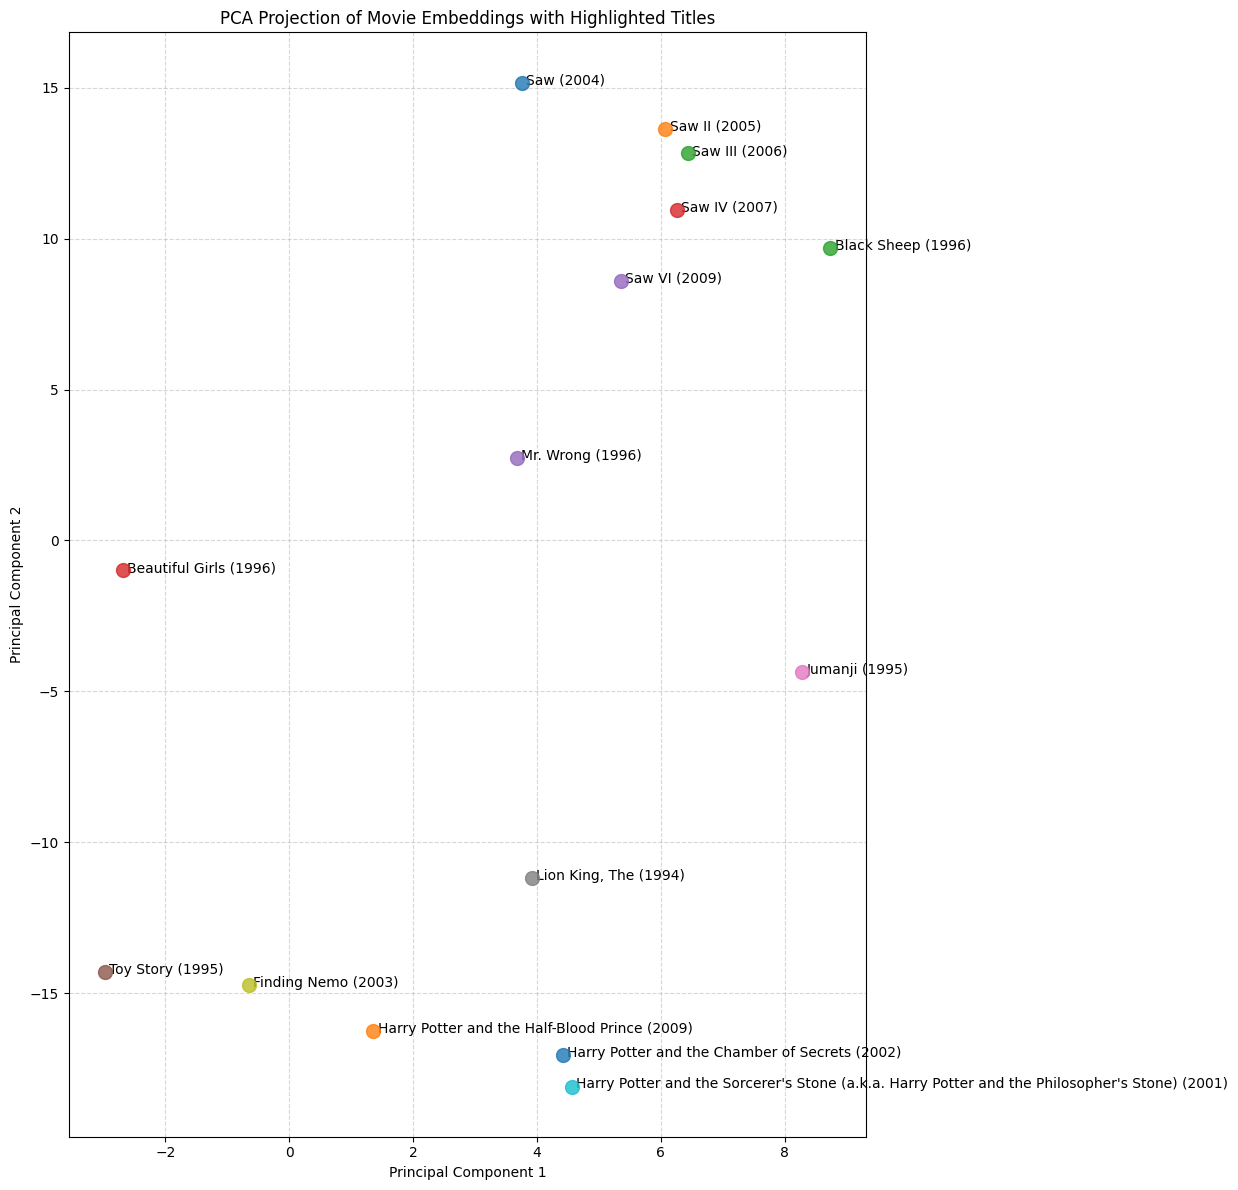

In [ ]:
# EXECUTION & PLOTTING

# 1. Transpose (Users as features, Movies as samples for the plot)
X_input = movie_embeddings.T

# 2. Standardize (Numba)
Standarized_movie_embeddings = _numba_standard_scaler(X_input)

# 3. PCA (Numba)
movie_embeddings_2D = _numba_pca_2d(Standarized_movie_embeddings)

print("Original Data Shape:", movie_embeddings.shape)
print("Reduced Data Shape:", movie_embeddings_2D.shape)
print()

# 4. Plotting
movie_ids_plot = [8957, 39446, 48877, 55577, 72129, 1, 2, 364, 6377, 4896, 5816, 69844, 88, 94, 102]

plt.figure(figsize=(12, 12))
plt.title("PCA Projection of Movie Embeddings with Highlighted Titles")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)

offset = 0.07

# Iterate and Plot
for movie in movie_ids_plot:
    if movie in ratings_matrix.movieid_to_idx:
        movie_idx_plot = ratings_matrix.movieid_to_idx[movie]

        movie_x = movie_embeddings_2D[movie_idx_plot, 0]
        movie_y = movie_embeddings_2D[movie_idx_plot, 1]

        plt.scatter(movie_x, movie_y, s=100, alpha=0.8, zorder=5)

        # Retrieve Title safely
        try:
            row = df2[df2['movieId'] == movie][['title']].values[0][0]
            plt.annotate(
                row,
                (movie_x, movie_y),
                xytext=(movie_x + offset, movie_y + offset),
                fontsize=10,
                textcoords='data',
                ha='left',
                va='center'
            )
        except IndexError:
            print(f"Title not found for ID {movie}")

plt.tight_layout()
plt.savefig('pca_movies.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### PCA for Some Genres:

1. Sorting movies by popularity...
2. Collecting top 100 movies for: ['Children', 'Horror', 'Comedy', 'Documentary']...
   Found 100 movies for 'Children'
   Found 100 movies for 'Horror'
   Found 100 movies for 'Comedy'
   Found 100 movies for 'Documentary'
3. Running Numba PCA on shape (400, 20)...
4. Generating PCA Plot...


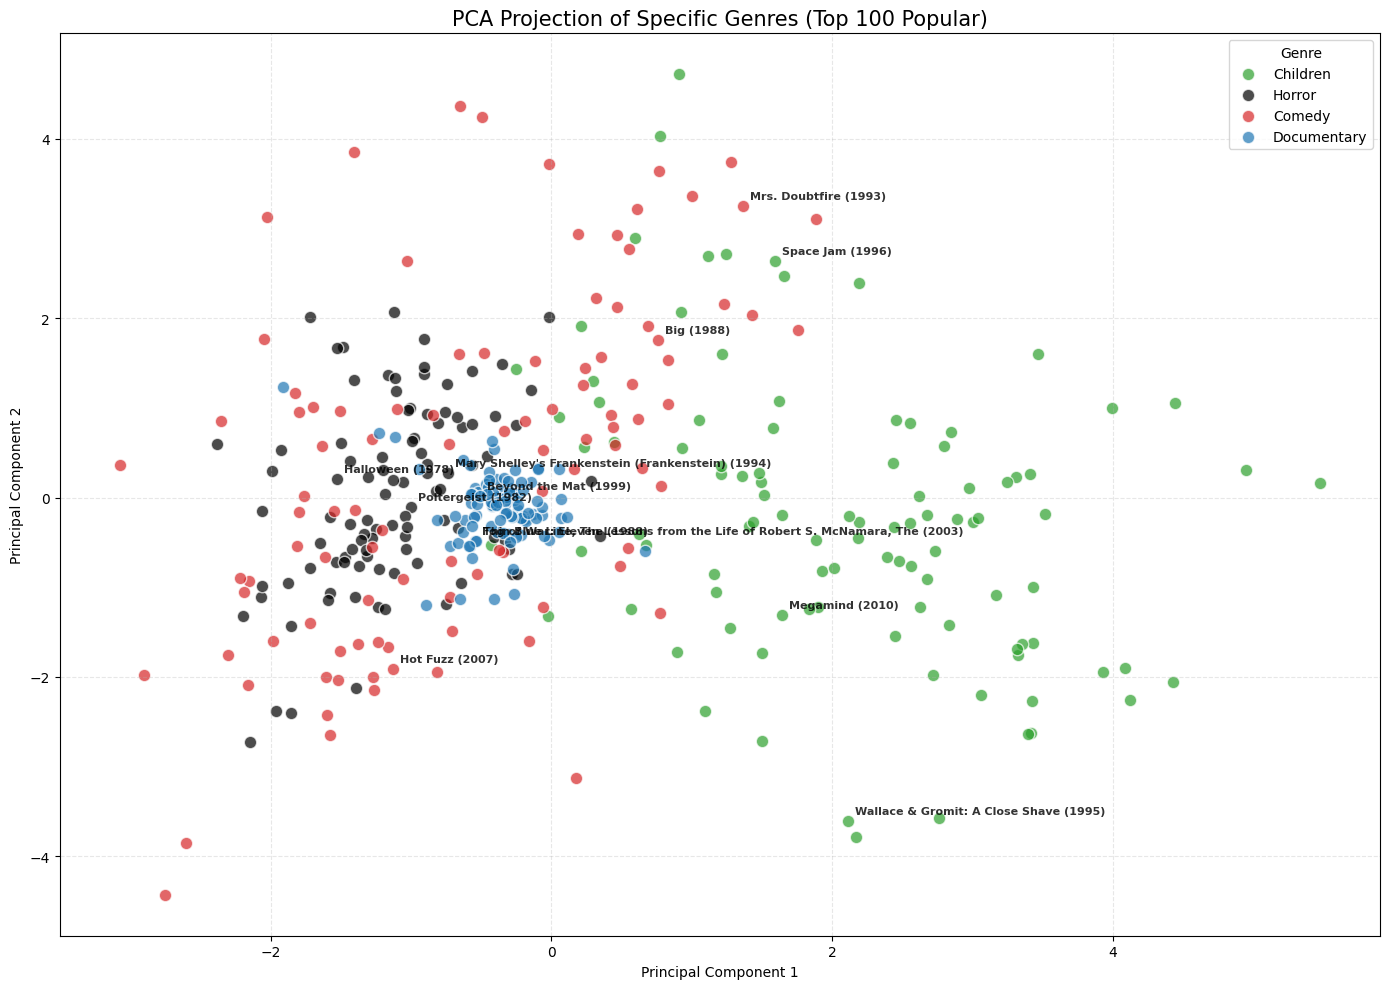

In [ ]:
# 1. NUMBA KERNELS

@njit(parallel=True)
def get_movie_counts_numba(movie_ptr):
    """Fast rating counts"""
    n_movies = len(movie_ptr) - 1
    counts = np.zeros(n_movies, dtype=np.int32)
    for m in prange(n_movies):
        counts[m] = movie_ptr[m+1] - movie_ptr[m]
    return counts

@njit(parallel=True)
def _numba_standard_scaler(data):
    """Optimized StandardScaler (Z-score normalization)"""
    n_samples, n_features = data.shape
    scaled = np.empty_like(data)

    for j in prange(n_features):
        col_sum = 0.0
        col_sq_sum = 0.0
        for i in range(n_samples):
            val = data[i, j]
            col_sum += val
            col_sq_sum += val**2

        mean = col_sum / n_samples
        var = (col_sq_sum / n_samples) - (mean * mean)
        std = np.sqrt(var) if var > 0 else 1.0

        for i in range(n_samples):
            scaled[i, j] = (data[i, j] - mean) / std

    return scaled

@njit
def _numba_pca_2d(data):
    """Optimized PCA for 2 components"""
    n_samples = data.shape[0]
    # Sample Covariance Matrix
    cov = (data.T @ data) / (n_samples - 1)

    # Eigendecomposition (returns eigenvalues in ascending order)
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # Sort descending (Top 2)
    idx = np.argsort(eig_vals)[::-1]
    components = eig_vecs[:, idx[:2]]

    # Project
    return data @ components

# 2. VISUALIZATION FUNCTION
def visualize_specific_genres_pca(ratings_matrix, movie_embeddings, df_movies,
                                  target_genres=['Children', 'Horror', 'Sci-Fi', 'Documentary'],
                                  samples_per_genre=100):

    print(f"1. Sorting movies by popularity...")
    counts = get_movie_counts_numba(ratings_matrix.movie_ptr)
    sorted_indices = np.argsort(counts)[::-1]

    print(f"2. Collecting top {samples_per_genre} movies for: {target_genres}...")

    collected_data = {genre: [] for genre in target_genres}
    seen_movies = set()

    # Filter Logic
    for idx in sorted_indices:
        if all(len(collected_data[g]) >= samples_per_genre for g in target_genres):
            break

        movie_id = ratings_matrix.idx_to_movieid[idx]
        if movie_id in seen_movies: continue

        try:
            row = df_movies[df_movies['movieId'] == movie_id].values[0]
            title = row[1]
            genre_str = row[2]

            for target in target_genres:
                if target in genre_str:
                    if len(collected_data[target]) < samples_per_genre:
                        collected_data[target].append({
                            'embedding': movie_embeddings[:, idx], # Shape (k,)
                            'title': title,
                            'genre_label': target
                        })
                        seen_movies.add(movie_id)
                        break
        except IndexError:
            continue

    # Prepare Data for PCA
    final_embeddings = []
    final_labels = []
    final_titles = []

    for genre in target_genres:
        print(f"   Found {len(collected_data[genre])} movies for '{genre}'")
        for item in collected_data[genre]:
            final_embeddings.append(item['embedding'])
            final_labels.append(item['genre_label'])
            final_titles.append(item['title'])

    # Convert to Array (N_samples, k)
    X = np.array(final_embeddings, dtype=np.float64)

    print(f"3. Running Numba PCA on shape {X.shape}...")

    X_std = _numba_standard_scaler(X)
    pca_results = _numba_pca_2d(X_std)

    print("4. Generating PCA Plot...")
    plt.figure(figsize=(14, 10))

    genre_colors = {
        'Children': 'tab:green',
        'Horror': 'black',
        'Comedy': 'tab:red',
        'Documentary': 'tab:blue'
    }

    # Plotting Loop
    for genre in target_genres:
        indices = [i for i, x in enumerate(final_labels) if x == genre]
        if not indices: continue

        points_x = pca_results[indices, 0]
        points_y = pca_results[indices, 1]

        plt.scatter(points_x, points_y,
                    c=genre_colors.get(genre, 'gray'),
                    label=genre,
                    s=80, alpha=0.7, edgecolors='white')

        # Annotate a few random titles
        import random
        if len(indices) > 0:
            subset_indices = random.sample(indices, min(3, len(indices)))
            for i in subset_indices:
                plt.annotate(final_titles[i],
                             (pca_results[i, 0], pca_results[i, 1]),
                             fontsize=8, weight='bold', alpha=0.8,
                             xytext=(5, 5), textcoords='offset points')

    plt.title(f"PCA Projection of Specific Genres (Top {samples_per_genre} Popular)", fontsize=15)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Genre")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('pca_genre.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# EXECUTION
visualize_specific_genres_pca(
    ratings_matrix,
    movie_embeddings,
    df2,
    target_genres=['Children', 'Horror', 'Comedy', 'Documentary'],
    samples_per_genre=100
)

# Practical 5:

In [ ]:
def load_genre_data(movies_csv_path, indexing_structure):
    """
    Load genre information from movies.csv compatible with Indexing_Structure.

    Parameters:
    -----------
    movies_csv_path : str
        Path to movies.csv file
    indexing_structure : Indexing_Structure
        Your sparse matrix object

    Returns:
    --------
    genre_to_idx : dict
        Maps genre name (str) -> genre index (int)
    idx_to_genre : list
        Maps genre index -> genre name
    movie_to_genres : list of lists
        movie_to_genres[movie_idx] = [genre_idx1, genre_idx2, ...]
    """
    print("\n" + "="*70)
    print("LOADING GENRE INFORMATION")
    print("="*70)

    genre_to_idx = {}
    idx_to_genre = []
    movie_to_genres = [[] for _ in range(indexing_structure.number_of_movies)]

    with open(movies_csv_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header

        movies_processed = 0
        movies_with_genres = 0

        for row in reader:
            if len(row) < 3:
                continue

            movie_id = int(row[0])
            genres_str = row[-1]  # Last column contains genres

            # Skip movies not in our ratings dataset
            if movie_id not in indexing_structure.movieid_to_idx:
                continue

            movies_processed += 1
            movie_idx = indexing_structure.movieid_to_idx[movie_id]

            # Parse genres
            if genres_str and genres_str != "(no genres listed)":
                genres = genres_str.split('|')
                movies_with_genres += 1

                for genre in genres:
                    genre = genre.strip()

                    # Add new genre to mapping
                    if genre not in genre_to_idx:
                        genre_idx = len(genre_to_idx)
                        genre_to_idx[genre] = genre_idx
                        idx_to_genre.append(genre)
                    else:
                        genre_idx = genre_to_idx[genre]

                    movie_to_genres[movie_idx].append(genre_idx)

    print(f"✓ Processed {movies_processed:,} movies")
    print(f"✓ Movies with genres: {movies_with_genres:,}")
    print(f"✓ Unique genres: {len(genre_to_idx)}")
    print(f"✓ Average genres per movie: {np.mean([len(g) for g in movie_to_genres if g]):.2f}")

    # Print all genres found
    print("\nGenres found:")
    for idx, genre in enumerate(idx_to_genre):
        count = sum(1 for genres in movie_to_genres if idx in genres)
        print(f"  {idx:2d}. {genre:20s} ({count:,} movies)")

    return genre_to_idx, idx_to_genre, movie_to_genres


def build_genre_to_movies(movie_to_genres, n_genres):
    """
    Build reverse mapping: genre_idx -> list of movie_idx that have this genre.

    Returns:
    --------
    genre_to_movies : list of numpy arrays
        genre_to_movies[genre_idx] = np.array([movie_idx1, movie_idx2, ...])
    """
    print("\nBuilding genre-to-movies mapping...")

    # First pass: count movies per genre
    genre_counts = [0] * n_genres
    for movie_idx, genres in enumerate(movie_to_genres):
        for genre_idx in genres:
            genre_counts[genre_idx] += 1

    # Second pass: allocate and fill arrays
    genre_to_movies = [np.zeros(count, dtype=np.int32) for count in genre_counts]
    genre_positions = [0] * n_genres

    for movie_idx, genres in enumerate(movie_to_genres):
        for genre_idx in genres:
            pos = genre_positions[genre_idx]
            genre_to_movies[genre_idx][pos] = movie_idx
            genre_positions[genre_idx] += 1

    print(f"✓ Genre-to-movies mapping built")
    return genre_to_movies


def prepare_genre_data_for_numba(movie_to_genres, genre_to_movies, n_movies, n_genres):
    """
    Convert Python lists to flat numpy arrays for Numba.

    Returns:
    --------
    movie_to_genres_flat : np.array (int32)
        All genre indices concatenated
    movie_genre_start : np.array (int32, size n_movies+1)
        movie_genre_start[n] = start index in movie_to_genres_flat
    genre_to_movies_flat : np.array (int32)
        All movie indices concatenated
    genre_movie_start : np.array (int32, size n_genres+1)
        genre_movie_start[f] = start index in genre_to_movies_flat
    """
    print("\nPreparing genre data for Numba...")

    # Flatten movie -> genres
    movie_to_genres_flat = []
    movie_genre_start = np.zeros(n_movies + 1, dtype=np.int32)

    for n in range(n_movies):
        movie_genre_start[n] = len(movie_to_genres_flat)
        movie_to_genres_flat.extend(movie_to_genres[n])
    movie_genre_start[n_movies] = len(movie_to_genres_flat)

    movie_to_genres_flat = np.array(movie_to_genres_flat, dtype=np.int32)

    # Flatten genre -> movies
    genre_to_movies_flat = []
    genre_movie_start = np.zeros(n_genres + 1, dtype=np.int32)

    for f in range(n_genres):
        genre_movie_start[f] = len(genre_to_movies_flat)
        genre_to_movies_flat.extend(genre_to_movies[f])
    genre_movie_start[n_genres] = len(genre_to_movies_flat)

    genre_to_movies_flat = np.array(genre_to_movies_flat, dtype=np.int32)

    print(f"✓ Movie-to-genres array: {len(movie_to_genres_flat):,} entries")
    print(f"✓ Genre-to-movies array: {len(genre_to_movies_flat):,} entries")

    return movie_to_genres_flat, movie_genre_start, genre_to_movies_flat, genre_movie_start



LOADING GENRE INFORMATION
✓ Processed 84,432 movies
✓ Movies with genres: 77,877
✓ Unique genres: 19
✓ Average genres per movie: 1.83

Genres found:
   0. Adventure            (5,156 movies)
   1. Animation            (4,586 movies)
   2. Children             (4,447 movies)
   3. Comedy               (22,448 movies)
   4. Fantasy              (3,784 movies)
   5. Romance              (10,048 movies)
   6. Drama                (33,152 movies)
   7. Action               (9,296 movies)
   8. Crime                (6,704 movies)
   9. Thriller             (11,555 movies)
  10. Horror               (8,468 movies)
  11. Mystery              (3,894 movies)
  12. Sci-Fi               (4,797 movies)
  13. IMAX                 (195 movies)
  14. Documentary          (9,103 movies)
  15. War                  (2,225 movies)
  16. Musical              (1,033 movies)
  17. Western              (1,489 movies)
  18. Film-Noir            (350 movies)

Building genre-to-movies mapping...
✓ Genre-to-movi

In [ ]:
@njit
def solve_linear_system_stable(A, b):
    """
    Solve Ax = b with numerical stability using Cholesky.
    """
    k = len(b)
    A_stable = A + 1e-10 * np.eye(k)

    if not np.all(np.isfinite(A_stable)) or not np.all(np.isfinite(b)):
        return np.zeros(k)

    try:
        L = np.linalg.cholesky(A_stable)
        y = np.linalg.solve(L, b)
        x = np.linalg.solve(L.T, y)
        if np.all(np.isfinite(x)):
            return x
    except:
        pass

    x, _, _, _ = np.linalg.lstsq(A_stable, b)
    if not np.all(np.isfinite(x)):
        return np.zeros(k)

    return x


@njit(parallel=True)
def compute_movie_priors_numba(n_movies, k, movie_to_genres_flat, movie_genre_start, W, V_prior):
    """
    Compute prior for each movie: average of its genre embeddings.

    Parameters:
    -----------
    n_movies : int
        Number of movies
    k : int
        Latent dimension
    movie_to_genres_flat : np.array (int32)
        Flattened array of genre indices
    movie_genre_start : np.array (int32)
        Start indices for each movie
    W : np.array (float64, shape n_genres x k)
        Genre embeddings
    V_prior : np.array (float64, shape n_movies x k) [OUTPUT]
        Will be filled with movie priors
    """
    for n in prange(n_movies):
        start = movie_genre_start[n]
        end = movie_genre_start[n + 1]
        n_genres = end - start

        if n_genres == 0:
            # No genres: prior is zero
            for j in range(k):
                V_prior[n, j] = 0.0
        else:
            # Prior = average of genre embeddings
            for j in range(k):
                sum_val = 0.0
                for idx in range(start, end):
                    genre_idx = movie_to_genres_flat[idx]
                    sum_val += W[genre_idx, j]
                V_prior[n, j] = sum_val / n_genres


@njit
def update_user_params_genre(user_idx, user_ptr, csr_col_indices, csr_values,
                             user_embeddings, movie_embeddings, movie_biases,
                             lamda, gamma_u, gamma_b, k):
    """Update user bias and embedding (unchanged from standard ALS)."""
    start = user_ptr[user_idx]
    end = user_ptr[user_idx + 1]
    n_ratings = end - start

    if n_ratings == 0:
        return 0.0, user_embeddings[:, user_idx].copy()

    # Update bias
    bias_sum = 0.0
    user_emb = user_embeddings[:, user_idx].copy()

    for i in range(start, end):
        movie_idx = csr_col_indices[i]
        rating = csr_values[i]
        movie_emb = movie_embeddings[:, movie_idx].copy()
        pred_no_bias = np.dot(user_emb, movie_emb)
        bias_sum += rating - movie_biases[movie_idx] - pred_no_bias

    new_bias = (lamda * bias_sum) / (lamda * n_ratings + gamma_b)

    # Update embedding
    A = gamma_u * np.eye(k)
    b = np.zeros(k)

    for i in range(start, end):
        movie_idx = csr_col_indices[i]
        rating = csr_values[i]
        v_n = movie_embeddings[:, movie_idx].copy()

        if not np.all(np.isfinite(v_n)):
            continue

        A += lamda * np.outer(v_n, v_n)
        resid = rating - new_bias - movie_biases[movie_idx]
        b += lamda * v_n * resid

    new_emb = solve_linear_system_stable(A, b)
    return new_bias, new_emb


@njit
def update_movie_params_with_genre_prior(movie_idx, movie_ptr, csc_row_indices, csc_values,
                                         user_embeddings, movie_embeddings, user_biases,
                                         V_prior, lamda, gamma_v, gamma_b, k):
    """
    Update movie bias and embedding WITH genre regularization.

    KEY CHANGE: Regularizes toward V_prior instead of zero.
    """
    start = movie_ptr[movie_idx]
    end = movie_ptr[movie_idx + 1]
    m_ratings = end - start

    if m_ratings == 0:
        # No ratings: set to prior
        return 0.0, V_prior[movie_idx].copy()

    # Update bias
    bias_sum = 0.0
    movie_emb = movie_embeddings[:, movie_idx].copy()

    for i in range(start, end):
        user_idx = csc_row_indices[i]
        rating = csc_values[i]
        user_emb = user_embeddings[:, user_idx].copy()
        pred_no_bias = np.dot(user_emb, movie_emb)
        bias_sum += rating - user_biases[user_idx] - pred_no_bias

    new_bias = (lamda * bias_sum) / (lamda * m_ratings + gamma_b)

    # Update embedding with genre prior
    A = gamma_v * np.eye(k)
    b = gamma_v * V_prior[movie_idx].copy()

    for i in range(start, end):
        user_idx = csc_row_indices[i]
        rating = csc_values[i]
        u_m = user_embeddings[:, user_idx].copy()

        if not np.all(np.isfinite(u_m)):
            continue

        A += lamda * np.outer(u_m, u_m)
        resid = rating - user_biases[user_idx] - new_bias
        b += lamda * u_m * resid

    new_emb = solve_linear_system_stable(A, b)
    return new_bias, new_emb


@njit(parallel=True)
def update_all_genres_numba(n_genres, k, tau, eta, W, V,
                            genre_to_movies_flat, genre_movie_start):
    """
    Update genre embeddings.

    For each genre: W[f] = weighted average of movie embeddings that have this genre.
    """
    for f in prange(n_genres):
        start = genre_movie_start[f]
        end = genre_movie_start[f + 1]
        n_movies = end - start

        if n_movies == 0:
            # No movies with this genre: set to zero
            for j in range(k):
                W[f, j] = 0.0
            continue

        # W[f] = weighted average of movie embeddings
        denominator = tau * n_movies + eta

        for j in range(k):
            numerator = 0.0
            for idx in range(start, end):
                movie_idx = genre_to_movies_flat[idx]
                numerator += tau * V[j, movie_idx]

            W[f, j] = numerator / denominator


@njit(parallel=True)
def compute_rmse_numba_genre(user_ptr, csr_col_indices, csr_values,
                             user_embeddings, movie_embeddings,
                             user_biases, movie_biases):
    """Compute RMSE using CSR format."""
    n_users = len(user_ptr) - 1
    squared_errors = np.zeros(n_users)
    counts = np.zeros(n_users, dtype=np.int32)

    for user_idx in prange(n_users):
        start = user_ptr[user_idx]
        end = user_ptr[user_idx + 1]
        n_ratings = end - start

        if n_ratings == 0:
            continue

        local_se = 0.0
        user_emb = user_embeddings[:, user_idx].copy()

        for i in range(start, end):
            movie_idx = csr_col_indices[i]
            rating = csr_values[i]
            movie_emb = movie_embeddings[:, movie_idx].copy()

            pred = user_biases[user_idx] + movie_biases[movie_idx] + np.dot(user_emb, movie_emb)
            local_se += (rating - pred) ** 2

        squared_errors[user_idx] = local_se
        counts[user_idx] = n_ratings

    total_se = np.sum(squared_errors)
    total_count = np.sum(counts)

    return np.sqrt(total_se / total_count) if total_count > 0 else np.inf


@njit
def train_one_iteration_with_genres(user_ptr_train, csr_col_train, csr_val_train,
                                     movie_ptr_train, csc_row_train, csc_val_train,
                                     user_embeddings, movie_embeddings,
                                     user_biases, movie_biases, V_prior,
                                     lamda, gamma_u, gamma_v, gamma_b, k):
    """One full ALS iteration with genre priors."""
    n_users = len(user_ptr_train) - 1
    n_movies = len(movie_ptr_train) - 1

    # Update users
    for user_idx in range(n_users):
        new_bias, new_emb = update_user_params_genre(
            user_idx, user_ptr_train, csr_col_train, csr_val_train,
            user_embeddings, movie_embeddings, movie_biases,
            lamda, gamma_u, gamma_b, k
        )
        user_biases[user_idx] = new_bias
        user_embeddings[:, user_idx] = new_emb

    # Update movies (with genre prior)
    for movie_idx in range(n_movies):
        new_bias, new_emb = update_movie_params_with_genre_prior(
            movie_idx, movie_ptr_train, csc_row_train, csc_val_train,
            user_embeddings, movie_embeddings, user_biases,
            V_prior, lamda, gamma_v, gamma_b, k
        )
        movie_biases[movie_idx] = new_bias
        movie_embeddings[:, movie_idx] = new_emb

    return user_embeddings, movie_embeddings, user_biases, movie_biases


## Training Functions

In [ ]:
def train_als_with_genres(indexing_structure, movie_to_genres_flat, movie_genre_start,
                          genre_to_movies_flat, genre_movie_start, n_genres,
                          k=30, lamda=0.01, gamma_u=0.01, gamma_v=0.01,
                          gamma_b=0.1, tau=0.05, eta=0.01, iterations=20):
    """
    Train ALS with genre integration.

    Parameters:
    -----------
    indexing_structure : Indexing_Structure
        Your sparse matrix object
    movie_to_genres_flat, movie_genre_start : np.array
        Flattened genre data
    genre_to_movies_flat, genre_movie_start : np.array
        Reverse mapping
    n_genres : int
        Number of genres
    k : int
        Latent dimensions
    lamda, gamma_u, gamma_v, gamma_b, tau, eta : float
        Regularization parameters
    iterations : int
        Number of iterations
    """

    print("="*70)
    print("TRAINING ALS WITH GENRE INTEGRATION")
    print("="*70)
    print(f"Users: {indexing_structure.number_of_users:,}")
    print(f"Movies: {indexing_structure.number_of_movies:,}")
    print(f"Genres: {n_genres}")
    print(f"Latent factors (k): {k}")
    print(f"Iterations: {iterations}")
    print(f"λ (lamda): {lamda}, τ (tau): {tau}, γ (gamma_b): {gamma_b}, η (eta): {eta}")
    print("="*70)

    # Initialize
    user_biases = np.zeros(indexing_structure.number_of_users, dtype=np.float64)
    movie_biases = np.zeros(indexing_structure.number_of_movies, dtype=np.float64)
    user_embeddings = np.ascontiguousarray(
        np.random.normal(0, 0.01, size=(k, indexing_structure.number_of_users)),
        dtype=np.float64
    )
    movie_embeddings = np.ascontiguousarray(
        np.random.normal(0, 0.01, size=(k, indexing_structure.number_of_movies)),
        dtype=np.float64
    )
    W = np.ascontiguousarray(
        np.random.normal(0, 0.01, size=(n_genres, k)),
        dtype=np.float64
    )
    V_prior = np.zeros((indexing_structure.number_of_movies, k), dtype=np.float64)

    # Prepare arrays
    user_ptr_train = np.ascontiguousarray(indexing_structure.user_ptr_train, dtype=np.int32)
    csr_col_train = np.ascontiguousarray(indexing_structure.csr_col_indices_train, dtype=np.int32)
    csr_val_train = np.ascontiguousarray(indexing_structure.csr_values_train, dtype=np.float64)

    movie_ptr_train = np.ascontiguousarray(indexing_structure.movie_ptr_train, dtype=np.int32)
    csc_row_train = np.ascontiguousarray(indexing_structure.csc_row_indices_train, dtype=np.int32)
    csc_val_train = np.ascontiguousarray(indexing_structure.csc_values_train, dtype=np.float64)

    user_ptr_test = np.ascontiguousarray(indexing_structure.user_ptr_test, dtype=np.int32)
    csr_col_test = np.ascontiguousarray(indexing_structure.csr_col_indices_test, dtype=np.int32)
    csr_val_test = np.ascontiguousarray(indexing_structure.csr_values_test, dtype=np.float64)

    # Training history
    loss_history = []
    rmse_history = []
    rmse_test_history = []

    import time

    for iteration in range(iterations):
        iter_start = time.time()

        # Step 1: Compute movie priors from genre embeddings
        compute_movie_priors_numba(
            indexing_structure.number_of_movies, k,
            movie_to_genres_flat, movie_genre_start,
            W, V_prior
        )

        # Step 2: Update users and movies
        user_embeddings, movie_embeddings, user_biases, movie_biases = \
            train_one_iteration_with_genres(
                user_ptr_train, csr_col_train, csr_val_train,
                movie_ptr_train, csc_row_train, csc_val_train,
                user_embeddings, movie_embeddings,
                user_biases, movie_biases, V_prior,
                lamda, gamma_u, gamma_v, gamma_b, k
            )

        # Step 3: Update genres
        update_all_genres_numba(
            n_genres, k, tau, eta,
            W, movie_embeddings,
            genre_to_movies_flat, genre_movie_start
        )

        # Evaluate
        train_rmse = compute_rmse_numba_genre(
            user_ptr_train, csr_col_train, csr_val_train,
            user_embeddings, movie_embeddings,
            user_biases, movie_biases
        )

        test_rmse = compute_rmse_numba_genre(
            user_ptr_test, csr_col_test, csr_val_test,
            user_embeddings, movie_embeddings,
            user_biases, movie_biases
        )

        # Compute loss
        reg_bias = np.sum(user_biases**2) + np.sum(movie_biases**2)
        reg_factors = np.sum(user_embeddings**2) + np.sum((movie_embeddings.T - V_prior)**2)
        reg_genres = np.sum(W**2)

        loss = (lamda/2) * (train_rmse**2) + (tau/2) * reg_factors + \
               (gamma_b/2) * reg_bias + (eta/2) * reg_genres

        loss_history.append(loss)
        rmse_history.append(train_rmse)
        rmse_test_history.append(test_rmse)

        iter_time = time.time() - iter_start

        print(f"Iteration {iteration+1}/{iterations}: "
              f"Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}, "
              f"Loss = {loss:.2f}, Time = {iter_time:.2f}s")

    print("="*70)
    print("TRAINING COMPLETE")
    print(f"Final Train RMSE: {rmse_history[-1]:.4f}")
    print(f"Final Test RMSE: {rmse_test_history[-1]:.4f}")
    print("="*70)

    return user_embeddings, movie_embeddings, user_biases, movie_biases, W, \
           loss_history, rmse_history, rmse_test_history

## Usage Example

In [ ]:
# Load genre data
genre_to_idx, idx_to_genre, movie_to_genres = load_genre_data(
    "movies.csv",  # Adjust path
    ratings_matrix  # Your Indexing_Structure object
)

# Build reverse mapping
genre_to_movies = build_genre_to_movies(
    movie_to_genres,
    len(genre_to_idx)
)

# Prepare for Numba
movie_to_genres_flat, movie_genre_start, \
genre_to_movies_flat, genre_movie_start = prepare_genre_data_for_numba(
    movie_to_genres,
    genre_to_movies,
    ratings_matrix.number_of_movies,
    len(genre_to_idx)
)

# Train model with genres
user_embeddings, movie_embeddings, user_biases, movie_biases, W, \
loss_history, rmse_history, rmse_test_history = train_als_with_genres(
    ratings_matrix,
    movie_to_genres_flat, movie_genre_start,
    genre_to_movies_flat, genre_movie_start,
    n_genres=len(genre_to_idx),
    k=20,
    lamda=0.01,
    gamma_u=0.01,
    gamma_v=0.01,
    gamma_b=0.1,
    tau=0.05,
    eta=0.01,
    iterations=20
)

## Visualization

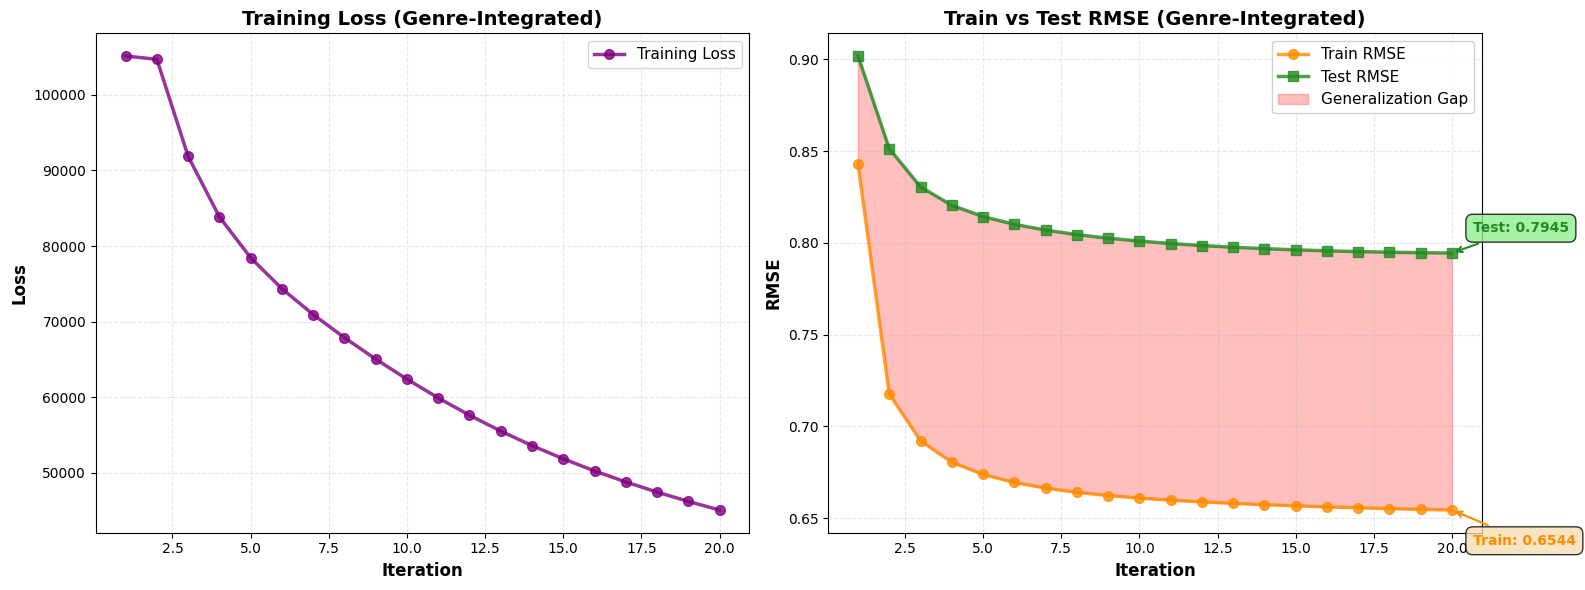

In [ ]:
def plot_genre_training_results(loss_history, rmse_history, rmse_test_history):
    """
    Enhanced plotting for genre-integrated ALS training with overfitting gap.
    """

    iterations = np.arange(1, len(loss_history) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # PLOT 1: LOSS OVER ITERATIONS
    ax1 = axes[0]

    ax1.plot(iterations, loss_history, marker='o', linewidth=2.5, markersize=7,
             color='purple', label='Training Loss', alpha=0.8)

    ax1.set_title("Training Loss (Genre-Integrated)",
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel("Iteration", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Loss", fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=11)


    # PLOT 2: TRAIN VS TEST RMSE WITH OVERFITTING GAP
    ax2 = axes[1]

    # Plot train and test RMSE
    ax2.plot(iterations, rmse_history, marker='o', linewidth=2.5, markersize=7,
             color='darkorange', label='Train RMSE', alpha=0.8, zorder=3)
    ax2.plot(iterations, rmse_test_history, marker='s', linewidth=2.5, markersize=7,
             color='forestgreen', label='Test RMSE', alpha=0.8, zorder=3)

    # Fill the overfitting gap
    ax2.fill_between(iterations, rmse_history, rmse_test_history,
                     where=(np.array(rmse_test_history) >= np.array(rmse_history)),
                     alpha=0.25, color='red', label='Generalization Gap', zorder=1)

    # Calculate gaps and improvements
    final_gap = rmse_test_history[-1] - rmse_history[-1]
    final_gap_pct = (final_gap / rmse_test_history[-1]) * 100
    improvement_train = ((rmse_history[0] - rmse_history[-1]) / rmse_history[0]) * 100
    improvement_test = ((rmse_test_history[0] - rmse_test_history[-1]) / rmse_test_history[0]) * 100

    # Annotations for final values
    ax2.annotate(f'Train: {rmse_history[-1]:.4f}',
                xy=(len(rmse_history), rmse_history[-1]),
                xytext=(15, -25), textcoords='offset points',
                fontsize=10, color='darkorange', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='darkorange', lw=1.5),
                zorder=5)

    ax2.annotate(f'Test: {rmse_test_history[-1]:.4f}',
                xy=(len(rmse_test_history), rmse_test_history[-1]),
                xytext=(15, 15), textcoords='offset points',
                fontsize=10, color='forestgreen', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='forestgreen', lw=1.5),
                zorder=5)

    # Title and labels
    ax2.set_title("Train vs Test RMSE (Genre-Integrated)",
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel("Iteration", fontsize=12, fontweight='bold')
    ax2.set_ylabel("RMSE", fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--', zorder=0)
    ax2.legend(loc='upper right', fontsize=11, framealpha=0.9)


    plt.tight_layout()
    plt.savefig('genre_als_training.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

plot_genre_training_results(loss_history, rmse_history, rmse_test_history)

## PCA Visualization

In [ ]:
@njit(parallel=True)
def get_movie_counts_numba(movie_ptr):
    """Fast rating counts using CSR/CSC pointers"""
    n_movies = len(movie_ptr) - 1
    counts = np.zeros(n_movies, dtype=np.int32)
    for m in prange(n_movies):
        counts[m] = movie_ptr[m+1] - movie_ptr[m]
    return counts

@njit(parallel=True)
def _numba_standard_scaler(data):
    """Optimized StandardScaler (Z-score normalization)"""
    n_samples, n_features = data.shape
    scaled = np.empty_like(data)

    for j in prange(n_features):
        col_sum = 0.0
        col_sq_sum = 0.0
        for i in range(n_samples):
            val = data[i, j]
            col_sum += val
            col_sq_sum += val**2

        mean = col_sum / n_samples
        var = (col_sq_sum / n_samples) - (mean * mean)
        std = np.sqrt(var) if var > 0 else 1.0

        for i in range(n_samples):
            scaled[i, j] = (data[i, j] - mean) / std

    return scaled

@njit
def _numba_pca_2d(data):
    """Optimized PCA for 2 components"""
    n_samples = data.shape[0]
    # Sample Covariance Matrix
    cov = (data.T @ data) / (n_samples - 1)

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eigh(cov)

    # Sort descending (Top 2)
    idx = np.argsort(eig_vals)[::-1]
    components = eig_vecs[:, idx[:2]]

    # Project
    return data @ components

In [ ]:
def load_movie_titles(movies_csv_path, indexing_structure):
    """
    Loads movie titles mapped to the internal matrix index.
    Returns: dict { internal_idx : "Movie Title" }
    """
    idx_to_title = {}
    with open(movies_csv_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader) # Skip header
        for row in reader:
            if len(row) < 2: continue
            movie_id = int(row[0])
            title = row[1]

            # Only store if this movie exists in our training set
            if movie_id in indexing_structure.movieid_to_idx:
                internal_idx = indexing_structure.movieid_to_idx[movie_id]
                idx_to_title[internal_idx] = title
    return idx_to_title

In [ ]:
def visualize_specific_genres_pca(indexing_structure, movie_embeddings,
                                  idx_to_genre, movie_to_genres, idx_to_title,
                                  target_genres=['Children', 'Horror', 'Sci-Fi', 'Documentary'],
                                  samples_per_genre=100):

    print("\n" + "="*70)
    print("VISUALIZING EMBEDDINGS (PCA)")
    print("="*70)

    # 1. Calculate Popularity (using training pointers)
    print(f"1. Sorting movies by popularity...")
    # We use movie_ptr_train to ensure we visualize movies that actually had ratings
    counts = get_movie_counts_numba(np.array(indexing_structure.movie_ptr_train))
    sorted_indices = np.argsort(counts)[::-1]

    print(f"2. Collecting top {samples_per_genre} movies for: {target_genres}...")

    collected_data = {genre: [] for genre in target_genres}

    # Create a fast lookup set for target genres
    target_set = set(target_genres)

    # Pre-map genre strings to their internal IDs for O(1) lookup
    # This maps 'Horror' -> 5 (example)
    target_genre_indices = {}
    for g_name in target_genres:
        try:
            # Find the index in the list idx_to_genre
            g_idx = idx_to_genre.index(g_name)
            target_genre_indices[g_name] = g_idx
        except ValueError:
            print(f"Warning: Genre '{g_name}' not found in dataset. Skipping.")
            del collected_data[g_name]

    seen_movies = set()

    # Iterate through movies by popularity
    for movie_idx in sorted_indices:
        # Stop if all buckets are full
        if all(len(collected_data[g]) >= samples_per_genre for g in collected_data):
            break

        if movie_idx in seen_movies: continue

        # Get the genres for this movie (List of integers)
        movie_genre_indices = movie_to_genres[movie_idx]

        # Get Title
        title = idx_to_title.get(movie_idx, f"Movie {movie_idx}")

        # Check if this movie belongs to any target genre
        for genre_name, genre_idx in target_genre_indices.items():

            # Fast integer check: is the genre_idx in this movie's genre list?
            if genre_idx in movie_genre_indices:
                if len(collected_data[genre_name]) < samples_per_genre:

                    collected_data[genre_name].append({
                        'embedding': movie_embeddings[:, movie_idx], # Shape (k,)
                        'title': title,
                        'genre_label': genre_name
                    })
                    seen_movies.add(movie_idx)
                    break # Assign movie to only one category to avoid duplicates in plot

    # Prepare Data for PCA
    final_embeddings = []
    final_labels = []
    final_titles = []

    for genre in collected_data:
        print(f"   Found {len(collected_data[genre])} movies for '{genre}'")
        for item in collected_data[genre]:
            final_embeddings.append(item['embedding'])
            final_labels.append(item['genre_label'])
            final_titles.append(item['title'])

    if not final_embeddings:
        print("Error: No movies found for the specified genres.")
        return

    # Convert to Array (N_samples, k)
    X = np.array(final_embeddings, dtype=np.float64)

    print(f"3. Running Numba PCA on shape {X.shape}...")

    X_std = _numba_standard_scaler(X)
    pca_results = _numba_pca_2d(X_std)

    print("4. Generating PCA Plot...")
    plt.figure(figsize=(14, 10))

    # Define colors
    genre_colors = {
        'Children': 'tab:green',
        'Horror': 'black',
        'Comedy': 'tab:red',
        'Documentary': 'tab:blue',
        'Sci-Fi': 'tab:purple',
        'Action': 'tab:orange',
        'Drama': 'tab:olive'
    }

    # Plotting Loop
    for genre in collected_data:
        indices = [i for i, x in enumerate(final_labels) if x == genre]
        if not indices: continue

        # Filter points
        points_x = pca_results[indices, 0]
        points_y = pca_results[indices, 1]

        plt.scatter(points_x, points_y,
                    c=genre_colors.get(genre, 'gray'),
                    label=genre,
                    s=80, alpha=0.7, edgecolors='white')

        # Annotate a few random titles
        import random
        if len(indices) > 0:
            subset_indices = random.sample(indices, min(3, len(indices)))
            for i in subset_indices:
                # Map back to original list index
                original_idx = indices.index(i)
                # Actually, indices contains the indices of final_labels.
                # So i IS the index in final_titles
                plt.annotate(final_titles[i],
                             (pca_results[i, 0], pca_results[i, 1]),
                             fontsize=8, weight='bold', alpha=0.8,
                             xytext=(5, 5), textcoords='offset points')

    plt.title(f"PCA Projection of Genre Embeddings (Top {samples_per_genre} Popular)", fontsize=15)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Genre")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('pca_genre_integrated.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


VISUALIZING EMBEDDINGS (PCA)
1. Sorting movies by popularity...
2. Collecting top 100 movies for: ['Children', 'Horror', 'Comedy', 'Documentary']...
   Found 100 movies for 'Children'
   Found 100 movies for 'Horror'
   Found 100 movies for 'Comedy'
   Found 100 movies for 'Documentary'
3. Running Numba PCA on shape (400, 20)...
4. Generating PCA Plot...


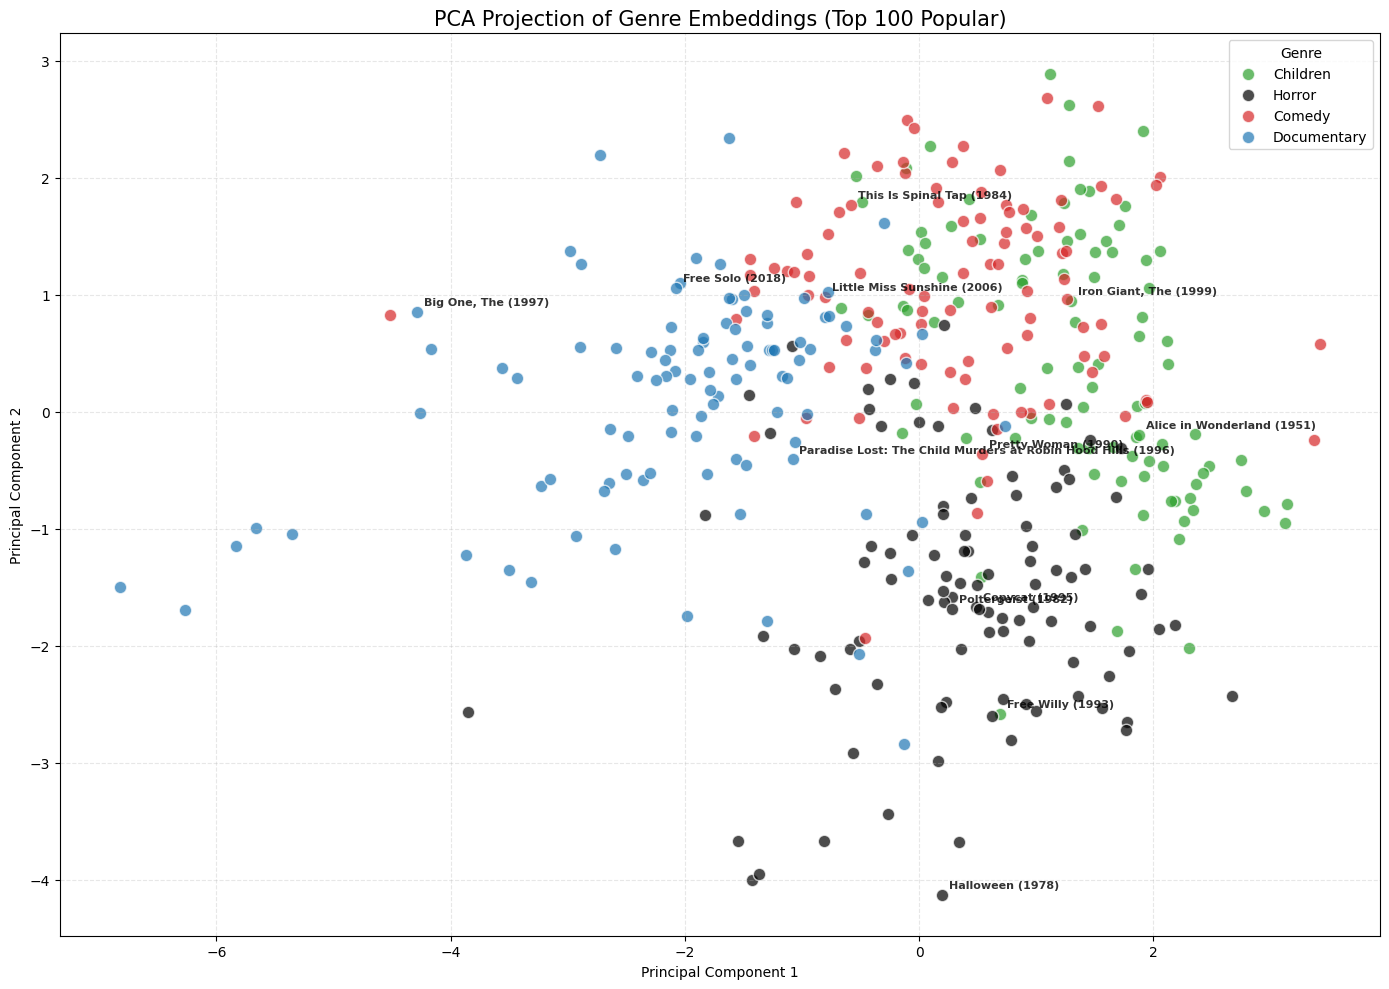

In [ ]:
idx_to_title = load_movie_titles("movies.csv", ratings_matrix)

visualize_specific_genres_pca(
    indexing_structure=ratings_matrix,
    movie_embeddings=movie_embeddings,  # The output from train_als_with_genres
    idx_to_genre=idx_to_genre,          # Output from load_genre_data
    movie_to_genres=movie_to_genres,    # Output from load_genre_data
    idx_to_title=idx_to_title,          # The dictionary we just loaded
    target_genres=['Children', 'Horror', 'Comedy', 'Documentary'],
    samples_per_genre=100
)

# Save Model for Streamlit Usage:

In [ ]:
# ---------------------------------------------------------
# SAVE MODEL AND MAPPINGS IN ONE FILE
# ---------------------------------------------------------
import numpy as np

print("Saving model to best_model.npz...")

np.savez(
    'best_model.npz',
    user_embeddings=user_embeddings,   # Or best_embeddings['user_embeddings']
    movie_embeddings=movie_embeddings, # Or best_embeddings['movie_embeddings']
    user_biases=user_biases,           # Or best_embeddings['user_biases']
    movie_biases=movie_biases,         # Or best_embeddings['movie_biases']

    movie_id_map=ratings_matrix.movieid_to_idx,
    user_id_map=ratings_matrix.userid_to_idx
)

print("Success!")

Saving model to best_model.npz...
✅ Success! 'best_model.npz' now contains the ID mappings.


In [ ]:
# Load your existing model
model_data = np.load('best_model.npz', allow_pickle=True)

# Extract existing data
user_embeddings = model_data['user_embeddings']
movie_embeddings = model_data['movie_embeddings']
user_biases = model_data['user_biases']
movie_biases = model_data['movie_biases']
movie_id_map = model_data['movie_id_map'].item()
user_id_map = model_data['user_id_map'].item()

# Hyperparameters
k = 20
lamda = 0.02039307537342147
gamma_u = 0.8587551700375037
gamma_v = 0.8034116286188123
gamma_b = 0.00192377578961482

try:
    movie_counts = np.diff(ratings_matrix.movie_ptr)
except:
    print("⚠ Could not get movie_counts, will use default filtering")
    movie_counts = None

# Re-save with all parameters
if movie_counts is not None:
    np.savez_compressed('best_model.npz',
        user_embeddings=user_embeddings,
        movie_embeddings=movie_embeddings,
        user_biases=user_biases,
        movie_biases=movie_biases,
        movie_id_map=movie_id_map,
        user_id_map=user_id_map,
        lamda=lamda,
        gamma_u=gamma_u,
        gamma_b=gamma_b,
        gamma_v=gamma_v,
        movie_counts=movie_counts
    )
else:
    np.savez_compressed('best_model.npz',
        user_embeddings=user_embeddings,
        movie_embeddings=movie_embeddings,
        user_biases=user_biases,
        movie_biases=movie_biases,
        movie_id_map=movie_id_map,
        user_id_map=user_id_map,
        lamda=lamda,
        gamma_u=gamma_u,
        gamma_b=gamma_b,
        gamma_v=gamma_v,
    )

print("Model re-saved with hyperparameters!")
print(f"   λ = {lamda}")
print(f"   γ_u = {gamma_u}")
print(f"   γ_b = {gamma_b}")

✅ Model re-saved with hyperparameters!
   λ = 0.02039307537342147
   γ_u = 0.8587551700375037
   γ_b = 0.00192377578961482

Now upload this new best_model.npz to Google Drive and update the file ID in your app.
